In [41]:
import os
import yaml
import cv2
from PIL import Image
import zipfile
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary


import warnings


In [42]:
with open("/content/config.yml", "r") as file:
  config =  yaml.safe_load(file)

class Loader:
    def __init__(self, image_path = None, image_size = 256, batch_size = 1, split_size = 0.25):
        self.image_path = image_path
        self.image_size = image_size
        self.batch_size = batch_size
        self.split_size = split_size

        self.X = []
        self.y = []

    def image_transforms(self):
        return transforms.Compose(
            [
                transforms.Resize((self.image_size, self.image_size), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.RandomCrop((self.image_size, self.image_size)),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
    def image_splits(self, **kwargs):
        return train_test_split(
            kwargs["X"],
            kwargs["y"],
            test_size = self.split_size,
            random_state = 42
            )

    def unzip_folder(self):
        if os.path.exists(config["path"]["raw_path"]):
            with zipfile.ZipFile(self.image_path, "r") as zip_ref:
                zip_ref.extractall(path=os.path.join(config["path"]["raw_path"], ))
        else:
            raise Exception("Unable to find the zip file".capitalize())

    def extract_features(self):
        if os.path.exists(config["path"]["raw_path"]):
            self.directory = os.path.join(config["path"]["raw_path"], "dataset")
            self.images = os.path.join(self.directory, os.listdir(self.directory)[0])
            self.masks = os.path.join(self.directory, os.listdir(self.directory)[1])

            for image in tqdm(os.listdir(self.images)):
                for mask in os.listdir(self.masks):
                    image_base_name = image.split(".")[0]
                    masks_base_name = mask.split(".")[0]

                    if image_base_name == masks_base_name:

                        X = cv2.imread(os.path.join(self.images, image))
                        X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
                        y = cv2.imread(os.path.join(self.masks, mask))
                        y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)

                        self.X.append(self.image_transforms()(Image.fromarray(X)))
                        self.y.append(self.image_transforms()(Image.fromarray(y)))

            X_train, X_test, y_train, y_test = self.image_splits(X=self.X, y=self.y)

            return {
                "X_train": X_train,
                "y_train": y_train,
                "X_test": X_test,
                "y_test": y_test,
                "X": self.X,
                "y": self.y,
            }

        else:
            raise Exception("Unable to find the zip file".capitalize())

    def create_dataloader(self):
        dataset = self.extract_features()

        if os.path.exists(config["path"]["processed_path"]):
            dataloader = DataLoader(
                dataset=list(zip(dataset["X"], dataset["y"])),
                batch_size=self.batch_size*16, shuffle=True)

            train_dataloader = DataLoader(
                dataset=list(zip(dataset["X_train"], dataset["y_train"])),
                batch_size=self.batch_size, shuffle=True)

            test_dataloader = DataLoader(
                dataset=list(zip(dataset["X_test"], dataset["y_test"])),
                batch_size=self.batch_size*4, shuffle=True)

            return train_dataloader

        else:
            raise Exception("Unable to create the dataloader file".capitalize())

In [44]:
loader = Loader(image_path="/content/data/raw/seGAN.zip", split_size=0.10)

# loader.unzip_folder()
train_dataset = loader.create_dataloader()

100%|██████████| 6/6 [00:00<00:00, 19.06it/s]


In [12]:
!rm -rf /content/data/raw/dataset

In [45]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetGenerator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetGenerator, self).__init__()
        self.enc1 = self.down_block(in_channels, 64, apply_batchnorm=False)  # (batch_size, 64, 128, 128)
        self.enc2 = self.down_block(64, 128)                                 # (batch_size, 128, 64, 64)
        self.enc3 = self.down_block(128, 256)                                # (batch_size, 256, 32, 32)
        self.enc4 = self.down_block(256, 512)                                # (batch_size, 512, 16, 16)
        self.enc5 = self.down_block(512, 512)                                # (batch_size, 512, 8, 8)
        self.enc6 = self.down_block(512, 512)                                # (batch_size, 512, 4, 4)
        self.enc7 = self.down_block(512, 512)                                # (batch_size, 512, 2, 2)
        self.enc8 = self.down_block(512, 512, apply_batchnorm=False)         # (batch_size, 512, 1, 1)

        self.dec1 = self.up_block(512, 512, dropout=True)                    # (batch_size, 1024, 2, 2)
        self.dec2 = self.up_block(1024, 512, dropout=True)                   # (batch_size, 1024, 4, 4)
        self.dec3 = self.up_block(1024, 512, dropout=True)                   # (batch_size, 1024, 8, 8)
        self.dec4 = self.up_block(1024, 512)                                 # (batch_size, 1024, 16, 16)
        self.dec5 = self.up_block(1024, 256)                                 # (batch_size, 512, 32, 32)
        self.dec6 = self.up_block(512, 128)                                  # (batch_size, 256, 64, 64)
        self.dec7 = self.up_block(256, 64)                                   # (batch_size, 128, 128, 128)
        self.dec8 = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )                                                                    # (batch_size, out_channels, 256, 256)

    def down_block(self, in_channels, out_channels, apply_batchnorm=True):
        block = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        if apply_batchnorm:
            block.append(nn.BatchNorm2d(out_channels))
        block.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*block)

    def up_block(self, in_channels, out_channels, dropout=False):
        block = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                 nn.BatchNorm2d(out_channels),
                 nn.ReLU(inplace=True)]
        if dropout:
            block.append(nn.Dropout(0.5))
        return nn.Sequential(*block)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        enc6 = self.enc6(enc5)
        enc7 = self.enc7(enc6)
        enc8 = self.enc8(enc7)

        # Decoder
        dec1 = self.dec1(enc8)
        dec1 = torch.cat([dec1, enc7], dim=1)
        dec2 = self.dec2(dec1)
        dec2 = torch.cat([dec2, enc6], dim=1)
        dec3 = self.dec3(dec2)
        dec3 = torch.cat([dec3, enc5], dim=1)
        dec4 = self.dec4(dec3)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec5 = self.dec5(dec4)
        dec5 = torch.cat([dec5, enc3], dim=1)
        dec6 = self.dec6(dec5)
        dec6 = torch.cat([dec6, enc2], dim=1)
        dec7 = self.dec7(dec6)
        dec7 = torch.cat([dec7, enc1], dim=1)
        return self.dec8(dec7)


# Define the Discriminator
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels):
        super(PatchGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            self.block(64, 128),
            self.block(128, 256),
            self.block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, padding=1)
        )

    def block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        out1 = self.model[0](x)
        out2 = self.model[1](out1)
        out3 = self.model[2](out2)
        out4 = self.model[3](out3)
        out5 = self.model[4](out4)
        out6 = self.model[5](out5)

        output = torch.cat((x.view(x.size(0), -1),
                            1*out1.view(x.size(0), -1),
                            2*out2.view(x.size(0), -1),
                            2*out3.view(x.size(0), -1),
                            2*out4.view(x.size(0), -1),
                            2*out5.view(x.size(0), -1),
                            4*out6.view(x.size(0), -1)), 1)
        return output

In [46]:
netG = UNetGenerator(3, 3,)
netG(torch.randn(1, 3, 256, 256)).size()

torch.Size([1, 3, 256, 256])

In [47]:
netD = PatchGANDiscriminator(in_channels = 3)
netD(torch.randn(1, 3, 256, 256)).size()

torch.Size([1, 3211489])

In [48]:
# Dice Loss Function
def dice_loss(pred, target, smooth=0.001):
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = (pred * target).sum().sum()
    loss = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

    return 1 - loss.mean()

# Initialize models
NetS = UNetGenerator(in_channels=3, out_channels=3)
NetC = PatchGANDiscriminator(in_channels=3)

# Loss function
criterion = nn.L1Loss()

# Optimizers
optimizerD = optim.Adam(NetC.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(NetS.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training parameters
niter = 1000
cuda = torch.cuda.is_available()
alpha = 0.5

if cuda:
    NetS = NetS.cuda()
    NetC = NetC.cuda()

for epoch in range(1, niter+1):
    for i, data in tqdm(enumerate(train_dataset, 1)):
        ##################################
        ### train Discriminator/Critic ###
        ##################################
        NetC.zero_grad()

        image, target = data
        image, target = Variable(image), Variable(target)

        if cuda:
            image = image.float().cuda()
            target = target.float().cuda()

        output = NetS(image)
        output = torch.sigmoid(output)
        output = output.detach() ### detach G from the network

        input_mask = image.clone()
        output_masked = input_mask * output
        if cuda:
            output_masked = output_masked.cuda()

        target_masked = input_mask * target
        if cuda:
            target_masked = target_masked.cuda()

        output_D = NetC(output_masked)
        target_D = NetC(target_masked)
        loss_D = 1 - torch.mean(torch.abs(output_D - target_D))
        loss_D.backward()
        optimizerD.step()

        ### clip parameters in D
        for p in NetC.parameters():
            p.data.clamp_(-0.01, 0.01)

        #################################
        ### train Generator/Segmentor ###
        #################################
        NetS.zero_grad()

        output = NetS(image)
        output = torch.sigmoid(output)

        loss_dice = dice_loss(output, target)

        output_masked = input_mask * output
        if cuda:
            output_masked = output_masked.cuda()

        target_masked = input_mask * target
        if cuda:
            target_masked = target_masked.cuda()

        output_G = NetC(output_masked)
        target_G = NetC(target_masked)
        loss_G = torch.mean(torch.abs(output_G - target_G))
        loss_G_joint = loss_G + alpha * loss_dice
        loss_G_joint.backward()
        optimizerG.step()


        print(f"Epoch [{epoch}/{niter}] Batch [{i}/{len(train_dataset)}] "
              f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G_joint.item():.4f}")

2it [00:00,  9.21it/s]

Epoch [1/1000] Batch [1/5] Loss D: 0.5868, Loss G: 0.4237
Epoch [1/1000] Batch [2/5] Loss D: 0.9552, Loss G: 0.4391
Epoch [1/1000] Batch [3/5] Loss D: 0.9658, Loss G: 0.3803


5it [00:00, 11.83it/s]


Epoch [1/1000] Batch [4/5] Loss D: 0.9635, Loss G: 0.3607
Epoch [1/1000] Batch [5/5] Loss D: 0.9614, Loss G: 0.3753


0it [00:00, ?it/s]

Epoch [2/1000] Batch [1/5] Loss D: 0.9634, Loss G: 0.3346


2it [00:00, 15.23it/s]

Epoch [2/1000] Batch [2/5] Loss D: 0.9659, Loss G: 0.3340
Epoch [2/1000] Batch [3/5] Loss D: 0.9605, Loss G: 0.3500


4it [00:00, 14.88it/s]

Epoch [2/1000] Batch [4/5] Loss D: 0.9533, Loss G: 0.3752


5it [00:00, 14.81it/s]


Epoch [2/1000] Batch [5/5] Loss D: 0.9657, Loss G: 0.3162


0it [00:00, ?it/s]

Epoch [3/1000] Batch [1/5] Loss D: 0.9652, Loss G: 0.3120


2it [00:00, 15.15it/s]

Epoch [3/1000] Batch [2/5] Loss D: 0.9638, Loss G: 0.3162
Epoch [3/1000] Batch [3/5] Loss D: 0.9599, Loss G: 0.3018


4it [00:00, 14.96it/s]

Epoch [3/1000] Batch [4/5] Loss D: 0.9498, Loss G: 0.3538


5it [00:00, 14.87it/s]


Epoch [3/1000] Batch [5/5] Loss D: 0.9562, Loss G: 0.3207


0it [00:00, ?it/s]

Epoch [4/1000] Batch [1/5] Loss D: 0.9478, Loss G: 0.3415


2it [00:00, 14.94it/s]

Epoch [4/1000] Batch [2/5] Loss D: 0.9618, Loss G: 0.3008
Epoch [4/1000] Batch [3/5] Loss D: 0.9563, Loss G: 0.2922


4it [00:00, 14.77it/s]

Epoch [4/1000] Batch [4/5] Loss D: 0.9602, Loss G: 0.3055


5it [00:00, 14.71it/s]


Epoch [4/1000] Batch [5/5] Loss D: 0.9526, Loss G: 0.3078


0it [00:00, ?it/s]

Epoch [5/1000] Batch [1/5] Loss D: 0.9591, Loss G: 0.3008


2it [00:00, 15.14it/s]

Epoch [5/1000] Batch [2/5] Loss D: 0.9514, Loss G: 0.3023
Epoch [5/1000] Batch [3/5] Loss D: 0.9532, Loss G: 0.2837


4it [00:00, 14.86it/s]

Epoch [5/1000] Batch [4/5] Loss D: 0.9413, Loss G: 0.3233


5it [00:00, 14.81it/s]


Epoch [5/1000] Batch [5/5] Loss D: 0.9573, Loss G: 0.2903


0it [00:00, ?it/s]

Epoch [6/1000] Batch [1/5] Loss D: 0.9486, Loss G: 0.2948


2it [00:00, 15.10it/s]

Epoch [6/1000] Batch [2/5] Loss D: 0.9388, Loss G: 0.3130
Epoch [6/1000] Batch [3/5] Loss D: 0.9555, Loss G: 0.2877


4it [00:00, 14.81it/s]

Epoch [6/1000] Batch [4/5] Loss D: 0.9549, Loss G: 0.2952


5it [00:00, 14.83it/s]


Epoch [6/1000] Batch [5/5] Loss D: 0.9485, Loss G: 0.2781


0it [00:00, ?it/s]

Epoch [7/1000] Batch [1/5] Loss D: 0.9453, Loss G: 0.2888


2it [00:00, 15.05it/s]

Epoch [7/1000] Batch [2/5] Loss D: 0.9347, Loss G: 0.3070
Epoch [7/1000] Batch [3/5] Loss D: 0.9528, Loss G: 0.2918


4it [00:00, 14.77it/s]

Epoch [7/1000] Batch [4/5] Loss D: 0.9522, Loss G: 0.2849


5it [00:00, 14.75it/s]


Epoch [7/1000] Batch [5/5] Loss D: 0.9453, Loss G: 0.2760


0it [00:00, ?it/s]

Epoch [8/1000] Batch [1/5] Loss D: 0.9422, Loss G: 0.2852


2it [00:00, 15.06it/s]

Epoch [8/1000] Batch [2/5] Loss D: 0.9508, Loss G: 0.2891
Epoch [8/1000] Batch [3/5] Loss D: 0.9306, Loss G: 0.3051


4it [00:00, 14.83it/s]

Epoch [8/1000] Batch [4/5] Loss D: 0.9426, Loss G: 0.2767


5it [00:00, 14.71it/s]


Epoch [8/1000] Batch [5/5] Loss D: 0.9493, Loss G: 0.2814


0it [00:00, ?it/s]

Epoch [9/1000] Batch [1/5] Loss D: 0.9489, Loss G: 0.2793


2it [00:00, 14.91it/s]

Epoch [9/1000] Batch [2/5] Loss D: 0.9411, Loss G: 0.2748
Epoch [9/1000] Batch [3/5] Loss D: 0.9270, Loss G: 0.2986


4it [00:00, 14.78it/s]

Epoch [9/1000] Batch [4/5] Loss D: 0.9374, Loss G: 0.2815


5it [00:00, 14.65it/s]


Epoch [9/1000] Batch [5/5] Loss D: 0.9474, Loss G: 0.2855


0it [00:00, ?it/s]

Epoch [10/1000] Batch [1/5] Loss D: 0.9467, Loss G: 0.2770


2it [00:00, 14.84it/s]

Epoch [10/1000] Batch [2/5] Loss D: 0.9465, Loss G: 0.2828
Epoch [10/1000] Batch [3/5] Loss D: 0.9238, Loss G: 0.2947


4it [00:00, 14.70it/s]

Epoch [10/1000] Batch [4/5] Loss D: 0.9374, Loss G: 0.2729


5it [00:00, 14.60it/s]


Epoch [10/1000] Batch [5/5] Loss D: 0.9342, Loss G: 0.2787


0it [00:00, ?it/s]

Epoch [11/1000] Batch [1/5] Loss D: 0.9447, Loss G: 0.2821


2it [00:00, 14.95it/s]

Epoch [11/1000] Batch [2/5] Loss D: 0.9212, Loss G: 0.2923
Epoch [11/1000] Batch [3/5] Loss D: 0.9323, Loss G: 0.2779


4it [00:00, 14.86it/s]

Epoch [11/1000] Batch [4/5] Loss D: 0.9433, Loss G: 0.2741


5it [00:00, 14.68it/s]


Epoch [11/1000] Batch [5/5] Loss D: 0.9340, Loss G: 0.2732


0it [00:00, ?it/s]

Epoch [12/1000] Batch [1/5] Loss D: 0.9184, Loss G: 0.2912


2it [00:00, 14.98it/s]

Epoch [12/1000] Batch [2/5] Loss D: 0.9423, Loss G: 0.2814
Epoch [12/1000] Batch [3/5] Loss D: 0.9325, Loss G: 0.2734


4it [00:00, 14.79it/s]

Epoch [12/1000] Batch [4/5] Loss D: 0.9410, Loss G: 0.2745


5it [00:00, 14.73it/s]


Epoch [12/1000] Batch [5/5] Loss D: 0.9286, Loss G: 0.2776


0it [00:00, ?it/s]

Epoch [13/1000] Batch [1/5] Loss D: 0.9282, Loss G: 0.2768


2it [00:00, 15.00it/s]

Epoch [13/1000] Batch [2/5] Loss D: 0.9145, Loss G: 0.2915
Epoch [13/1000] Batch [3/5] Loss D: 0.9300, Loss G: 0.2739


4it [00:00, 14.84it/s]

Epoch [13/1000] Batch [4/5] Loss D: 0.9391, Loss G: 0.2743


5it [00:00, 14.68it/s]


Epoch [13/1000] Batch [5/5] Loss D: 0.9390, Loss G: 0.2829


0it [00:00, ?it/s]

Epoch [14/1000] Batch [1/5] Loss D: 0.9120, Loss G: 0.2920


2it [00:00, 14.91it/s]

Epoch [14/1000] Batch [2/5] Loss D: 0.9248, Loss G: 0.2784
Epoch [14/1000] Batch [3/5] Loss D: 0.9373, Loss G: 0.2855


4it [00:00, 14.67it/s]

Epoch [14/1000] Batch [4/5] Loss D: 0.9368, Loss G: 0.2760


5it [00:00, 14.54it/s]


Epoch [14/1000] Batch [5/5] Loss D: 0.9264, Loss G: 0.2762


0it [00:00, ?it/s]

Epoch [15/1000] Batch [1/5] Loss D: 0.9362, Loss G: 0.2742


2it [00:00, 14.85it/s]

Epoch [15/1000] Batch [2/5] Loss D: 0.9082, Loss G: 0.2942
Epoch [15/1000] Batch [3/5] Loss D: 0.9360, Loss G: 0.2820


4it [00:00, 14.74it/s]

Epoch [15/1000] Batch [4/5] Loss D: 0.9246, Loss G: 0.2766


5it [00:00, 14.68it/s]


Epoch [15/1000] Batch [5/5] Loss D: 0.9208, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [16/1000] Batch [1/5] Loss D: 0.9237, Loss G: 0.2766


2it [00:00, 14.94it/s]

Epoch [16/1000] Batch [2/5] Loss D: 0.9197, Loss G: 0.2803
Epoch [16/1000] Batch [3/5] Loss D: 0.9042, Loss G: 0.2962


4it [00:00, 14.83it/s]

Epoch [16/1000] Batch [4/5] Loss D: 0.9337, Loss G: 0.2817


5it [00:00, 14.72it/s]


Epoch [16/1000] Batch [5/5] Loss D: 0.9328, Loss G: 0.2737


0it [00:00, ?it/s]

Epoch [17/1000] Batch [1/5] Loss D: 0.9325, Loss G: 0.2732


2it [00:00, 15.52it/s]

Epoch [17/1000] Batch [2/5] Loss D: 0.9327, Loss G: 0.2814
Epoch [17/1000] Batch [3/5] Loss D: 0.9166, Loss G: 0.2822


4it [00:00, 14.93it/s]

Epoch [17/1000] Batch [4/5] Loss D: 0.9006, Loss G: 0.2985


5it [00:00, 14.81it/s]


Epoch [17/1000] Batch [5/5] Loss D: 0.9192, Loss G: 0.2796


0it [00:00, ?it/s]

Epoch [18/1000] Batch [1/5] Loss D: 0.9187, Loss G: 0.2795


2it [00:00, 15.10it/s]

Epoch [18/1000] Batch [2/5] Loss D: 0.9297, Loss G: 0.2763
Epoch [18/1000] Batch [3/5] Loss D: 0.8974, Loss G: 0.3006


4it [00:00, 14.60it/s]

Epoch [18/1000] Batch [4/5] Loss D: 0.9129, Loss G: 0.2852


5it [00:00, 14.51it/s]


Epoch [18/1000] Batch [5/5] Loss D: 0.9297, Loss G: 0.2829


0it [00:00, ?it/s]

Epoch [19/1000] Batch [1/5] Loss D: 0.9118, Loss G: 0.2857


2it [00:00, 15.07it/s]

Epoch [19/1000] Batch [2/5] Loss D: 0.9292, Loss G: 0.2824
Epoch [19/1000] Batch [3/5] Loss D: 0.8940, Loss G: 0.3033


4it [00:00, 14.79it/s]

Epoch [19/1000] Batch [4/5] Loss D: 0.9278, Loss G: 0.2755


5it [00:00, 14.72it/s]


Epoch [19/1000] Batch [5/5] Loss D: 0.9146, Loss G: 0.2836


0it [00:00, ?it/s]

Epoch [20/1000] Batch [1/5] Loss D: 0.9279, Loss G: 0.2838


2it [00:00, 15.08it/s]

Epoch [20/1000] Batch [2/5] Loss D: 0.9089, Loss G: 0.2878
Epoch [20/1000] Batch [3/5] Loss D: 0.9262, Loss G: 0.2771


4it [00:00, 14.81it/s]

Epoch [20/1000] Batch [4/5] Loss D: 0.9126, Loss G: 0.2844


5it [00:00, 14.74it/s]


Epoch [20/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.3064


0it [00:00, ?it/s]

Epoch [21/1000] Batch [1/5] Loss D: 0.9263, Loss G: 0.2844


2it [00:00, 15.05it/s]

Epoch [21/1000] Batch [2/5] Loss D: 0.9247, Loss G: 0.2764
Epoch [21/1000] Batch [3/5] Loss D: 0.9110, Loss G: 0.2857


4it [00:00, 14.76it/s]

Epoch [21/1000] Batch [4/5] Loss D: 0.8882, Loss G: 0.3073


5it [00:00, 14.77it/s]


Epoch [21/1000] Batch [5/5] Loss D: 0.9055, Loss G: 0.2902


0it [00:00, ?it/s]

Epoch [22/1000] Batch [1/5] Loss D: 0.9246, Loss G: 0.2851


2it [00:00, 14.78it/s]

Epoch [22/1000] Batch [2/5] Loss D: 0.9234, Loss G: 0.2768
Epoch [22/1000] Batch [3/5] Loss D: 0.9045, Loss G: 0.2908


4it [00:00, 14.55it/s]

Epoch [22/1000] Batch [4/5] Loss D: 0.9092, Loss G: 0.2871


5it [00:00, 14.52it/s]


Epoch [22/1000] Batch [5/5] Loss D: 0.8857, Loss G: 0.3090


0it [00:00, ?it/s]

Epoch [23/1000] Batch [1/5] Loss D: 0.9086, Loss G: 0.2873


2it [00:00, 15.07it/s]

Epoch [23/1000] Batch [2/5] Loss D: 0.9232, Loss G: 0.2856
Epoch [23/1000] Batch [3/5] Loss D: 0.9223, Loss G: 0.2771


4it [00:00, 14.81it/s]

Epoch [23/1000] Batch [4/5] Loss D: 0.8845, Loss G: 0.3097


5it [00:00, 14.72it/s]


Epoch [23/1000] Batch [5/5] Loss D: 0.9027, Loss G: 0.2920


0it [00:00, ?it/s]

Epoch [24/1000] Batch [1/5] Loss D: 0.9075, Loss G: 0.2878


2it [00:00, 15.09it/s]

Epoch [24/1000] Batch [2/5] Loss D: 0.9021, Loss G: 0.2922
Epoch [24/1000] Batch [3/5] Loss D: 0.9213, Loss G: 0.2773


4it [00:00, 14.79it/s]

Epoch [24/1000] Batch [4/5] Loss D: 0.8831, Loss G: 0.3103


5it [00:00, 14.67it/s]


Epoch [24/1000] Batch [5/5] Loss D: 0.9219, Loss G: 0.2865


0it [00:00, ?it/s]

Epoch [25/1000] Batch [1/5] Loss D: 0.9218, Loss G: 0.2860


2it [00:00, 15.09it/s]

Epoch [25/1000] Batch [2/5] Loss D: 0.9065, Loss G: 0.2884
Epoch [25/1000] Batch [3/5] Loss D: 0.8824, Loss G: 0.3105


4it [00:00, 14.79it/s]

Epoch [25/1000] Batch [4/5] Loss D: 0.9207, Loss G: 0.2774


5it [00:00, 14.69it/s]


Epoch [25/1000] Batch [5/5] Loss D: 0.9008, Loss G: 0.2930


0it [00:00, ?it/s]

Epoch [26/1000] Batch [1/5] Loss D: 0.9058, Loss G: 0.2888


2it [00:00, 15.09it/s]

Epoch [26/1000] Batch [2/5] Loss D: 0.8817, Loss G: 0.3109
Epoch [26/1000] Batch [3/5] Loss D: 0.9004, Loss G: 0.2931


4it [00:00, 14.63it/s]

Epoch [26/1000] Batch [4/5] Loss D: 0.9209, Loss G: 0.2860


5it [00:00, 14.65it/s]


Epoch [26/1000] Batch [5/5] Loss D: 0.9201, Loss G: 0.2777


0it [00:00, ?it/s]

Epoch [27/1000] Batch [1/5] Loss D: 0.9001, Loss G: 0.2932


2it [00:00, 14.78it/s]

Epoch [27/1000] Batch [2/5] Loss D: 0.9198, Loss G: 0.2780
Epoch [27/1000] Batch [3/5] Loss D: 0.8810, Loss G: 0.3112


4it [00:00, 14.77it/s]

Epoch [27/1000] Batch [4/5] Loss D: 0.9049, Loss G: 0.2894


5it [00:00, 14.66it/s]


Epoch [27/1000] Batch [5/5] Loss D: 0.9202, Loss G: 0.2862


0it [00:00, ?it/s]

Epoch [28/1000] Batch [1/5] Loss D: 0.8807, Loss G: 0.3111


2it [00:00, 15.01it/s]

Epoch [28/1000] Batch [2/5] Loss D: 0.8994, Loss G: 0.2933
Epoch [28/1000] Batch [3/5] Loss D: 0.9193, Loss G: 0.2776


4it [00:00, 14.74it/s]

Epoch [28/1000] Batch [4/5] Loss D: 0.9201, Loss G: 0.2864


5it [00:00, 14.73it/s]


Epoch [28/1000] Batch [5/5] Loss D: 0.9044, Loss G: 0.2897


0it [00:00, ?it/s]

Epoch [29/1000] Batch [1/5] Loss D: 0.9191, Loss G: 0.2779


2it [00:00, 15.10it/s]

Epoch [29/1000] Batch [2/5] Loss D: 0.8803, Loss G: 0.3114
Epoch [29/1000] Batch [3/5] Loss D: 0.8991, Loss G: 0.2934


4it [00:00, 14.82it/s]

Epoch [29/1000] Batch [4/5] Loss D: 0.9199, Loss G: 0.2860


5it [00:00, 14.56it/s]


Epoch [29/1000] Batch [5/5] Loss D: 0.9042, Loss G: 0.2897


0it [00:00, ?it/s]

Epoch [30/1000] Batch [1/5] Loss D: 0.9190, Loss G: 0.2771


2it [00:00, 15.10it/s]

Epoch [30/1000] Batch [2/5] Loss D: 0.9197, Loss G: 0.2863
Epoch [30/1000] Batch [3/5] Loss D: 0.8803, Loss G: 0.3110


4it [00:00, 14.70it/s]

Epoch [30/1000] Batch [4/5] Loss D: 0.9038, Loss G: 0.2899


5it [00:00, 14.69it/s]


Epoch [30/1000] Batch [5/5] Loss D: 0.8989, Loss G: 0.2931


0it [00:00, ?it/s]

Epoch [31/1000] Batch [1/5] Loss D: 0.8799, Loss G: 0.3112


2it [00:00, 14.89it/s]

Epoch [31/1000] Batch [2/5] Loss D: 0.9198, Loss G: 0.2855
Epoch [31/1000] Batch [3/5] Loss D: 0.9191, Loss G: 0.2762


4it [00:00, 14.76it/s]

Epoch [31/1000] Batch [4/5] Loss D: 0.8987, Loss G: 0.2929


5it [00:00, 14.68it/s]


Epoch [31/1000] Batch [5/5] Loss D: 0.9037, Loss G: 0.2893


0it [00:00, ?it/s]

Epoch [32/1000] Batch [1/5] Loss D: 0.8988, Loss G: 0.2928


2it [00:00, 15.10it/s]

Epoch [32/1000] Batch [2/5] Loss D: 0.9192, Loss G: 0.2855
Epoch [32/1000] Batch [3/5] Loss D: 0.9188, Loss G: 0.2758


4it [00:00, 14.72it/s]

Epoch [32/1000] Batch [4/5] Loss D: 0.9036, Loss G: 0.2893


5it [00:00, 14.69it/s]


Epoch [32/1000] Batch [5/5] Loss D: 0.8799, Loss G: 0.3109


0it [00:00, ?it/s]

Epoch [33/1000] Batch [1/5] Loss D: 0.9188, Loss G: 0.2756


2it [00:00, 15.02it/s]

Epoch [33/1000] Batch [2/5] Loss D: 0.9035, Loss G: 0.2891
Epoch [33/1000] Batch [3/5] Loss D: 0.8798, Loss G: 0.3107


4it [00:00, 14.74it/s]

Epoch [33/1000] Batch [4/5] Loss D: 0.9192, Loss G: 0.2852


5it [00:00, 14.76it/s]


Epoch [33/1000] Batch [5/5] Loss D: 0.8986, Loss G: 0.2925


0it [00:00, ?it/s]

Epoch [34/1000] Batch [1/5] Loss D: 0.9191, Loss G: 0.2849


2it [00:00, 14.84it/s]

Epoch [34/1000] Batch [2/5] Loss D: 0.8986, Loss G: 0.2922
Epoch [34/1000] Batch [3/5] Loss D: 0.8797, Loss G: 0.3106


4it [00:00, 14.66it/s]

Epoch [34/1000] Batch [4/5] Loss D: 0.9035, Loss G: 0.2887


5it [00:00, 14.64it/s]


Epoch [34/1000] Batch [5/5] Loss D: 0.9188, Loss G: 0.2752


0it [00:00, ?it/s]

Epoch [35/1000] Batch [1/5] Loss D: 0.8796, Loss G: 0.3107


2it [00:00, 15.00it/s]

Epoch [35/1000] Batch [2/5] Loss D: 0.9190, Loss G: 0.2849
Epoch [35/1000] Batch [3/5] Loss D: 0.9188, Loss G: 0.2748


4it [00:00, 14.63it/s]

Epoch [35/1000] Batch [4/5] Loss D: 0.8985, Loss G: 0.2920


5it [00:00, 14.58it/s]


Epoch [35/1000] Batch [5/5] Loss D: 0.9034, Loss G: 0.2885


0it [00:00, ?it/s]

Epoch [36/1000] Batch [1/5] Loss D: 0.8985, Loss G: 0.2918


2it [00:00, 15.05it/s]

Epoch [36/1000] Batch [2/5] Loss D: 0.9191, Loss G: 0.2850
Epoch [36/1000] Batch [3/5] Loss D: 0.9186, Loss G: 0.2746


4it [00:00, 14.75it/s]

Epoch [36/1000] Batch [4/5] Loss D: 0.8797, Loss G: 0.3104


5it [00:00, 14.74it/s]


Epoch [36/1000] Batch [5/5] Loss D: 0.9033, Loss G: 0.2887


0it [00:00, ?it/s]

Epoch [37/1000] Batch [1/5] Loss D: 0.9033, Loss G: 0.2882


2it [00:00, 14.96it/s]

Epoch [37/1000] Batch [2/5] Loss D: 0.8984, Loss G: 0.2918
Epoch [37/1000] Batch [3/5] Loss D: 0.9188, Loss G: 0.2743


4it [00:00, 14.80it/s]

Epoch [37/1000] Batch [4/5] Loss D: 0.8796, Loss G: 0.3104


5it [00:00, 14.70it/s]


Epoch [37/1000] Batch [5/5] Loss D: 0.9191, Loss G: 0.2844


0it [00:00, ?it/s]

Epoch [38/1000] Batch [1/5] Loss D: 0.8984, Loss G: 0.2917


2it [00:00, 14.81it/s]

Epoch [38/1000] Batch [2/5] Loss D: 0.9039, Loss G: 0.2878
Epoch [38/1000] Batch [3/5] Loss D: 0.9199, Loss G: 0.2837


4it [00:00, 14.59it/s]

Epoch [38/1000] Batch [4/5] Loss D: 0.9189, Loss G: 0.2736


5it [00:00, 14.61it/s]


Epoch [38/1000] Batch [5/5] Loss D: 0.8796, Loss G: 0.3101


0it [00:00, ?it/s]

Epoch [39/1000] Batch [1/5] Loss D: 0.8796, Loss G: 0.3100


2it [00:00, 15.01it/s]

Epoch [39/1000] Batch [2/5] Loss D: 0.9194, Loss G: 0.2839
Epoch [39/1000] Batch [3/5] Loss D: 0.9188, Loss G: 0.2736


4it [00:00, 14.80it/s]

Epoch [39/1000] Batch [4/5] Loss D: 0.9033, Loss G: 0.2878


5it [00:00, 14.70it/s]


Epoch [39/1000] Batch [5/5] Loss D: 0.8984, Loss G: 0.2913


0it [00:00, ?it/s]

Epoch [40/1000] Batch [1/5] Loss D: 0.8984, Loss G: 0.2912


2it [00:00, 14.79it/s]

Epoch [40/1000] Batch [2/5] Loss D: 0.9190, Loss G: 0.2838
Epoch [40/1000] Batch [3/5] Loss D: 0.8795, Loss G: 0.3099


4it [00:00, 14.61it/s]

Epoch [40/1000] Batch [4/5] Loss D: 0.9034, Loss G: 0.2876


5it [00:00, 14.55it/s]


Epoch [40/1000] Batch [5/5] Loss D: 0.9188, Loss G: 0.2732


0it [00:00, ?it/s]

Epoch [41/1000] Batch [1/5] Loss D: 0.9190, Loss G: 0.2835


2it [00:00, 15.06it/s]

Epoch [41/1000] Batch [2/5] Loss D: 0.9033, Loss G: 0.2877
Epoch [41/1000] Batch [3/5] Loss D: 0.8795, Loss G: 0.3096


4it [00:00, 14.66it/s]

Epoch [41/1000] Batch [4/5] Loss D: 0.8983, Loss G: 0.2910


5it [00:00, 14.60it/s]


Epoch [41/1000] Batch [5/5] Loss D: 0.9187, Loss G: 0.2735


0it [00:00, ?it/s]

Epoch [42/1000] Batch [1/5] Loss D: 0.8983, Loss G: 0.2909


2it [00:00, 15.13it/s]

Epoch [42/1000] Batch [2/5] Loss D: 0.9187, Loss G: 0.2733
Epoch [42/1000] Batch [3/5] Loss D: 0.8794, Loss G: 0.3096


4it [00:00, 14.82it/s]

Epoch [42/1000] Batch [4/5] Loss D: 0.9032, Loss G: 0.2874


5it [00:00, 14.67it/s]


Epoch [42/1000] Batch [5/5] Loss D: 0.9191, Loss G: 0.2828


0it [00:00, ?it/s]

Epoch [43/1000] Batch [1/5] Loss D: 0.8795, Loss G: 0.3095


2it [00:00, 14.75it/s]

Epoch [43/1000] Batch [2/5] Loss D: 0.9034, Loss G: 0.2874
Epoch [43/1000] Batch [3/5] Loss D: 0.9187, Loss G: 0.2726


4it [00:00, 14.73it/s]

Epoch [43/1000] Batch [4/5] Loss D: 0.8982, Loss G: 0.2907


5it [00:00, 14.68it/s]


Epoch [43/1000] Batch [5/5] Loss D: 0.9190, Loss G: 0.2829


0it [00:00, ?it/s]

Epoch [44/1000] Batch [1/5] Loss D: 0.8794, Loss G: 0.3093


2it [00:00, 14.73it/s]

Epoch [44/1000] Batch [2/5] Loss D: 0.9192, Loss G: 0.2824
Epoch [44/1000] Batch [3/5] Loss D: 0.9033, Loss G: 0.2871


4it [00:00, 14.56it/s]

Epoch [44/1000] Batch [4/5] Loss D: 0.9188, Loss G: 0.2724


5it [00:00, 14.52it/s]


Epoch [44/1000] Batch [5/5] Loss D: 0.8984, Loss G: 0.2907


0it [00:00, ?it/s]

Epoch [45/1000] Batch [1/5] Loss D: 0.8982, Loss G: 0.2904


2it [00:00, 15.03it/s]

Epoch [45/1000] Batch [2/5] Loss D: 0.8795, Loss G: 0.3092
Epoch [45/1000] Batch [3/5] Loss D: 0.9031, Loss G: 0.2872


4it [00:00, 14.75it/s]

Epoch [45/1000] Batch [4/5] Loss D: 0.9187, Loss G: 0.2721


5it [00:00, 14.66it/s]


Epoch [45/1000] Batch [5/5] Loss D: 0.9191, Loss G: 0.2824


0it [00:00, ?it/s]

Epoch [46/1000] Batch [1/5] Loss D: 0.9186, Loss G: 0.2720


2it [00:00, 15.02it/s]

Epoch [46/1000] Batch [2/5] Loss D: 0.8795, Loss G: 0.3091
Epoch [46/1000] Batch [3/5] Loss D: 0.8982, Loss G: 0.2903


4it [00:00, 14.70it/s]

Epoch [46/1000] Batch [4/5] Loss D: 0.9031, Loss G: 0.2869


5it [00:00, 14.65it/s]


Epoch [46/1000] Batch [5/5] Loss D: 0.9191, Loss G: 0.2825


0it [00:00, ?it/s]

Epoch [47/1000] Batch [1/5] Loss D: 0.9185, Loss G: 0.2717


2it [00:00, 15.04it/s]

Epoch [47/1000] Batch [2/5] Loss D: 0.8794, Loss G: 0.3090
Epoch [47/1000] Batch [3/5] Loss D: 0.9032, Loss G: 0.2869


4it [00:00, 14.61it/s]

Epoch [47/1000] Batch [4/5] Loss D: 0.8982, Loss G: 0.2902


5it [00:00, 14.59it/s]


Epoch [47/1000] Batch [5/5] Loss D: 0.9189, Loss G: 0.2824


0it [00:00, ?it/s]

Epoch [48/1000] Batch [1/5] Loss D: 0.9189, Loss G: 0.2821


2it [00:00, 14.64it/s]

Epoch [48/1000] Batch [2/5] Loss D: 0.9185, Loss G: 0.2715
Epoch [48/1000] Batch [3/5] Loss D: 0.8794, Loss G: 0.3088


4it [00:00, 14.53it/s]

Epoch [48/1000] Batch [4/5] Loss D: 0.8982, Loss G: 0.2901


5it [00:00, 14.43it/s]


Epoch [48/1000] Batch [5/5] Loss D: 0.9031, Loss G: 0.2867


0it [00:00, ?it/s]

Epoch [49/1000] Batch [1/5] Loss D: 0.8793, Loss G: 0.3089


2it [00:00, 14.86it/s]

Epoch [49/1000] Batch [2/5] Loss D: 0.9190, Loss G: 0.2819
Epoch [49/1000] Batch [3/5] Loss D: 0.8981, Loss G: 0.2901


4it [00:00, 14.53it/s]

Epoch [49/1000] Batch [4/5] Loss D: 0.9186, Loss G: 0.2711


5it [00:00, 14.49it/s]


Epoch [49/1000] Batch [5/5] Loss D: 0.9030, Loss G: 0.2866


0it [00:00, ?it/s]

Epoch [50/1000] Batch [1/5] Loss D: 0.9190, Loss G: 0.2818


2it [00:00, 14.93it/s]

Epoch [50/1000] Batch [2/5] Loss D: 0.9184, Loss G: 0.2710
Epoch [50/1000] Batch [3/5] Loss D: 0.9031, Loss G: 0.2865


4it [00:00, 14.57it/s]

Epoch [50/1000] Batch [4/5] Loss D: 0.8982, Loss G: 0.2898


5it [00:00, 14.55it/s]


Epoch [50/1000] Batch [5/5] Loss D: 0.8793, Loss G: 0.3087


0it [00:00, ?it/s]

Epoch [51/1000] Batch [1/5] Loss D: 0.8981, Loss G: 0.2898


2it [00:00, 14.83it/s]

Epoch [51/1000] Batch [2/5] Loss D: 0.9186, Loss G: 0.2707
Epoch [51/1000] Batch [3/5] Loss D: 0.9030, Loss G: 0.2864


4it [00:00, 14.72it/s]

Epoch [51/1000] Batch [4/5] Loss D: 0.8792, Loss G: 0.3086


5it [00:00, 14.62it/s]


Epoch [51/1000] Batch [5/5] Loss D: 0.9190, Loss G: 0.2815


0it [00:00, ?it/s]

Epoch [52/1000] Batch [1/5] Loss D: 0.9030, Loss G: 0.2863


2it [00:00, 14.85it/s]

Epoch [52/1000] Batch [2/5] Loss D: 0.9185, Loss G: 0.2707
Epoch [52/1000] Batch [3/5] Loss D: 0.8792, Loss G: 0.3084


4it [00:00, 14.47it/s]

Epoch [52/1000] Batch [4/5] Loss D: 0.9189, Loss G: 0.2816


5it [00:00, 14.50it/s]


Epoch [52/1000] Batch [5/5] Loss D: 0.8981, Loss G: 0.2897


0it [00:00, ?it/s]

Epoch [53/1000] Batch [1/5] Loss D: 0.8792, Loss G: 0.3085


2it [00:00, 14.71it/s]

Epoch [53/1000] Batch [2/5] Loss D: 0.9185, Loss G: 0.2706
Epoch [53/1000] Batch [3/5] Loss D: 0.9030, Loss G: 0.2863


4it [00:00, 14.40it/s]

Epoch [53/1000] Batch [4/5] Loss D: 0.8980, Loss G: 0.2897


5it [00:00, 14.28it/s]


Epoch [53/1000] Batch [5/5] Loss D: 0.9192, Loss G: 0.2814


0it [00:00, ?it/s]

Epoch [54/1000] Batch [1/5] Loss D: 0.9190, Loss G: 0.2813


2it [00:00, 14.63it/s]

Epoch [54/1000] Batch [2/5] Loss D: 0.9031, Loss G: 0.2862
Epoch [54/1000] Batch [3/5] Loss D: 0.9183, Loss G: 0.2705


4it [00:00, 14.49it/s]

Epoch [54/1000] Batch [4/5] Loss D: 0.8981, Loss G: 0.2895


5it [00:00, 14.34it/s]


Epoch [54/1000] Batch [5/5] Loss D: 0.8792, Loss G: 0.3083


0it [00:00, ?it/s]

Epoch [55/1000] Batch [1/5] Loss D: 0.9189, Loss G: 0.2813


2it [00:00, 14.24it/s]

Epoch [55/1000] Batch [2/5] Loss D: 0.9184, Loss G: 0.2704
Epoch [55/1000] Batch [3/5] Loss D: 0.9030, Loss G: 0.2862


4it [00:00, 14.25it/s]

Epoch [55/1000] Batch [4/5] Loss D: 0.8981, Loss G: 0.2895


5it [00:00, 14.15it/s]


Epoch [55/1000] Batch [5/5] Loss D: 0.8792, Loss G: 0.3083


0it [00:00, ?it/s]

Epoch [56/1000] Batch [1/5] Loss D: 0.8790, Loss G: 0.3083


2it [00:00, 14.75it/s]

Epoch [56/1000] Batch [2/5] Loss D: 0.9030, Loss G: 0.2861
Epoch [56/1000] Batch [3/5] Loss D: 0.9185, Loss G: 0.2701


4it [00:00, 14.67it/s]

Epoch [56/1000] Batch [4/5] Loss D: 0.8979, Loss G: 0.2896


5it [00:00, 14.59it/s]


Epoch [56/1000] Batch [5/5] Loss D: 0.9192, Loss G: 0.2809


0it [00:00, ?it/s]

Epoch [57/1000] Batch [1/5] Loss D: 0.9185, Loss G: 0.2701


2it [00:00, 15.20it/s]

Epoch [57/1000] Batch [2/5] Loss D: 0.8981, Loss G: 0.2894
Epoch [57/1000] Batch [3/5] Loss D: 0.9189, Loss G: 0.2810


4it [00:00, 14.55it/s]

Epoch [57/1000] Batch [4/5] Loss D: 0.8792, Loss G: 0.3080


5it [00:00, 14.55it/s]


Epoch [57/1000] Batch [5/5] Loss D: 0.9031, Loss G: 0.2860


0it [00:00, ?it/s]

Epoch [58/1000] Batch [1/5] Loss D: 0.8980, Loss G: 0.2894


2it [00:00, 14.76it/s]

Epoch [58/1000] Batch [2/5] Loss D: 0.9186, Loss G: 0.2696
Epoch [58/1000] Batch [3/5] Loss D: 0.8790, Loss G: 0.3082


4it [00:00, 14.53it/s]

Epoch [58/1000] Batch [4/5] Loss D: 0.9191, Loss G: 0.2809


5it [00:00, 14.48it/s]


Epoch [58/1000] Batch [5/5] Loss D: 0.9029, Loss G: 0.2861


0it [00:00, ?it/s]

Epoch [59/1000] Batch [1/5] Loss D: 0.8979, Loss G: 0.2894


2it [00:00, 14.83it/s]

Epoch [59/1000] Batch [2/5] Loss D: 0.9192, Loss G: 0.2806
Epoch [59/1000] Batch [3/5] Loss D: 0.9185, Loss G: 0.2695


4it [00:00, 14.63it/s]

Epoch [59/1000] Batch [4/5] Loss D: 0.8791, Loss G: 0.3080


5it [00:00, 14.54it/s]


Epoch [59/1000] Batch [5/5] Loss D: 0.9031, Loss G: 0.2860


0it [00:00, ?it/s]

Epoch [60/1000] Batch [1/5] Loss D: 0.8790, Loss G: 0.3080


2it [00:00, 14.91it/s]

Epoch [60/1000] Batch [2/5] Loss D: 0.9190, Loss G: 0.2806
Epoch [60/1000] Batch [3/5] Loss D: 0.8979, Loss G: 0.2893


4it [00:00, 14.72it/s]

Epoch [60/1000] Batch [4/5] Loss D: 0.9031, Loss G: 0.2859


5it [00:00, 14.62it/s]


Epoch [60/1000] Batch [5/5] Loss D: 0.9184, Loss G: 0.2693


0it [00:00, ?it/s]

Epoch [61/1000] Batch [1/5] Loss D: 0.9029, Loss G: 0.2858


2it [00:00, 14.88it/s]

Epoch [61/1000] Batch [2/5] Loss D: 0.8979, Loss G: 0.2892
Epoch [61/1000] Batch [3/5] Loss D: 0.9184, Loss G: 0.2694


4it [00:00, 14.58it/s]

Epoch [61/1000] Batch [4/5] Loss D: 0.8791, Loss G: 0.3078


5it [00:00, 14.51it/s]


Epoch [61/1000] Batch [5/5] Loss D: 0.9189, Loss G: 0.2807


0it [00:00, ?it/s]

Epoch [62/1000] Batch [1/5] Loss D: 0.9182, Loss G: 0.2693


2it [00:00, 14.33it/s]

Epoch [62/1000] Batch [2/5] Loss D: 0.9188, Loss G: 0.2808
Epoch [62/1000] Batch [3/5] Loss D: 0.8980, Loss G: 0.2891


4it [00:00, 14.36it/s]

Epoch [62/1000] Batch [4/5] Loss D: 0.8792, Loss G: 0.3077


5it [00:00, 14.40it/s]


Epoch [62/1000] Batch [5/5] Loss D: 0.9029, Loss G: 0.2858


0it [00:00, ?it/s]

Epoch [63/1000] Batch [1/5] Loss D: 0.9188, Loss G: 0.2806


2it [00:00, 14.99it/s]

Epoch [63/1000] Batch [2/5] Loss D: 0.9028, Loss G: 0.2858
Epoch [63/1000] Batch [3/5] Loss D: 0.8979, Loss G: 0.2892


4it [00:00, 14.68it/s]

Epoch [63/1000] Batch [4/5] Loss D: 0.8790, Loss G: 0.3078


5it [00:00, 14.66it/s]


Epoch [63/1000] Batch [5/5] Loss D: 0.9183, Loss G: 0.2691


0it [00:00, ?it/s]

Epoch [64/1000] Batch [1/5] Loss D: 0.9182, Loss G: 0.2691


2it [00:00, 14.77it/s]

Epoch [64/1000] Batch [2/5] Loss D: 0.8979, Loss G: 0.2891
Epoch [64/1000] Batch [3/5] Loss D: 0.8790, Loss G: 0.3077


4it [00:00, 14.56it/s]

Epoch [64/1000] Batch [4/5] Loss D: 0.9028, Loss G: 0.2858


5it [00:00, 14.41it/s]


Epoch [64/1000] Batch [5/5] Loss D: 0.9189, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [65/1000] Batch [1/5] Loss D: 0.9188, Loss G: 0.2805


2it [00:00, 14.93it/s]

Epoch [65/1000] Batch [2/5] Loss D: 0.8979, Loss G: 0.2890
Epoch [65/1000] Batch [3/5] Loss D: 0.9029, Loss G: 0.2857


4it [00:00, 14.57it/s]

Epoch [65/1000] Batch [4/5] Loss D: 0.9182, Loss G: 0.2690


5it [00:00, 14.47it/s]


Epoch [65/1000] Batch [5/5] Loss D: 0.8790, Loss G: 0.3077


0it [00:00, ?it/s]

Epoch [66/1000] Batch [1/5] Loss D: 0.8979, Loss G: 0.2891


2it [00:00, 14.79it/s]

Epoch [66/1000] Batch [2/5] Loss D: 0.8788, Loss G: 0.3077
Epoch [66/1000] Batch [3/5] Loss D: 0.9184, Loss G: 0.2689


4it [00:00, 14.56it/s]

Epoch [66/1000] Batch [4/5] Loss D: 0.9190, Loss G: 0.2804


5it [00:00, 14.50it/s]


Epoch [66/1000] Batch [5/5] Loss D: 0.9028, Loss G: 0.2857


0it [00:00, ?it/s]

Epoch [67/1000] Batch [1/5] Loss D: 0.9187, Loss G: 0.2804


2it [00:00, 14.75it/s]

Epoch [67/1000] Batch [2/5] Loss D: 0.9028, Loss G: 0.2856
Epoch [67/1000] Batch [3/5] Loss D: 0.8790, Loss G: 0.3075


4it [00:00, 14.46it/s]

Epoch [67/1000] Batch [4/5] Loss D: 0.9182, Loss G: 0.2689


5it [00:00, 14.45it/s]


Epoch [67/1000] Batch [5/5] Loss D: 0.8978, Loss G: 0.2890


0it [00:00, ?it/s]

Epoch [68/1000] Batch [1/5] Loss D: 0.9189, Loss G: 0.2803


2it [00:00, 14.93it/s]

Epoch [68/1000] Batch [2/5] Loss D: 0.9028, Loss G: 0.2856
Epoch [68/1000] Batch [3/5] Loss D: 0.8789, Loss G: 0.3075


4it [00:00, 14.57it/s]

Epoch [68/1000] Batch [4/5] Loss D: 0.8978, Loss G: 0.2890


5it [00:00, 14.59it/s]


Epoch [68/1000] Batch [5/5] Loss D: 0.9183, Loss G: 0.2688


0it [00:00, ?it/s]

Epoch [69/1000] Batch [1/5] Loss D: 0.9188, Loss G: 0.2803


2it [00:00, 14.87it/s]

Epoch [69/1000] Batch [2/5] Loss D: 0.8978, Loss G: 0.2889
Epoch [69/1000] Batch [3/5] Loss D: 0.9182, Loss G: 0.2690


4it [00:00, 14.54it/s]

Epoch [69/1000] Batch [4/5] Loss D: 0.9027, Loss G: 0.2857


5it [00:00, 14.48it/s]


Epoch [69/1000] Batch [5/5] Loss D: 0.8789, Loss G: 0.3075


0it [00:00, ?it/s]

Epoch [70/1000] Batch [1/5] Loss D: 0.9183, Loss G: 0.2690


2it [00:00, 14.84it/s]

Epoch [70/1000] Batch [2/5] Loss D: 0.8978, Loss G: 0.2890
Epoch [70/1000] Batch [3/5] Loss D: 0.8789, Loss G: 0.3076


4it [00:00, 14.54it/s]

Epoch [70/1000] Batch [4/5] Loss D: 0.9027, Loss G: 0.2857


5it [00:00, 14.49it/s]


Epoch [70/1000] Batch [5/5] Loss D: 0.9190, Loss G: 0.2801


0it [00:00, ?it/s]

Epoch [71/1000] Batch [1/5] Loss D: 0.9182, Loss G: 0.2688


2it [00:00, 14.63it/s]

Epoch [71/1000] Batch [2/5] Loss D: 0.9027, Loss G: 0.2857
Epoch [71/1000] Batch [3/5] Loss D: 0.8789, Loss G: 0.3075


4it [00:00, 14.50it/s]

Epoch [71/1000] Batch [4/5] Loss D: 0.9187, Loss G: 0.2804


5it [00:00, 14.43it/s]


Epoch [71/1000] Batch [5/5] Loss D: 0.8978, Loss G: 0.2890


0it [00:00, ?it/s]

Epoch [72/1000] Batch [1/5] Loss D: 0.9182, Loss G: 0.2690


2it [00:00, 14.71it/s]

Epoch [72/1000] Batch [2/5] Loss D: 0.9187, Loss G: 0.2804
Epoch [72/1000] Batch [3/5] Loss D: 0.9028, Loss G: 0.2856


4it [00:00, 14.39it/s]

Epoch [72/1000] Batch [4/5] Loss D: 0.8790, Loss G: 0.3074


5it [00:00, 14.37it/s]


Epoch [72/1000] Batch [5/5] Loss D: 0.8977, Loss G: 0.2890


0it [00:00, ?it/s]

Epoch [73/1000] Batch [1/5] Loss D: 0.9027, Loss G: 0.2856


2it [00:00, 14.85it/s]

Epoch [73/1000] Batch [2/5] Loss D: 0.8787, Loss G: 0.3073
Epoch [73/1000] Batch [3/5] Loss D: 0.8977, Loss G: 0.2890


4it [00:00, 14.50it/s]

Epoch [73/1000] Batch [4/5] Loss D: 0.9190, Loss G: 0.2800


5it [00:00, 14.42it/s]


Epoch [73/1000] Batch [5/5] Loss D: 0.9182, Loss G: 0.2687


0it [00:00, ?it/s]

Epoch [74/1000] Batch [1/5] Loss D: 0.8788, Loss G: 0.3073


2it [00:00, 14.89it/s]

Epoch [74/1000] Batch [2/5] Loss D: 0.8978, Loss G: 0.2889
Epoch [74/1000] Batch [3/5] Loss D: 0.9182, Loss G: 0.2688


4it [00:00, 14.48it/s]

Epoch [74/1000] Batch [4/5] Loss D: 0.9028, Loss G: 0.2856


5it [00:00, 14.43it/s]


Epoch [74/1000] Batch [5/5] Loss D: 0.9188, Loss G: 0.2801


0it [00:00, ?it/s]

Epoch [75/1000] Batch [1/5] Loss D: 0.9180, Loss G: 0.2690


2it [00:00, 14.77it/s]

Epoch [75/1000] Batch [2/5] Loss D: 0.8978, Loss G: 0.2888
Epoch [75/1000] Batch [3/5] Loss D: 0.8789, Loss G: 0.3072


4it [00:00, 14.56it/s]

Epoch [75/1000] Batch [4/5] Loss D: 0.9027, Loss G: 0.2861


5it [00:00, 14.49it/s]


Epoch [75/1000] Batch [5/5] Loss D: 0.9187, Loss G: 0.2804


0it [00:00, ?it/s]

Epoch [76/1000] Batch [1/5] Loss D: 0.9026, Loss G: 0.2861


2it [00:00, 14.60it/s]

Epoch [76/1000] Batch [2/5] Loss D: 0.8788, Loss G: 0.3076
Epoch [76/1000] Batch [3/5] Loss D: 0.9188, Loss G: 0.2808


4it [00:00, 14.45it/s]

Epoch [76/1000] Batch [4/5] Loss D: 0.8977, Loss G: 0.2893


5it [00:00, 14.43it/s]


Epoch [76/1000] Batch [5/5] Loss D: 0.9181, Loss G: 0.2693


0it [00:00, ?it/s]

Epoch [77/1000] Batch [1/5] Loss D: 0.9026, Loss G: 0.2859


2it [00:00, 14.75it/s]

Epoch [77/1000] Batch [2/5] Loss D: 0.8789, Loss G: 0.3076
Epoch [77/1000] Batch [3/5] Loss D: 0.9183, Loss G: 0.2694


4it [00:00, 14.48it/s]

Epoch [77/1000] Batch [4/5] Loss D: 0.9186, Loss G: 0.2805


5it [00:00, 14.44it/s]


Epoch [77/1000] Batch [5/5] Loss D: 0.8977, Loss G: 0.2890


0it [00:00, ?it/s]

Epoch [78/1000] Batch [1/5] Loss D: 0.8789, Loss G: 0.3074


2it [00:00, 14.86it/s]

Epoch [78/1000] Batch [2/5] Loss D: 0.9182, Loss G: 0.2695
Epoch [78/1000] Batch [3/5] Loss D: 0.8977, Loss G: 0.2890


4it [00:00, 14.52it/s]

Epoch [78/1000] Batch [4/5] Loss D: 0.9189, Loss G: 0.2802


5it [00:00, 14.44it/s]


Epoch [78/1000] Batch [5/5] Loss D: 0.9028, Loss G: 0.2858


0it [00:00, ?it/s]

Epoch [79/1000] Batch [1/5] Loss D: 0.9026, Loss G: 0.2856


2it [00:00, 14.65it/s]

Epoch [79/1000] Batch [2/5] Loss D: 0.8976, Loss G: 0.2889
Epoch [79/1000] Batch [3/5] Loss D: 0.9182, Loss G: 0.2688


4it [00:00, 14.52it/s]

Epoch [79/1000] Batch [4/5] Loss D: 0.8788, Loss G: 0.3073


5it [00:00, 14.50it/s]


Epoch [79/1000] Batch [5/5] Loss D: 0.9188, Loss G: 0.2801


0it [00:00, ?it/s]

Epoch [80/1000] Batch [1/5] Loss D: 0.9186, Loss G: 0.2799


2it [00:00, 14.80it/s]

Epoch [80/1000] Batch [2/5] Loss D: 0.8978, Loss G: 0.2887
Epoch [80/1000] Batch [3/5] Loss D: 0.9027, Loss G: 0.2855


4it [00:00, 14.47it/s]

Epoch [80/1000] Batch [4/5] Loss D: 0.9180, Loss G: 0.2686


5it [00:00, 14.42it/s]


Epoch [80/1000] Batch [5/5] Loss D: 0.8789, Loss G: 0.3070


0it [00:00, ?it/s]

Epoch [81/1000] Batch [1/5] Loss D: 0.9180, Loss G: 0.2685


2it [00:00, 14.77it/s]

Epoch [81/1000] Batch [2/5] Loss D: 0.8788, Loss G: 0.3070
Epoch [81/1000] Batch [3/5] Loss D: 0.9026, Loss G: 0.2855


4it [00:00, 14.31it/s]

Epoch [81/1000] Batch [4/5] Loss D: 0.9187, Loss G: 0.2799


5it [00:00, 14.34it/s]


Epoch [81/1000] Batch [5/5] Loss D: 0.8976, Loss G: 0.2887


0it [00:00, ?it/s]

Epoch [82/1000] Batch [1/5] Loss D: 0.9180, Loss G: 0.2683


2it [00:00, 14.64it/s]

Epoch [82/1000] Batch [2/5] Loss D: 0.9186, Loss G: 0.2799
Epoch [82/1000] Batch [3/5] Loss D: 0.8789, Loss G: 0.3069


4it [00:00, 14.43it/s]

Epoch [82/1000] Batch [4/5] Loss D: 0.8977, Loss G: 0.2886


5it [00:00, 14.43it/s]


Epoch [82/1000] Batch [5/5] Loss D: 0.9027, Loss G: 0.2854


0it [00:00, ?it/s]

Epoch [83/1000] Batch [1/5] Loss D: 0.9186, Loss G: 0.2797


2it [00:00, 14.96it/s]

Epoch [83/1000] Batch [2/5] Loss D: 0.9179, Loss G: 0.2683
Epoch [83/1000] Batch [3/5] Loss D: 0.9026, Loss G: 0.2854


4it [00:00, 14.55it/s]

Epoch [83/1000] Batch [4/5] Loss D: 0.8977, Loss G: 0.2885


5it [00:00, 14.44it/s]


Epoch [83/1000] Batch [5/5] Loss D: 0.8788, Loss G: 0.3069


0it [00:00, ?it/s]

Epoch [84/1000] Batch [1/5] Loss D: 0.9026, Loss G: 0.2854


2it [00:00, 14.54it/s]

Epoch [84/1000] Batch [2/5] Loss D: 0.9180, Loss G: 0.2681
Epoch [84/1000] Batch [3/5] Loss D: 0.9186, Loss G: 0.2798


4it [00:00, 14.22it/s]

Epoch [84/1000] Batch [4/5] Loss D: 0.8977, Loss G: 0.2885


5it [00:00, 14.13it/s]


Epoch [84/1000] Batch [5/5] Loss D: 0.8788, Loss G: 0.3068


0it [00:00, ?it/s]

Epoch [85/1000] Batch [1/5] Loss D: 0.9179, Loss G: 0.2681


2it [00:00, 14.39it/s]

Epoch [85/1000] Batch [2/5] Loss D: 0.9026, Loss G: 0.2853
Epoch [85/1000] Batch [3/5] Loss D: 0.8976, Loss G: 0.2885


4it [00:00, 14.08it/s]

Epoch [85/1000] Batch [4/5] Loss D: 0.8787, Loss G: 0.3069


5it [00:00, 14.04it/s]


Epoch [85/1000] Batch [5/5] Loss D: 0.9187, Loss G: 0.2796


0it [00:00, ?it/s]

Epoch [86/1000] Batch [1/5] Loss D: 0.9185, Loss G: 0.2797


2it [00:00, 14.39it/s]

Epoch [86/1000] Batch [2/5] Loss D: 0.9179, Loss G: 0.2681
Epoch [86/1000] Batch [3/5] Loss D: 0.8977, Loss G: 0.2884


4it [00:00, 14.13it/s]

Epoch [86/1000] Batch [4/5] Loss D: 0.8788, Loss G: 0.3067


5it [00:00, 13.98it/s]


Epoch [86/1000] Batch [5/5] Loss D: 0.9026, Loss G: 0.2853


0it [00:00, ?it/s]

Epoch [87/1000] Batch [1/5] Loss D: 0.9180, Loss G: 0.2681


2it [00:00, 14.45it/s]

Epoch [87/1000] Batch [2/5] Loss D: 0.8976, Loss G: 0.2885
Epoch [87/1000] Batch [3/5] Loss D: 0.8786, Loss G: 0.3068


4it [00:00, 14.35it/s]

Epoch [87/1000] Batch [4/5] Loss D: 0.9186, Loss G: 0.2795


5it [00:00, 14.37it/s]


Epoch [87/1000] Batch [5/5] Loss D: 0.9026, Loss G: 0.2853


0it [00:00, ?it/s]

Epoch [88/1000] Batch [1/5] Loss D: 0.9179, Loss G: 0.2681


2it [00:00, 14.68it/s]

Epoch [88/1000] Batch [2/5] Loss D: 0.8787, Loss G: 0.3067
Epoch [88/1000] Batch [3/5] Loss D: 0.9185, Loss G: 0.2795


4it [00:00, 14.25it/s]

Epoch [88/1000] Batch [4/5] Loss D: 0.8976, Loss G: 0.2884


5it [00:00, 14.24it/s]


Epoch [88/1000] Batch [5/5] Loss D: 0.9026, Loss G: 0.2853


0it [00:00, ?it/s]

Epoch [89/1000] Batch [1/5] Loss D: 0.8785, Loss G: 0.3068


2it [00:00, 14.69it/s]

Epoch [89/1000] Batch [2/5] Loss D: 0.9185, Loss G: 0.2795
Epoch [89/1000] Batch [3/5] Loss D: 0.8974, Loss G: 0.2885


4it [00:00, 14.34it/s]

Epoch [89/1000] Batch [4/5] Loss D: 0.9180, Loss G: 0.2681


5it [00:00, 14.35it/s]


Epoch [89/1000] Batch [5/5] Loss D: 0.9025, Loss G: 0.2853


0it [00:00, ?it/s]

Epoch [90/1000] Batch [1/5] Loss D: 0.8975, Loss G: 0.2885


2it [00:00, 14.31it/s]

Epoch [90/1000] Batch [2/5] Loss D: 0.9178, Loss G: 0.2682
Epoch [90/1000] Batch [3/5] Loss D: 0.9024, Loss G: 0.2854


4it [00:00, 14.24it/s]

Epoch [90/1000] Batch [4/5] Loss D: 0.9183, Loss G: 0.2797


5it [00:00, 14.21it/s]


Epoch [90/1000] Batch [5/5] Loss D: 0.8786, Loss G: 0.3068


0it [00:00, ?it/s]

Epoch [91/1000] Batch [1/5] Loss D: 0.8784, Loss G: 0.3070


2it [00:00, 14.52it/s]

Epoch [91/1000] Batch [2/5] Loss D: 0.9180, Loss G: 0.2681
Epoch [91/1000] Batch [3/5] Loss D: 0.8974, Loss G: 0.2886


4it [00:00, 14.32it/s]

Epoch [91/1000] Batch [4/5] Loss D: 0.9183, Loss G: 0.2797


5it [00:00, 14.28it/s]


Epoch [91/1000] Batch [5/5] Loss D: 0.9024, Loss G: 0.2854


0it [00:00, ?it/s]

Epoch [92/1000] Batch [1/5] Loss D: 0.8784, Loss G: 0.3069


2it [00:00, 14.65it/s]

Epoch [92/1000] Batch [2/5] Loss D: 0.8973, Loss G: 0.2886
Epoch [92/1000] Batch [3/5] Loss D: 0.9177, Loss G: 0.2682


4it [00:00, 14.49it/s]

Epoch [92/1000] Batch [4/5] Loss D: 0.9023, Loss G: 0.2855


5it [00:00, 14.45it/s]


Epoch [92/1000] Batch [5/5] Loss D: 0.9182, Loss G: 0.2798


0it [00:00, ?it/s]

Epoch [93/1000] Batch [1/5] Loss D: 0.9175, Loss G: 0.2683


2it [00:00, 14.56it/s]

Epoch [93/1000] Batch [2/5] Loss D: 0.8973, Loss G: 0.2886
Epoch [93/1000] Batch [3/5] Loss D: 0.9023, Loss G: 0.2855


4it [00:00, 14.20it/s]

Epoch [93/1000] Batch [4/5] Loss D: 0.9181, Loss G: 0.2799


5it [00:00, 13.73it/s]


Epoch [93/1000] Batch [5/5] Loss D: 0.8784, Loss G: 0.3069


0it [00:00, ?it/s]

Epoch [94/1000] Batch [1/5] Loss D: 0.8783, Loss G: 0.3070


2it [00:00, 14.54it/s]

Epoch [94/1000] Batch [2/5] Loss D: 0.9176, Loss G: 0.2682
Epoch [94/1000] Batch [3/5] Loss D: 0.9181, Loss G: 0.2798


4it [00:00, 14.44it/s]

Epoch [94/1000] Batch [4/5] Loss D: 0.9022, Loss G: 0.2855


5it [00:00, 14.21it/s]


Epoch [94/1000] Batch [5/5] Loss D: 0.8972, Loss G: 0.2886


0it [00:00, ?it/s]

Epoch [95/1000] Batch [1/5] Loss D: 0.8782, Loss G: 0.3070


2it [00:00, 14.67it/s]

Epoch [95/1000] Batch [2/5] Loss D: 0.9022, Loss G: 0.2856
Epoch [95/1000] Batch [3/5] Loss D: 0.8971, Loss G: 0.2887


4it [00:00, 14.46it/s]

Epoch [95/1000] Batch [4/5] Loss D: 0.9175, Loss G: 0.2683


5it [00:00, 14.40it/s]


Epoch [95/1000] Batch [5/5] Loss D: 0.9181, Loss G: 0.2799


0it [00:00, ?it/s]

Epoch [96/1000] Batch [1/5] Loss D: 0.8971, Loss G: 0.2887


2it [00:00, 14.38it/s]

Epoch [96/1000] Batch [2/5] Loss D: 0.9021, Loss G: 0.2856
Epoch [96/1000] Batch [3/5] Loss D: 0.9180, Loss G: 0.2798


4it [00:00, 14.26it/s]

Epoch [96/1000] Batch [4/5] Loss D: 0.9174, Loss G: 0.2684


5it [00:00, 14.17it/s]


Epoch [96/1000] Batch [5/5] Loss D: 0.8783, Loss G: 0.3069


0it [00:00, ?it/s]

Epoch [97/1000] Batch [1/5] Loss D: 0.8971, Loss G: 0.2886


2it [00:00, 14.67it/s]

Epoch [97/1000] Batch [2/5] Loss D: 0.9021, Loss G: 0.2856
Epoch [97/1000] Batch [3/5] Loss D: 0.9180, Loss G: 0.2798


4it [00:00, 14.56it/s]

Epoch [97/1000] Batch [4/5] Loss D: 0.9174, Loss G: 0.2683


5it [00:00, 14.47it/s]


Epoch [97/1000] Batch [5/5] Loss D: 0.8782, Loss G: 0.3069


0it [00:00, ?it/s]

Epoch [98/1000] Batch [1/5] Loss D: 0.8971, Loss G: 0.2886


2it [00:00, 14.48it/s]

Epoch [98/1000] Batch [2/5] Loss D: 0.9180, Loss G: 0.2796
Epoch [98/1000] Batch [3/5] Loss D: 0.9022, Loss G: 0.2856


4it [00:00, 14.26it/s]

Epoch [98/1000] Batch [4/5] Loss D: 0.9174, Loss G: 0.2683


5it [00:00, 14.25it/s]


Epoch [98/1000] Batch [5/5] Loss D: 0.8782, Loss G: 0.3070


0it [00:00, ?it/s]

Epoch [99/1000] Batch [1/5] Loss D: 0.8781, Loss G: 0.3070


2it [00:00, 14.34it/s]

Epoch [99/1000] Batch [2/5] Loss D: 0.9022, Loss G: 0.2855
Epoch [99/1000] Batch [3/5] Loss D: 0.9175, Loss G: 0.2682


4it [00:00, 14.05it/s]

Epoch [99/1000] Batch [4/5] Loss D: 0.9181, Loss G: 0.2797


5it [00:00, 14.05it/s]


Epoch [99/1000] Batch [5/5] Loss D: 0.8971, Loss G: 0.2886


0it [00:00, ?it/s]

Epoch [100/1000] Batch [1/5] Loss D: 0.9175, Loss G: 0.2683


2it [00:00, 14.63it/s]

Epoch [100/1000] Batch [2/5] Loss D: 0.9021, Loss G: 0.2856
Epoch [100/1000] Batch [3/5] Loss D: 0.9179, Loss G: 0.2797


4it [00:00, 14.44it/s]

Epoch [100/1000] Batch [4/5] Loss D: 0.8782, Loss G: 0.3069


5it [00:00, 14.45it/s]


Epoch [100/1000] Batch [5/5] Loss D: 0.8971, Loss G: 0.2886


0it [00:00, ?it/s]

Epoch [101/1000] Batch [1/5] Loss D: 0.9182, Loss G: 0.2791


2it [00:00, 14.66it/s]

Epoch [101/1000] Batch [2/5] Loss D: 0.9023, Loss G: 0.2856
Epoch [101/1000] Batch [3/5] Loss D: 0.8970, Loss G: 0.2886


4it [00:00, 14.39it/s]

Epoch [101/1000] Batch [4/5] Loss D: 0.9175, Loss G: 0.2682


5it [00:00, 14.29it/s]


Epoch [101/1000] Batch [5/5] Loss D: 0.8781, Loss G: 0.3070


0it [00:00, ?it/s]

Epoch [102/1000] Batch [1/5] Loss D: 0.9183, Loss G: 0.2794


2it [00:00, 14.56it/s]

Epoch [102/1000] Batch [2/5] Loss D: 0.9021, Loss G: 0.2855
Epoch [102/1000] Batch [3/5] Loss D: 0.9176, Loss G: 0.2682


4it [00:00, 14.34it/s]

Epoch [102/1000] Batch [4/5] Loss D: 0.8970, Loss G: 0.2885


5it [00:00, 14.24it/s]


Epoch [102/1000] Batch [5/5] Loss D: 0.8781, Loss G: 0.3070


0it [00:00, ?it/s]

Epoch [103/1000] Batch [1/5] Loss D: 0.8780, Loss G: 0.3071


2it [00:00, 14.40it/s]

Epoch [103/1000] Batch [2/5] Loss D: 0.8971, Loss G: 0.2886
Epoch [103/1000] Batch [3/5] Loss D: 0.9187, Loss G: 0.2791


4it [00:00, 14.35it/s]

Epoch [103/1000] Batch [4/5] Loss D: 0.9021, Loss G: 0.2855


5it [00:00, 14.31it/s]


Epoch [103/1000] Batch [5/5] Loss D: 0.9178, Loss G: 0.2681


0it [00:00, ?it/s]

Epoch [104/1000] Batch [1/5] Loss D: 0.9175, Loss G: 0.2681


2it [00:00, 14.58it/s]

Epoch [104/1000] Batch [2/5] Loss D: 0.9020, Loss G: 0.2856
Epoch [104/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2889


4it [00:00, 14.30it/s]

Epoch [104/1000] Batch [4/5] Loss D: 0.9179, Loss G: 0.2797


5it [00:00, 14.21it/s]


Epoch [104/1000] Batch [5/5] Loss D: 0.8778, Loss G: 0.3074


0it [00:00, ?it/s]

Epoch [105/1000] Batch [1/5] Loss D: 0.9179, Loss G: 0.2797


2it [00:00, 14.63it/s]

Epoch [105/1000] Batch [2/5] Loss D: 0.9018, Loss G: 0.2859
Epoch [105/1000] Batch [3/5] Loss D: 0.8965, Loss G: 0.2892


4it [00:00, 14.36it/s]

Epoch [105/1000] Batch [4/5] Loss D: 0.8774, Loss G: 0.3077


5it [00:00, 14.26it/s]


Epoch [105/1000] Batch [5/5] Loss D: 0.9171, Loss G: 0.2685


0it [00:00, ?it/s]

Epoch [106/1000] Batch [1/5] Loss D: 0.9176, Loss G: 0.2798


2it [00:00, 14.60it/s]

Epoch [106/1000] Batch [2/5] Loss D: 0.8962, Loss G: 0.2894
Epoch [106/1000] Batch [3/5] Loss D: 0.9017, Loss G: 0.2861


4it [00:00, 14.42it/s]

Epoch [106/1000] Batch [4/5] Loss D: 0.8769, Loss G: 0.3082


5it [00:00, 14.35it/s]


Epoch [106/1000] Batch [5/5] Loss D: 0.9173, Loss G: 0.2683


0it [00:00, ?it/s]

Epoch [107/1000] Batch [1/5] Loss D: 0.9181, Loss G: 0.2795


2it [00:00, 14.63it/s]

Epoch [107/1000] Batch [2/5] Loss D: 0.8769, Loss G: 0.3080
Epoch [107/1000] Batch [3/5] Loss D: 0.9173, Loss G: 0.2686


4it [00:00, 14.37it/s]

Epoch [107/1000] Batch [4/5] Loss D: 0.8960, Loss G: 0.2895


5it [00:00, 14.30it/s]


Epoch [107/1000] Batch [5/5] Loss D: 0.9013, Loss G: 0.2863


0it [00:00, ?it/s]

Epoch [108/1000] Batch [1/5] Loss D: 0.8958, Loss G: 0.2898


2it [00:00, 14.67it/s]

Epoch [108/1000] Batch [2/5] Loss D: 0.9175, Loss G: 0.2799
Epoch [108/1000] Batch [3/5] Loss D: 0.9167, Loss G: 0.2689


4it [00:00, 14.32it/s]

Epoch [108/1000] Batch [4/5] Loss D: 0.8762, Loss G: 0.3090


5it [00:00, 14.36it/s]


Epoch [108/1000] Batch [5/5] Loss D: 0.9008, Loss G: 0.2869


0it [00:00, ?it/s]

Epoch [109/1000] Batch [1/5] Loss D: 0.9173, Loss G: 0.2801


2it [00:00, 14.20it/s]

Epoch [109/1000] Batch [2/5] Loss D: 0.9164, Loss G: 0.2693
Epoch [109/1000] Batch [3/5] Loss D: 0.9004, Loss G: 0.2873


4it [00:00, 14.28it/s]

Epoch [109/1000] Batch [4/5] Loss D: 0.8751, Loss G: 0.3101


5it [00:00, 14.23it/s]


Epoch [109/1000] Batch [5/5] Loss D: 0.8945, Loss G: 0.2912


0it [00:00, ?it/s]

Epoch [110/1000] Batch [1/5] Loss D: 0.9158, Loss G: 0.2698


2it [00:00, 14.56it/s]

Epoch [110/1000] Batch [2/5] Loss D: 0.8940, Loss G: 0.2916
Epoch [110/1000] Batch [3/5] Loss D: 0.8997, Loss G: 0.2881


4it [00:00, 14.32it/s]

Epoch [110/1000] Batch [4/5] Loss D: 0.9163, Loss G: 0.2812


5it [00:00, 14.23it/s]


Epoch [110/1000] Batch [5/5] Loss D: 0.8737, Loss G: 0.3114


0it [00:00, ?it/s]

Epoch [111/1000] Batch [1/5] Loss D: 0.8992, Loss G: 0.2885


2it [00:00, 14.64it/s]

Epoch [111/1000] Batch [2/5] Loss D: 0.9160, Loss G: 0.2814
Epoch [111/1000] Batch [3/5] Loss D: 0.8732, Loss G: 0.3117


4it [00:00, 14.25it/s]

Epoch [111/1000] Batch [4/5] Loss D: 0.9151, Loss G: 0.2704


5it [00:00, 14.31it/s]


Epoch [111/1000] Batch [5/5] Loss D: 0.8930, Loss G: 0.2924


0it [00:00, ?it/s]

Epoch [112/1000] Batch [1/5] Loss D: 0.8728, Loss G: 0.3122


2it [00:00, 14.62it/s]

Epoch [112/1000] Batch [2/5] Loss D: 0.9150, Loss G: 0.2706
Epoch [112/1000] Batch [3/5] Loss D: 0.8987, Loss G: 0.2889


4it [00:00, 14.37it/s]

Epoch [112/1000] Batch [4/5] Loss D: 0.8927, Loss G: 0.2928


5it [00:00, 14.36it/s]


Epoch [112/1000] Batch [5/5] Loss D: 0.9158, Loss G: 0.2813


0it [00:00, ?it/s]

Epoch [113/1000] Batch [1/5] Loss D: 0.8724, Loss G: 0.3125


2it [00:00, 14.75it/s]

Epoch [113/1000] Batch [2/5] Loss D: 0.9168, Loss G: 0.2817
Epoch [113/1000] Batch [3/5] Loss D: 0.8926, Loss G: 0.2928


4it [00:00, 14.47it/s]

Epoch [113/1000] Batch [4/5] Loss D: 0.8986, Loss G: 0.2891


5it [00:00, 14.43it/s]


Epoch [113/1000] Batch [5/5] Loss D: 0.9147, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [114/1000] Batch [1/5] Loss D: 0.8723, Loss G: 0.3125


2it [00:00, 14.51it/s]

Epoch [114/1000] Batch [2/5] Loss D: 0.9157, Loss G: 0.2817
Epoch [114/1000] Batch [3/5] Loss D: 0.8925, Loss G: 0.2929


4it [00:00, 14.21it/s]

Epoch [114/1000] Batch [4/5] Loss D: 0.9149, Loss G: 0.2707


5it [00:00, 14.15it/s]


Epoch [114/1000] Batch [5/5] Loss D: 0.8984, Loss G: 0.2891


0it [00:00, ?it/s]

Epoch [115/1000] Batch [1/5] Loss D: 0.9156, Loss G: 0.2818


2it [00:00, 14.85it/s]

Epoch [115/1000] Batch [2/5] Loss D: 0.9146, Loss G: 0.2708
Epoch [115/1000] Batch [3/5] Loss D: 0.8925, Loss G: 0.2929


4it [00:00, 14.52it/s]

Epoch [115/1000] Batch [4/5] Loss D: 0.8983, Loss G: 0.2893


5it [00:00, 14.48it/s]


Epoch [115/1000] Batch [5/5] Loss D: 0.8722, Loss G: 0.3129


0it [00:00, ?it/s]

Epoch [116/1000] Batch [1/5] Loss D: 0.8922, Loss G: 0.2932


2it [00:00, 14.48it/s]

Epoch [116/1000] Batch [2/5] Loss D: 0.8982, Loss G: 0.2894
Epoch [116/1000] Batch [3/5] Loss D: 0.9145, Loss G: 0.2710


4it [00:00, 14.36it/s]

Epoch [116/1000] Batch [4/5] Loss D: 0.9153, Loss G: 0.2822


5it [00:00, 14.29it/s]


Epoch [116/1000] Batch [5/5] Loss D: 0.8716, Loss G: 0.3133


0it [00:00, ?it/s]

Epoch [117/1000] Batch [1/5] Loss D: 0.8714, Loss G: 0.3134


2it [00:00, 14.23it/s]

Epoch [117/1000] Batch [2/5] Loss D: 0.8919, Loss G: 0.2935
Epoch [117/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2712


4it [00:00, 14.14it/s]

Epoch [117/1000] Batch [4/5] Loss D: 0.9150, Loss G: 0.2822


5it [00:00, 13.98it/s]


Epoch [117/1000] Batch [5/5] Loss D: 0.8978, Loss G: 0.2898


0it [00:00, ?it/s]

Epoch [118/1000] Batch [1/5] Loss D: 0.8977, Loss G: 0.2898


2it [00:00, 14.65it/s]

Epoch [118/1000] Batch [2/5] Loss D: 0.8917, Loss G: 0.2937
Epoch [118/1000] Batch [3/5] Loss D: 0.8712, Loss G: 0.3136


4it [00:00, 14.35it/s]

Epoch [118/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2712


5it [00:00, 14.34it/s]


Epoch [118/1000] Batch [5/5] Loss D: 0.9150, Loss G: 0.2823


0it [00:00, ?it/s]

Epoch [119/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2713


2it [00:00, 14.61it/s]

Epoch [119/1000] Batch [2/5] Loss D: 0.8977, Loss G: 0.2898
Epoch [119/1000] Batch [3/5] Loss D: 0.8917, Loss G: 0.2936


4it [00:00, 14.33it/s]

Epoch [119/1000] Batch [4/5] Loss D: 0.8713, Loss G: 0.3136


5it [00:00, 14.26it/s]


Epoch [119/1000] Batch [5/5] Loss D: 0.9151, Loss G: 0.2821


0it [00:00, ?it/s]

Epoch [120/1000] Batch [1/5] Loss D: 0.8712, Loss G: 0.3135


2it [00:00, 14.87it/s]

Epoch [120/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2712
Epoch [120/1000] Batch [3/5] Loss D: 0.8977, Loss G: 0.2898


4it [00:00, 14.36it/s]

Epoch [120/1000] Batch [4/5] Loss D: 0.9151, Loss G: 0.2822


5it [00:00, 14.34it/s]


Epoch [120/1000] Batch [5/5] Loss D: 0.8916, Loss G: 0.2936


0it [00:00, ?it/s]

Epoch [121/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2712


2it [00:00, 14.68it/s]

Epoch [121/1000] Batch [2/5] Loss D: 0.8977, Loss G: 0.2897
Epoch [121/1000] Batch [3/5] Loss D: 0.8917, Loss G: 0.2936


4it [00:00, 14.40it/s]

Epoch [121/1000] Batch [4/5] Loss D: 0.9152, Loss G: 0.2821


5it [00:00, 14.37it/s]


Epoch [121/1000] Batch [5/5] Loss D: 0.8713, Loss G: 0.3134


0it [00:00, ?it/s]

Epoch [122/1000] Batch [1/5] Loss D: 0.9153, Loss G: 0.2818


2it [00:00, 14.45it/s]

Epoch [122/1000] Batch [2/5] Loss D: 0.8917, Loss G: 0.2934
Epoch [122/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2710


4it [00:00, 14.27it/s]

Epoch [122/1000] Batch [4/5] Loss D: 0.8978, Loss G: 0.2898


5it [00:00, 14.21it/s]


Epoch [122/1000] Batch [5/5] Loss D: 0.8712, Loss G: 0.3135


0it [00:00, ?it/s]

Epoch [123/1000] Batch [1/5] Loss D: 0.9150, Loss G: 0.2822


2it [00:00, 14.22it/s]

Epoch [123/1000] Batch [2/5] Loss D: 0.8916, Loss G: 0.2936
Epoch [123/1000] Batch [3/5] Loss D: 0.8712, Loss G: 0.3135


4it [00:00, 14.06it/s]

Epoch [123/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2711


5it [00:00, 13.96it/s]


Epoch [123/1000] Batch [5/5] Loss D: 0.8977, Loss G: 0.2898


0it [00:00, ?it/s]

Epoch [124/1000] Batch [1/5] Loss D: 0.8916, Loss G: 0.2936


2it [00:00, 14.37it/s]

Epoch [124/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2712
Epoch [124/1000] Batch [3/5] Loss D: 0.8712, Loss G: 0.3135


4it [00:00, 14.25it/s]

Epoch [124/1000] Batch [4/5] Loss D: 0.8976, Loss G: 0.2898


5it [00:00, 14.19it/s]


Epoch [124/1000] Batch [5/5] Loss D: 0.9150, Loss G: 0.2822


0it [00:00, ?it/s]

Epoch [125/1000] Batch [1/5] Loss D: 0.9149, Loss G: 0.2822


2it [00:00, 14.89it/s]

Epoch [125/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2712
Epoch [125/1000] Batch [3/5] Loss D: 0.8977, Loss G: 0.2898


4it [00:00, 14.20it/s]

Epoch [125/1000] Batch [4/5] Loss D: 0.8917, Loss G: 0.2935


5it [00:00, 14.34it/s]


Epoch [125/1000] Batch [5/5] Loss D: 0.8713, Loss G: 0.3134


0it [00:00, ?it/s]

Epoch [126/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2712


2it [00:00, 14.51it/s]

Epoch [126/1000] Batch [2/5] Loss D: 0.9149, Loss G: 0.2822
Epoch [126/1000] Batch [3/5] Loss D: 0.8916, Loss G: 0.2935


4it [00:00, 14.30it/s]

Epoch [126/1000] Batch [4/5] Loss D: 0.8712, Loss G: 0.3134


5it [00:00, 14.17it/s]


Epoch [126/1000] Batch [5/5] Loss D: 0.8978, Loss G: 0.2898


0it [00:00, ?it/s]

Epoch [127/1000] Batch [1/5] Loss D: 0.8977, Loss G: 0.2898


2it [00:00, 15.02it/s]

Epoch [127/1000] Batch [2/5] Loss D: 0.8916, Loss G: 0.2936
Epoch [127/1000] Batch [3/5] Loss D: 0.8711, Loss G: 0.3136


4it [00:00, 14.36it/s]

Epoch [127/1000] Batch [4/5] Loss D: 0.9152, Loss G: 0.2820


5it [00:00, 14.33it/s]


Epoch [127/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2711


0it [00:00, ?it/s]

Epoch [128/1000] Batch [1/5] Loss D: 0.9149, Loss G: 0.2820


2it [00:00, 14.23it/s]

Epoch [128/1000] Batch [2/5] Loss D: 0.8977, Loss G: 0.2897
Epoch [128/1000] Batch [3/5] Loss D: 0.8916, Loss G: 0.2936


4it [00:00, 14.33it/s]

Epoch [128/1000] Batch [4/5] Loss D: 0.8711, Loss G: 0.3137


5it [00:00, 14.27it/s]


Epoch [128/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2712


0it [00:00, ?it/s]

Epoch [129/1000] Batch [1/5] Loss D: 0.8975, Loss G: 0.2900


2it [00:00, 14.52it/s]

Epoch [129/1000] Batch [2/5] Loss D: 0.8707, Loss G: 0.3140
Epoch [129/1000] Batch [3/5] Loss D: 0.9148, Loss G: 0.2823


4it [00:00, 14.36it/s]

Epoch [129/1000] Batch [4/5] Loss D: 0.8911, Loss G: 0.2941


5it [00:00, 14.25it/s]


Epoch [129/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2715


0it [00:00, ?it/s]

Epoch [130/1000] Batch [1/5] Loss D: 0.8910, Loss G: 0.2942


2it [00:00, 14.65it/s]

Epoch [130/1000] Batch [2/5] Loss D: 0.8703, Loss G: 0.3143
Epoch [130/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2716


4it [00:00, 14.42it/s]

Epoch [130/1000] Batch [4/5] Loss D: 0.9145, Loss G: 0.2826


5it [00:00, 14.41it/s]


Epoch [130/1000] Batch [5/5] Loss D: 0.8971, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [131/1000] Batch [1/5] Loss D: 0.8907, Loss G: 0.2944


2it [00:00, 14.61it/s]

Epoch [131/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2905
Epoch [131/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3146


4it [00:00, 14.28it/s]

Epoch [131/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2716


5it [00:00, 14.22it/s]


Epoch [131/1000] Batch [5/5] Loss D: 0.9145, Loss G: 0.2826


0it [00:00, ?it/s]

Epoch [132/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2825


2it [00:00, 14.44it/s]

Epoch [132/1000] Batch [2/5] Loss D: 0.8908, Loss G: 0.2942
Epoch [132/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2717


4it [00:00, 14.47it/s]

Epoch [132/1000] Batch [4/5] Loss D: 0.8702, Loss G: 0.3144


5it [00:00, 14.28it/s]


Epoch [132/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [133/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2826


2it [00:00, 14.55it/s]

Epoch [133/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2905
Epoch [133/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2717


4it [00:00, 14.40it/s]

Epoch [133/1000] Batch [4/5] Loss D: 0.8908, Loss G: 0.2943


5it [00:00, 14.32it/s]


Epoch [133/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3145


0it [00:00, ?it/s]

Epoch [134/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2905


2it [00:00, 14.59it/s]

Epoch [134/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2716
Epoch [134/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2826


4it [00:00, 14.32it/s]

Epoch [134/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3145


5it [00:00, 14.29it/s]


Epoch [134/1000] Batch [5/5] Loss D: 0.8907, Loss G: 0.2944


0it [00:00, ?it/s]

Epoch [135/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3146


2it [00:00, 14.81it/s]

Epoch [135/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2716
Epoch [135/1000] Batch [3/5] Loss D: 0.8907, Loss G: 0.2944


4it [00:00, 14.46it/s]

Epoch [135/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2905


5it [00:00, 14.42it/s]


Epoch [135/1000] Batch [5/5] Loss D: 0.9145, Loss G: 0.2825


0it [00:00, ?it/s]

Epoch [136/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2717


2it [00:00, 14.48it/s]

Epoch [136/1000] Batch [2/5] Loss D: 0.8701, Loss G: 0.3145
Epoch [136/1000] Batch [3/5] Loss D: 0.8907, Loss G: 0.2943


4it [00:00, 14.37it/s]

Epoch [136/1000] Batch [4/5] Loss D: 0.9144, Loss G: 0.2825


5it [00:00, 14.30it/s]


Epoch [136/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [137/1000] Batch [1/5] Loss D: 0.8907, Loss G: 0.2944


2it [00:00, 14.87it/s]

Epoch [137/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3145
Epoch [137/1000] Batch [3/5] Loss D: 0.9146, Loss G: 0.2825


4it [00:00, 14.41it/s]

Epoch [137/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2716


5it [00:00, 14.47it/s]


Epoch [137/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [138/1000] Batch [1/5] Loss D: 0.8907, Loss G: 0.2943


2it [00:00, 14.73it/s]

Epoch [138/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2716
Epoch [138/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2905


4it [00:00, 14.52it/s]

Epoch [138/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3145


5it [00:00, 14.46it/s]


Epoch [138/1000] Batch [5/5] Loss D: 0.9145, Loss G: 0.2824


0it [00:00, ?it/s]

Epoch [139/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2716


2it [00:00, 14.86it/s]

Epoch [139/1000] Batch [2/5] Loss D: 0.8907, Loss G: 0.2943
Epoch [139/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2905


4it [00:00, 14.51it/s]

Epoch [139/1000] Batch [4/5] Loss D: 0.9144, Loss G: 0.2826


5it [00:00, 14.49it/s]


Epoch [139/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [140/1000] Batch [1/5] Loss D: 0.8907, Loss G: 0.2943


2it [00:00, 14.63it/s]

Epoch [140/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3145
Epoch [140/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2715


4it [00:00, 14.43it/s]

Epoch [140/1000] Batch [4/5] Loss D: 0.9145, Loss G: 0.2824


5it [00:00, 14.26it/s]


Epoch [140/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [141/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2826


2it [00:00, 14.92it/s]

Epoch [141/1000] Batch [2/5] Loss D: 0.8907, Loss G: 0.2943
Epoch [141/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3145


4it [00:00, 14.55it/s]

Epoch [141/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2715


5it [00:00, 14.56it/s]


Epoch [141/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [142/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2825


2it [00:00, 14.65it/s]

Epoch [142/1000] Batch [2/5] Loss D: 0.8907, Loss G: 0.2943
Epoch [142/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2716


4it [00:00, 14.42it/s]

Epoch [142/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2905


5it [00:00, 14.40it/s]


Epoch [142/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3145


0it [00:00, ?it/s]

Epoch [143/1000] Batch [1/5] Loss D: 0.8907, Loss G: 0.2942


2it [00:00, 14.92it/s]

Epoch [143/1000] Batch [2/5] Loss D: 0.8970, Loss G: 0.2905
Epoch [143/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3145


4it [00:00, 14.58it/s]

Epoch [143/1000] Batch [4/5] Loss D: 0.9146, Loss G: 0.2823


5it [00:00, 14.50it/s]


Epoch [143/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2715


0it [00:00, ?it/s]

Epoch [144/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2716


2it [00:00, 14.54it/s]

Epoch [144/1000] Batch [2/5] Loss D: 0.8907, Loss G: 0.2942
Epoch [144/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3144


4it [00:00, 14.48it/s]

Epoch [144/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2905


5it [00:00, 14.34it/s]


Epoch [144/1000] Batch [5/5] Loss D: 0.9145, Loss G: 0.2822


0it [00:00, ?it/s]

Epoch [145/1000] Batch [1/5] Loss D: 0.8700, Loss G: 0.3144


2it [00:00, 14.79it/s]

Epoch [145/1000] Batch [2/5] Loss D: 0.9148, Loss G: 0.2818
Epoch [145/1000] Batch [3/5] Loss D: 0.8971, Loss G: 0.2902


4it [00:00, 14.51it/s]

Epoch [145/1000] Batch [4/5] Loss D: 0.8908, Loss G: 0.2941


5it [00:00, 14.51it/s]


Epoch [145/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2714


0it [00:00, ?it/s]

Epoch [146/1000] Batch [1/5] Loss D: 0.9147, Loss G: 0.2823


2it [00:00, 14.74it/s]

Epoch [146/1000] Batch [2/5] Loss D: 0.8907, Loss G: 0.2942
Epoch [146/1000] Batch [3/5] Loss D: 0.8973, Loss G: 0.2904


4it [00:00, 14.45it/s]

Epoch [146/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3145


5it [00:00, 14.41it/s]


Epoch [146/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2711


0it [00:00, ?it/s]

Epoch [147/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3146


2it [00:00, 14.79it/s]

Epoch [147/1000] Batch [2/5] Loss D: 0.9152, Loss G: 0.2821
Epoch [147/1000] Batch [3/5] Loss D: 0.8970, Loss G: 0.2904


4it [00:00, 14.39it/s]

Epoch [147/1000] Batch [4/5] Loss D: 0.8906, Loss G: 0.2942


5it [00:00, 14.39it/s]


Epoch [147/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2715


0it [00:00, ?it/s]

Epoch [148/1000] Batch [1/5] Loss D: 0.8907, Loss G: 0.2942


2it [00:00, 14.66it/s]

Epoch [148/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2825
Epoch [148/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.46it/s]

Epoch [148/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2716


5it [00:00, 14.34it/s]


Epoch [148/1000] Batch [5/5] Loss D: 0.8702, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [149/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2715


2it [00:00, 14.65it/s]

Epoch [149/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2825
Epoch [149/1000] Batch [3/5] Loss D: 0.8907, Loss G: 0.2942


4it [00:00, 14.47it/s]

Epoch [149/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3144


5it [00:00, 14.31it/s]


Epoch [149/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [150/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 14.77it/s]

Epoch [150/1000] Batch [2/5] Loss D: 0.9145, Loss G: 0.2824
Epoch [150/1000] Batch [3/5] Loss D: 0.8906, Loss G: 0.2942


4it [00:00, 14.57it/s]

Epoch [150/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2715


5it [00:00, 14.38it/s]


Epoch [150/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [151/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 14.91it/s]

Epoch [151/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2715
Epoch [151/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3144


4it [00:00, 14.61it/s]

Epoch [151/1000] Batch [4/5] Loss D: 0.9144, Loss G: 0.2824


5it [00:00, 14.47it/s]


Epoch [151/1000] Batch [5/5] Loss D: 0.8906, Loss G: 0.2942


0it [00:00, ?it/s]

Epoch [152/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2905


2it [00:00, 14.72it/s]

Epoch [152/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3145
Epoch [152/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2714


4it [00:00, 14.51it/s]

Epoch [152/1000] Batch [4/5] Loss D: 0.9144, Loss G: 0.2824


5it [00:00, 14.46it/s]


Epoch [152/1000] Batch [5/5] Loss D: 0.8906, Loss G: 0.2942


0it [00:00, ?it/s]

Epoch [153/1000] Batch [1/5] Loss D: 0.9145, Loss G: 0.2820


2it [00:00, 14.91it/s]

Epoch [153/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2713
Epoch [153/1000] Batch [3/5] Loss D: 0.8970, Loss G: 0.2904


4it [00:00, 14.50it/s]

Epoch [153/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3143


5it [00:00, 14.50it/s]


Epoch [153/1000] Batch [5/5] Loss D: 0.8907, Loss G: 0.2942


0it [00:00, ?it/s]

Epoch [154/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2942


2it [00:00, 14.72it/s]

Epoch [154/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2905
Epoch [154/1000] Batch [3/5] Loss D: 0.9145, Loss G: 0.2824


4it [00:00, 14.57it/s]

Epoch [154/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2715


5it [00:00, 14.46it/s]


Epoch [154/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [155/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2715


2it [00:00, 14.93it/s]

Epoch [155/1000] Batch [2/5] Loss D: 0.8906, Loss G: 0.2942
Epoch [155/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3144


4it [00:00, 14.52it/s]

Epoch [155/1000] Batch [4/5] Loss D: 0.9144, Loss G: 0.2824


5it [00:00, 14.53it/s]


Epoch [155/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [156/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2824


2it [00:00, 14.91it/s]

Epoch [156/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2715
Epoch [156/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2905


4it [00:00, 14.55it/s]

Epoch [156/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3144


5it [00:00, 14.52it/s]


Epoch [156/1000] Batch [5/5] Loss D: 0.8907, Loss G: 0.2941


0it [00:00, ?it/s]

Epoch [157/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2941


2it [00:00, 14.85it/s]

Epoch [157/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3145
Epoch [157/1000] Batch [3/5] Loss D: 0.9146, Loss G: 0.2822


4it [00:00, 14.48it/s]

Epoch [157/1000] Batch [4/5] Loss D: 0.8970, Loss G: 0.2904


5it [00:00, 14.44it/s]


Epoch [157/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2714


0it [00:00, ?it/s]

Epoch [158/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3144


2it [00:00, 14.88it/s]

Epoch [158/1000] Batch [2/5] Loss D: 0.8906, Loss G: 0.2941
Epoch [158/1000] Batch [3/5] Loss D: 0.9146, Loss G: 0.2821


4it [00:00, 14.55it/s]

Epoch [158/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2714


5it [00:00, 14.52it/s]


Epoch [158/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [159/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2715


2it [00:00, 14.90it/s]

Epoch [159/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2824
Epoch [159/1000] Batch [3/5] Loss D: 0.8702, Loss G: 0.3142


4it [00:00, 14.54it/s]

Epoch [159/1000] Batch [4/5] Loss D: 0.8906, Loss G: 0.2941


5it [00:00, 14.44it/s]


Epoch [159/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [160/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2714


2it [00:00, 14.87it/s]

Epoch [160/1000] Batch [2/5] Loss D: 0.8906, Loss G: 0.2941
Epoch [160/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3144


4it [00:00, 14.64it/s]

Epoch [160/1000] Batch [4/5] Loss D: 0.9145, Loss G: 0.2822


5it [00:00, 14.55it/s]


Epoch [160/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [161/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2942


2it [00:00, 14.53it/s]

Epoch [161/1000] Batch [2/5] Loss D: 0.9145, Loss G: 0.2821
Epoch [161/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2714


4it [00:00, 13.94it/s]

Epoch [161/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.00it/s]


Epoch [161/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [162/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2821


2it [00:00, 14.80it/s]

Epoch [162/1000] Batch [2/5] Loss D: 0.8906, Loss G: 0.2941
Epoch [162/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2714


4it [00:00, 14.43it/s]

Epoch [162/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3144


5it [00:00, 14.42it/s]


Epoch [162/1000] Batch [5/5] Loss D: 0.8971, Loss G: 0.2903


0it [00:00, ?it/s]

Epoch [163/1000] Batch [1/5] Loss D: 0.9149, Loss G: 0.2822


2it [00:00, 14.61it/s]

Epoch [163/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [163/1000] Batch [3/5] Loss D: 0.8906, Loss G: 0.2941


4it [00:00, 14.30it/s]

Epoch [163/1000] Batch [4/5] Loss D: 0.9137, Loss G: 0.2714


5it [00:00, 14.24it/s]


Epoch [163/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [164/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2941


2it [00:00, 14.79it/s]

Epoch [164/1000] Batch [2/5] Loss D: 0.8970, Loss G: 0.2904
Epoch [164/1000] Batch [3/5] Loss D: 0.9145, Loss G: 0.2820


4it [00:00, 14.61it/s]

Epoch [164/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3142


5it [00:00, 14.56it/s]


Epoch [164/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2713


0it [00:00, ?it/s]

Epoch [165/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2823


2it [00:00, 14.85it/s]

Epoch [165/1000] Batch [2/5] Loss D: 0.8906, Loss G: 0.2941
Epoch [165/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.59it/s]

Epoch [165/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3144


5it [00:00, 14.38it/s]


Epoch [165/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2713


0it [00:00, ?it/s]

Epoch [166/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3144


2it [00:00, 14.31it/s]

Epoch [166/1000] Batch [2/5] Loss D: 0.8906, Loss G: 0.2941
Epoch [166/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.35it/s]

Epoch [166/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2714


5it [00:00, 14.20it/s]


Epoch [166/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2823


0it [00:00, ?it/s]

Epoch [167/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2823


2it [00:00, 14.41it/s]

Epoch [167/1000] Batch [2/5] Loss D: 0.8906, Loss G: 0.2940
Epoch [167/1000] Batch [3/5] Loss D: 0.8701, Loss G: 0.3143


4it [00:00, 14.37it/s]

Epoch [167/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2714


5it [00:00, 14.24it/s]


Epoch [167/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [168/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3144


2it [00:00, 14.21it/s]

Epoch [168/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [168/1000] Batch [3/5] Loss D: 0.9145, Loss G: 0.2821


4it [00:00, 14.27it/s]

Epoch [168/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2941


5it [00:00, 14.23it/s]


Epoch [168/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2714


0it [00:00, ?it/s]

Epoch [169/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 14.80it/s]

Epoch [169/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3144
Epoch [169/1000] Batch [3/5] Loss D: 0.8906, Loss G: 0.2940


4it [00:00, 14.35it/s]

Epoch [169/1000] Batch [4/5] Loss D: 0.9147, Loss G: 0.2821


5it [00:00, 14.30it/s]


Epoch [169/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2713


0it [00:00, ?it/s]

Epoch [170/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2941


2it [00:00, 15.01it/s]

Epoch [170/1000] Batch [2/5] Loss D: 0.8970, Loss G: 0.2904
Epoch [170/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2713


4it [00:00, 14.68it/s]

Epoch [170/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3144


5it [00:00, 14.59it/s]


Epoch [170/1000] Batch [5/5] Loss D: 0.9145, Loss G: 0.2821


0it [00:00, ?it/s]

Epoch [171/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2823


2it [00:00, 14.87it/s]

Epoch [171/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3143
Epoch [171/1000] Batch [3/5] Loss D: 0.8906, Loss G: 0.2940


4it [00:00, 14.68it/s]

Epoch [171/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2713


5it [00:00, 14.58it/s]


Epoch [171/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [172/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3144


2it [00:00, 14.86it/s]

Epoch [172/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [172/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2821


4it [00:00, 14.58it/s]

Epoch [172/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2713


5it [00:00, 14.55it/s]


Epoch [172/1000] Batch [5/5] Loss D: 0.8906, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [173/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2941


2it [00:00, 14.86it/s]

Epoch [173/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2820
Epoch [173/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2713


4it [00:00, 14.66it/s]

Epoch [173/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.64it/s]


Epoch [173/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [174/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2941


2it [00:00, 15.11it/s]

Epoch [174/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2821
Epoch [174/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2714


4it [00:00, 14.66it/s]

Epoch [174/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.63it/s]


Epoch [174/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [175/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2713


2it [00:00, 14.45it/s]

Epoch [175/1000] Batch [2/5] Loss D: 0.8905, Loss G: 0.2941
Epoch [175/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2905


4it [00:00, 14.40it/s]

Epoch [175/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3144


5it [00:00, 14.33it/s]


Epoch [175/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2820


0it [00:00, ?it/s]

Epoch [176/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 14.80it/s]

Epoch [176/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2713
Epoch [176/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3143


4it [00:00, 14.45it/s]

Epoch [176/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2821


5it [00:00, 14.42it/s]


Epoch [176/1000] Batch [5/5] Loss D: 0.8905, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [177/1000] Batch [1/5] Loss D: 0.9145, Loss G: 0.2818


2it [00:00, 14.82it/s]

Epoch [177/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3145
Epoch [177/1000] Batch [3/5] Loss D: 0.8973, Loss G: 0.2902


4it [00:00, 14.46it/s]

Epoch [177/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2713


5it [00:00, 14.39it/s]


Epoch [177/1000] Batch [5/5] Loss D: 0.8906, Loss G: 0.2941


0it [00:00, ?it/s]

Epoch [178/1000] Batch [1/5] Loss D: 0.8700, Loss G: 0.3144


2it [00:00, 14.88it/s]

Epoch [178/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2828
Epoch [178/1000] Batch [3/5] Loss D: 0.8907, Loss G: 0.2976


4it [00:00, 14.63it/s]

Epoch [178/1000] Batch [4/5] Loss D: 0.8972, Loss G: 0.2946


5it [00:00, 14.39it/s]


Epoch [178/1000] Batch [5/5] Loss D: 0.9124, Loss G: 0.2879


0it [00:00, ?it/s]

Epoch [179/1000] Batch [1/5] Loss D: 0.8707, Loss G: 0.3214


2it [00:00, 14.75it/s]

Epoch [179/1000] Batch [2/5] Loss D: 0.8872, Loss G: 0.3332
Epoch [179/1000] Batch [3/5] Loss D: 0.8970, Loss G: 0.3028


4it [00:00, 14.47it/s]

Epoch [179/1000] Batch [4/5] Loss D: 0.9108, Loss G: 0.3154


5it [00:00, 14.40it/s]


Epoch [179/1000] Batch [5/5] Loss D: 0.9103, Loss G: 0.3079


0it [00:00, ?it/s]

Epoch [180/1000] Batch [1/5] Loss D: 0.8972, Loss G: 0.2997


2it [00:00, 14.61it/s]

Epoch [180/1000] Batch [2/5] Loss D: 0.9103, Loss G: 0.3053
Epoch [180/1000] Batch [3/5] Loss D: 0.8710, Loss G: 0.3220


4it [00:00, 14.54it/s]

Epoch [180/1000] Batch [4/5] Loss D: 0.9107, Loss G: 0.3265


5it [00:00, 14.32it/s]


Epoch [180/1000] Batch [5/5] Loss D: 0.8914, Loss G: 0.3077


0it [00:00, ?it/s]

Epoch [181/1000] Batch [1/5] Loss D: 0.8916, Loss G: 0.3064


2it [00:00, 14.97it/s]

Epoch [181/1000] Batch [2/5] Loss D: 0.9105, Loss G: 0.3078
Epoch [181/1000] Batch [3/5] Loss D: 0.8974, Loss G: 0.2986


4it [00:00, 14.61it/s]

Epoch [181/1000] Batch [4/5] Loss D: 0.8710, Loss G: 0.3201


5it [00:00, 14.52it/s]


Epoch [181/1000] Batch [5/5] Loss D: 0.9119, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [182/1000] Batch [1/5] Loss D: 0.8975, Loss G: 0.2983


2it [00:00, 14.97it/s]

Epoch [182/1000] Batch [2/5] Loss D: 0.9104, Loss G: 0.3051
Epoch [182/1000] Batch [3/5] Loss D: 0.8711, Loss G: 0.3199


4it [00:00, 14.72it/s]

Epoch [182/1000] Batch [4/5] Loss D: 0.9114, Loss G: 0.3122


5it [00:00, 14.65it/s]


Epoch [182/1000] Batch [5/5] Loss D: 0.8915, Loss G: 0.3064


0it [00:00, ?it/s]

Epoch [183/1000] Batch [1/5] Loss D: 0.9109, Loss G: 0.3011


2it [00:00, 14.78it/s]

Epoch [183/1000] Batch [2/5] Loss D: 0.9116, Loss G: 0.3082
Epoch [183/1000] Batch [3/5] Loss D: 0.8971, Loss G: 0.2994


4it [00:00, 14.51it/s]

Epoch [183/1000] Batch [4/5] Loss D: 0.8711, Loss G: 0.3199


5it [00:00, 14.49it/s]


Epoch [183/1000] Batch [5/5] Loss D: 0.8917, Loss G: 0.3054


0it [00:00, ?it/s]

Epoch [184/1000] Batch [1/5] Loss D: 0.8976, Loss G: 0.2970


2it [00:00, 15.03it/s]

Epoch [184/1000] Batch [2/5] Loss D: 0.9114, Loss G: 0.2974
Epoch [184/1000] Batch [3/5] Loss D: 0.8916, Loss G: 0.3054


4it [00:00, 14.66it/s]

Epoch [184/1000] Batch [4/5] Loss D: 0.8710, Loss G: 0.3198


5it [00:00, 14.61it/s]


Epoch [184/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2992


0it [00:00, ?it/s]

Epoch [185/1000] Batch [1/5] Loss D: 0.8917, Loss G: 0.3054


2it [00:00, 14.80it/s]

Epoch [185/1000] Batch [2/5] Loss D: 0.9123, Loss G: 0.2946
Epoch [185/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.3003


4it [00:00, 14.63it/s]

Epoch [185/1000] Batch [4/5] Loss D: 0.8710, Loss G: 0.3204


5it [00:00, 14.58it/s]


Epoch [185/1000] Batch [5/5] Loss D: 0.9115, Loss G: 0.3084


0it [00:00, ?it/s]

Epoch [186/1000] Batch [1/5] Loss D: 0.9119, Loss G: 0.3046


2it [00:00, 14.86it/s]

Epoch [186/1000] Batch [2/5] Loss D: 0.8710, Loss G: 0.3199
Epoch [186/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.3017


4it [00:00, 14.57it/s]

Epoch [186/1000] Batch [4/5] Loss D: 0.9122, Loss G: 0.2928


5it [00:00, 14.56it/s]


Epoch [186/1000] Batch [5/5] Loss D: 0.8916, Loss G: 0.3054


0it [00:00, ?it/s]

Epoch [187/1000] Batch [1/5] Loss D: 0.8916, Loss G: 0.3053


2it [00:00, 15.00it/s]

Epoch [187/1000] Batch [2/5] Loss D: 0.8711, Loss G: 0.3199
Epoch [187/1000] Batch [3/5] Loss D: 0.8977, Loss G: 0.2968


4it [00:00, 14.32it/s]

Epoch [187/1000] Batch [4/5] Loss D: 0.9144, Loss G: 0.2986


5it [00:00, 14.23it/s]


Epoch [187/1000] Batch [5/5] Loss D: 0.9134, Loss G: 0.2868


0it [00:00, ?it/s]

Epoch [188/1000] Batch [1/5] Loss D: 0.9145, Loss G: 0.2926


2it [00:00, 15.10it/s]

Epoch [188/1000] Batch [2/5] Loss D: 0.8711, Loss G: 0.3200
Epoch [188/1000] Batch [3/5] Loss D: 0.8976, Loss G: 0.2970


4it [00:00, 14.72it/s]

Epoch [188/1000] Batch [4/5] Loss D: 0.8917, Loss G: 0.3050


5it [00:00, 14.59it/s]


Epoch [188/1000] Batch [5/5] Loss D: 0.9134, Loss G: 0.2843


0it [00:00, ?it/s]

Epoch [189/1000] Batch [1/5] Loss D: 0.8710, Loss G: 0.3198


2it [00:00, 14.96it/s]

Epoch [189/1000] Batch [2/5] Loss D: 0.8975, Loss G: 0.2964
Epoch [189/1000] Batch [3/5] Loss D: 0.9146, Loss G: 0.2918


4it [00:00, 14.64it/s]

Epoch [189/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2813


5it [00:00, 14.60it/s]


Epoch [189/1000] Batch [5/5] Loss D: 0.8918, Loss G: 0.3032


0it [00:00, ?it/s]

Epoch [190/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2922


2it [00:00, 14.72it/s]

Epoch [190/1000] Batch [2/5] Loss D: 0.8919, Loss G: 0.3010
Epoch [190/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2817


4it [00:00, 14.43it/s]

Epoch [190/1000] Batch [4/5] Loss D: 0.8711, Loss G: 0.3199


5it [00:00, 14.42it/s]


Epoch [190/1000] Batch [5/5] Loss D: 0.8977, Loss G: 0.2957


0it [00:00, ?it/s]

Epoch [191/1000] Batch [1/5] Loss D: 0.8977, Loss G: 0.2951


2it [00:00, 14.90it/s]

Epoch [191/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2907
Epoch [191/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2803


4it [00:00, 14.65it/s]

Epoch [191/1000] Batch [4/5] Loss D: 0.8711, Loss G: 0.3198


5it [00:00, 14.58it/s]


Epoch [191/1000] Batch [5/5] Loss D: 0.8919, Loss G: 0.3010


0it [00:00, ?it/s]

Epoch [192/1000] Batch [1/5] Loss D: 0.8919, Loss G: 0.3002


2it [00:00, 14.99it/s]

Epoch [192/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2894
Epoch [192/1000] Batch [3/5] Loss D: 0.8979, Loss G: 0.2955


4it [00:00, 14.63it/s]

Epoch [192/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2783


5it [00:00, 14.58it/s]


Epoch [192/1000] Batch [5/5] Loss D: 0.8710, Loss G: 0.3199


0it [00:00, ?it/s]

Epoch [193/1000] Batch [1/5] Loss D: 0.9145, Loss G: 0.2887


2it [00:00, 15.05it/s]

Epoch [193/1000] Batch [2/5] Loss D: 0.8977, Loss G: 0.2952
Epoch [193/1000] Batch [3/5] Loss D: 0.8710, Loss G: 0.3197


4it [00:00, 14.84it/s]

Epoch [193/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2781


5it [00:00, 14.67it/s]


Epoch [193/1000] Batch [5/5] Loss D: 0.8919, Loss G: 0.3002


0it [00:00, ?it/s]

Epoch [194/1000] Batch [1/5] Loss D: 0.8710, Loss G: 0.3196


2it [00:00, 15.02it/s]

Epoch [194/1000] Batch [2/5] Loss D: 0.8919, Loss G: 0.2999
Epoch [194/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2777


4it [00:00, 14.82it/s]

Epoch [194/1000] Batch [4/5] Loss D: 0.8978, Loss G: 0.2945


5it [00:00, 14.76it/s]


Epoch [194/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2876


0it [00:00, ?it/s]

Epoch [195/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2774


2it [00:00, 14.95it/s]

Epoch [195/1000] Batch [2/5] Loss D: 0.8919, Loss G: 0.2998
Epoch [195/1000] Batch [3/5] Loss D: 0.8711, Loss G: 0.3194


4it [00:00, 14.72it/s]

Epoch [195/1000] Batch [4/5] Loss D: 0.8977, Loss G: 0.2944


5it [00:00, 14.66it/s]


Epoch [195/1000] Batch [5/5] Loss D: 0.9146, Loss G: 0.2870


0it [00:00, ?it/s]

Epoch [196/1000] Batch [1/5] Loss D: 0.8710, Loss G: 0.3192


2it [00:00, 14.63it/s]

Epoch [196/1000] Batch [2/5] Loss D: 0.8918, Loss G: 0.2996
Epoch [196/1000] Batch [3/5] Loss D: 0.9146, Loss G: 0.2859


4it [00:00, 14.51it/s]

Epoch [196/1000] Batch [4/5] Loss D: 0.8980, Loss G: 0.2936


5it [00:00, 14.52it/s]


Epoch [196/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2760


0it [00:00, ?it/s]

Epoch [197/1000] Batch [1/5] Loss D: 0.8978, Loss G: 0.2935


2it [00:00, 14.87it/s]

Epoch [197/1000] Batch [2/5] Loss D: 0.9145, Loss G: 0.2859
Epoch [197/1000] Batch [3/5] Loss D: 0.8918, Loss G: 0.2990


4it [00:00, 14.63it/s]

Epoch [197/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2757


5it [00:00, 14.55it/s]


Epoch [197/1000] Batch [5/5] Loss D: 0.8710, Loss G: 0.3191


0it [00:00, ?it/s]

Epoch [198/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2755


2it [00:00, 14.99it/s]

Epoch [198/1000] Batch [2/5] Loss D: 0.8710, Loss G: 0.3190
Epoch [198/1000] Batch [3/5] Loss D: 0.9150, Loss G: 0.2857


4it [00:00, 14.66it/s]

Epoch [198/1000] Batch [4/5] Loss D: 0.8918, Loss G: 0.2988


5it [00:00, 14.61it/s]


Epoch [198/1000] Batch [5/5] Loss D: 0.8979, Loss G: 0.2932


0it [00:00, ?it/s]

Epoch [199/1000] Batch [1/5] Loss D: 0.8916, Loss G: 0.2983


2it [00:00, 14.80it/s]

Epoch [199/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2751
Epoch [199/1000] Batch [3/5] Loss D: 0.8975, Loss G: 0.2929


4it [00:00, 14.51it/s]

Epoch [199/1000] Batch [4/5] Loss D: 0.8711, Loss G: 0.3184


5it [00:00, 14.31it/s]


Epoch [199/1000] Batch [5/5] Loss D: 0.9147, Loss G: 0.2855


0it [00:00, ?it/s]

Epoch [200/1000] Batch [1/5] Loss D: 0.8975, Loss G: 0.2925


2it [00:00, 14.21it/s]

Epoch [200/1000] Batch [2/5] Loss D: 0.9145, Loss G: 0.2855
Epoch [200/1000] Batch [3/5] Loss D: 0.8710, Loss G: 0.3182


4it [00:00, 14.23it/s]

Epoch [200/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2749


5it [00:00, 14.27it/s]


Epoch [200/1000] Batch [5/5] Loss D: 0.8916, Loss G: 0.2980


0it [00:00, ?it/s]

Epoch [201/1000] Batch [1/5] Loss D: 0.8709, Loss G: 0.3178


2it [00:00, 14.80it/s]

Epoch [201/1000] Batch [2/5] Loss D: 0.8974, Loss G: 0.2922
Epoch [201/1000] Batch [3/5] Loss D: 0.9146, Loss G: 0.2850


4it [00:00, 14.50it/s]

Epoch [201/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2745


5it [00:00, 14.25it/s]


Epoch [201/1000] Batch [5/5] Loss D: 0.8915, Loss G: 0.2975


0it [00:00, ?it/s]

Epoch [202/1000] Batch [1/5] Loss D: 0.8710, Loss G: 0.3176


2it [00:00, 14.68it/s]

Epoch [202/1000] Batch [2/5] Loss D: 0.8913, Loss G: 0.2969
Epoch [202/1000] Batch [3/5] Loss D: 0.8973, Loss G: 0.2921


4it [00:00, 14.33it/s]

Epoch [202/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2740


5it [00:00, 14.43it/s]


Epoch [202/1000] Batch [5/5] Loss D: 0.9146, Loss G: 0.2848


0it [00:00, ?it/s]

Epoch [203/1000] Batch [1/5] Loss D: 0.9138, Loss G: 0.2739


2it [00:00, 14.49it/s]

Epoch [203/1000] Batch [2/5] Loss D: 0.9145, Loss G: 0.2842
Epoch [203/1000] Batch [3/5] Loss D: 0.8710, Loss G: 0.3171


4it [00:00, 14.40it/s]

Epoch [203/1000] Batch [4/5] Loss D: 0.8974, Loss G: 0.2917


5it [00:00, 14.13it/s]


Epoch [203/1000] Batch [5/5] Loss D: 0.8914, Loss G: 0.2966


0it [00:00, ?it/s]

Epoch [204/1000] Batch [1/5] Loss D: 0.8971, Loss G: 0.2914


2it [00:00, 14.83it/s]

Epoch [204/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2735
Epoch [204/1000] Batch [3/5] Loss D: 0.8912, Loss G: 0.2963


4it [00:00, 14.18it/s]

Epoch [204/1000] Batch [4/5] Loss D: 0.9145, Loss G: 0.2838


5it [00:00, 14.23it/s]


Epoch [204/1000] Batch [5/5] Loss D: 0.8708, Loss G: 0.3170


0it [00:00, ?it/s]

Epoch [205/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2731


2it [00:00, 14.67it/s]

Epoch [205/1000] Batch [2/5] Loss D: 0.8706, Loss G: 0.3168
Epoch [205/1000] Batch [3/5] Loss D: 0.9146, Loss G: 0.2836


4it [00:00, 14.52it/s]

Epoch [205/1000] Batch [4/5] Loss D: 0.8973, Loss G: 0.2913


5it [00:00, 14.39it/s]


Epoch [205/1000] Batch [5/5] Loss D: 0.8912, Loss G: 0.2962


0it [00:00, ?it/s]

Epoch [206/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2729


2it [00:00, 14.57it/s]

Epoch [206/1000] Batch [2/5] Loss D: 0.9145, Loss G: 0.2836
Epoch [206/1000] Batch [3/5] Loss D: 0.8971, Loss G: 0.2912


4it [00:00, 14.41it/s]

Epoch [206/1000] Batch [4/5] Loss D: 0.8708, Loss G: 0.3165


5it [00:00, 14.37it/s]


Epoch [206/1000] Batch [5/5] Loss D: 0.8912, Loss G: 0.2960


0it [00:00, ?it/s]

Epoch [207/1000] Batch [1/5] Loss D: 0.9145, Loss G: 0.2833


2it [00:00, 14.96it/s]

Epoch [207/1000] Batch [2/5] Loss D: 0.8706, Loss G: 0.3162
Epoch [207/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2726


4it [00:00, 14.65it/s]

Epoch [207/1000] Batch [4/5] Loss D: 0.8911, Loss G: 0.2959


5it [00:00, 14.53it/s]


Epoch [207/1000] Batch [5/5] Loss D: 0.8971, Loss G: 0.2911


0it [00:00, ?it/s]

Epoch [208/1000] Batch [1/5] Loss D: 0.8970, Loss G: 0.2910


2it [00:00, 14.62it/s]

Epoch [208/1000] Batch [2/5] Loss D: 0.8911, Loss G: 0.2958
Epoch [208/1000] Batch [3/5] Loss D: 0.8706, Loss G: 0.3161


4it [00:00, 14.42it/s]

Epoch [208/1000] Batch [4/5] Loss D: 0.9145, Loss G: 0.2832


5it [00:00, 14.09it/s]


Epoch [208/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2724


0it [00:00, ?it/s]

Epoch [209/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2831


2it [00:00, 14.41it/s]

Epoch [209/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2723
Epoch [209/1000] Batch [3/5] Loss D: 0.8707, Loss G: 0.3158


4it [00:00, 14.47it/s]

Epoch [209/1000] Batch [4/5] Loss D: 0.8911, Loss G: 0.2956


5it [00:00, 14.42it/s]


Epoch [209/1000] Batch [5/5] Loss D: 0.8971, Loss G: 0.2909


0it [00:00, ?it/s]

Epoch [210/1000] Batch [1/5] Loss D: 0.9145, Loss G: 0.2830


2it [00:00, 14.98it/s]

Epoch [210/1000] Batch [2/5] Loss D: 0.8911, Loss G: 0.2956
Epoch [210/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2722


4it [00:00, 14.72it/s]

Epoch [210/1000] Batch [4/5] Loss D: 0.8970, Loss G: 0.2909


5it [00:00, 14.52it/s]


Epoch [210/1000] Batch [5/5] Loss D: 0.8706, Loss G: 0.3157


0it [00:00, ?it/s]

Epoch [211/1000] Batch [1/5] Loss D: 0.8970, Loss G: 0.2908


2it [00:00, 14.79it/s]

Epoch [211/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2720
Epoch [211/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2831


4it [00:00, 14.53it/s]

Epoch [211/1000] Batch [4/5] Loss D: 0.8705, Loss G: 0.3155


5it [00:00, 14.55it/s]


Epoch [211/1000] Batch [5/5] Loss D: 0.8911, Loss G: 0.2955


0it [00:00, ?it/s]

Epoch [212/1000] Batch [1/5] Loss D: 0.8704, Loss G: 0.3156


2it [00:00, 14.85it/s]

Epoch [212/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2719
Epoch [212/1000] Batch [3/5] Loss D: 0.8970, Loss G: 0.2908


4it [00:00, 14.73it/s]

Epoch [212/1000] Batch [4/5] Loss D: 0.8910, Loss G: 0.2955


5it [00:00, 14.60it/s]


Epoch [212/1000] Batch [5/5] Loss D: 0.9146, Loss G: 0.2830


0it [00:00, ?it/s]

Epoch [213/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2829


2it [00:00, 14.96it/s]

Epoch [213/1000] Batch [2/5] Loss D: 0.8704, Loss G: 0.3154
Epoch [213/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2718


4it [00:00, 14.63it/s]

Epoch [213/1000] Batch [4/5] Loss D: 0.8911, Loss G: 0.2954


5it [00:00, 14.62it/s]


Epoch [213/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2908


0it [00:00, ?it/s]

Epoch [214/1000] Batch [1/5] Loss D: 0.8970, Loss G: 0.2908


2it [00:00, 15.06it/s]

Epoch [214/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2718
Epoch [214/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2828


4it [00:00, 14.63it/s]

Epoch [214/1000] Batch [4/5] Loss D: 0.8706, Loss G: 0.3152


5it [00:00, 14.59it/s]


Epoch [214/1000] Batch [5/5] Loss D: 0.8910, Loss G: 0.2953


0it [00:00, ?it/s]

Epoch [215/1000] Batch [1/5] Loss D: 0.8910, Loss G: 0.2952


2it [00:00, 15.03it/s]

Epoch [215/1000] Batch [2/5] Loss D: 0.8970, Loss G: 0.2907
Epoch [215/1000] Batch [3/5] Loss D: 0.9145, Loss G: 0.2827


4it [00:00, 14.73it/s]

Epoch [215/1000] Batch [4/5] Loss D: 0.8703, Loss G: 0.3153


5it [00:00, 14.66it/s]


Epoch [215/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2717


0it [00:00, ?it/s]

Epoch [216/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2826


2it [00:00, 15.02it/s]

Epoch [216/1000] Batch [2/5] Loss D: 0.8910, Loss G: 0.2951
Epoch [216/1000] Batch [3/5] Loss D: 0.8972, Loss G: 0.2907


4it [00:00, 14.65it/s]

Epoch [216/1000] Batch [4/5] Loss D: 0.8702, Loss G: 0.3153


5it [00:00, 14.62it/s]


Epoch [216/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2713


0it [00:00, ?it/s]

Epoch [217/1000] Batch [1/5] Loss D: 0.8971, Loss G: 0.2907


2it [00:00, 15.14it/s]

Epoch [217/1000] Batch [2/5] Loss D: 0.8703, Loss G: 0.3151
Epoch [217/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2716


4it [00:00, 14.70it/s]

Epoch [217/1000] Batch [4/5] Loss D: 0.9145, Loss G: 0.2827


5it [00:00, 14.69it/s]


Epoch [217/1000] Batch [5/5] Loss D: 0.8910, Loss G: 0.2950


0it [00:00, ?it/s]

Epoch [218/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2826


2it [00:00, 14.99it/s]

Epoch [218/1000] Batch [2/5] Loss D: 0.8704, Loss G: 0.3150
Epoch [218/1000] Batch [3/5] Loss D: 0.8971, Loss G: 0.2906


4it [00:00, 14.76it/s]

Epoch [218/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2716


5it [00:00, 14.70it/s]


Epoch [218/1000] Batch [5/5] Loss D: 0.8909, Loss G: 0.2950


0it [00:00, ?it/s]

Epoch [219/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2716


2it [00:00, 14.84it/s]

Epoch [219/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2825
Epoch [219/1000] Batch [3/5] Loss D: 0.8704, Loss G: 0.3150


4it [00:00, 14.56it/s]

Epoch [219/1000] Batch [4/5] Loss D: 0.8971, Loss G: 0.2906


5it [00:00, 14.46it/s]


Epoch [219/1000] Batch [5/5] Loss D: 0.8910, Loss G: 0.2949


0it [00:00, ?it/s]

Epoch [220/1000] Batch [1/5] Loss D: 0.8970, Loss G: 0.2907


2it [00:00, 14.91it/s]

Epoch [220/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2825
Epoch [220/1000] Batch [3/5] Loss D: 0.8909, Loss G: 0.2948


4it [00:00, 14.65it/s]

Epoch [220/1000] Batch [4/5] Loss D: 0.8703, Loss G: 0.3150


5it [00:00, 14.67it/s]


Epoch [220/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2715


0it [00:00, ?it/s]

Epoch [221/1000] Batch [1/5] Loss D: 0.8909, Loss G: 0.2948


2it [00:00, 14.87it/s]

Epoch [221/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2825
Epoch [221/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2715


4it [00:00, 14.41it/s]

Epoch [221/1000] Batch [4/5] Loss D: 0.8703, Loss G: 0.3149


5it [00:00, 14.42it/s]


Epoch [221/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [222/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2823


2it [00:00, 14.89it/s]

Epoch [222/1000] Batch [2/5] Loss D: 0.8970, Loss G: 0.2906
Epoch [222/1000] Batch [3/5] Loss D: 0.8909, Loss G: 0.2948


4it [00:00, 14.70it/s]

Epoch [222/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2715


5it [00:00, 14.60it/s]


Epoch [222/1000] Batch [5/5] Loss D: 0.8703, Loss G: 0.3149


0it [00:00, ?it/s]

Epoch [223/1000] Batch [1/5] Loss D: 0.8909, Loss G: 0.2947


2it [00:00, 14.66it/s]

Epoch [223/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2714
Epoch [223/1000] Batch [3/5] Loss D: 0.8701, Loss G: 0.3149


4it [00:00, 14.61it/s]

Epoch [223/1000] Batch [4/5] Loss D: 0.9144, Loss G: 0.2823


5it [00:00, 14.42it/s]


Epoch [223/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [224/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2823


2it [00:00, 14.94it/s]

Epoch [224/1000] Batch [2/5] Loss D: 0.8703, Loss G: 0.3148
Epoch [224/1000] Batch [3/5] Loss D: 0.8909, Loss G: 0.2947


4it [00:00, 14.67it/s]

Epoch [224/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2714


5it [00:00, 14.59it/s]


Epoch [224/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [225/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2906


2it [00:00, 14.93it/s]

Epoch [225/1000] Batch [2/5] Loss D: 0.8908, Loss G: 0.2947
Epoch [225/1000] Batch [3/5] Loss D: 0.8702, Loss G: 0.3149


4it [00:00, 14.65it/s]

Epoch [225/1000] Batch [4/5] Loss D: 0.9145, Loss G: 0.2822


5it [00:00, 14.54it/s]


Epoch [225/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2714


0it [00:00, ?it/s]

Epoch [226/1000] Batch [1/5] Loss D: 0.8702, Loss G: 0.3149


2it [00:00, 15.04it/s]

Epoch [226/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2905
Epoch [226/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2822


4it [00:00, 14.68it/s]

Epoch [226/1000] Batch [4/5] Loss D: 0.8908, Loss G: 0.2946


5it [00:00, 14.69it/s]


Epoch [226/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2714


0it [00:00, ?it/s]

Epoch [227/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2714


2it [00:00, 15.00it/s]

Epoch [227/1000] Batch [2/5] Loss D: 0.8702, Loss G: 0.3148
Epoch [227/1000] Batch [3/5] Loss D: 0.8909, Loss G: 0.2946


4it [00:00, 14.46it/s]

Epoch [227/1000] Batch [4/5] Loss D: 0.9145, Loss G: 0.2820


5it [00:00, 14.54it/s]


Epoch [227/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [228/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2714


2it [00:00, 14.81it/s]

Epoch [228/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2822
Epoch [228/1000] Batch [3/5] Loss D: 0.8909, Loss G: 0.2945


4it [00:00, 14.65it/s]

Epoch [228/1000] Batch [4/5] Loss D: 0.8703, Loss G: 0.3148


5it [00:00, 14.57it/s]


Epoch [228/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [229/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2905


2it [00:00, 14.97it/s]

Epoch [229/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2821
Epoch [229/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2714


4it [00:00, 14.74it/s]

Epoch [229/1000] Batch [4/5] Loss D: 0.8909, Loss G: 0.2945


5it [00:00, 14.67it/s]


Epoch [229/1000] Batch [5/5] Loss D: 0.8703, Loss G: 0.3147


0it [00:00, ?it/s]

Epoch [230/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2713


2it [00:00, 14.97it/s]

Epoch [230/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2821
Epoch [230/1000] Batch [3/5] Loss D: 0.8908, Loss G: 0.2945


4it [00:00, 14.66it/s]

Epoch [230/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3147


5it [00:00, 14.63it/s]


Epoch [230/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [231/1000] Batch [1/5] Loss D: 0.8908, Loss G: 0.2945


2it [00:00, 14.88it/s]

Epoch [231/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3148
Epoch [231/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2905


4it [00:00, 14.75it/s]

Epoch [231/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2713


5it [00:00, 14.65it/s]


Epoch [231/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2821


0it [00:00, ?it/s]

Epoch [232/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2905


2it [00:00, 14.72it/s]

Epoch [232/1000] Batch [2/5] Loss D: 0.8702, Loss G: 0.3147
Epoch [232/1000] Batch [3/5] Loss D: 0.8908, Loss G: 0.2944


4it [00:00, 14.65it/s]

Epoch [232/1000] Batch [4/5] Loss D: 0.9144, Loss G: 0.2817


5it [00:00, 14.43it/s]


Epoch [232/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2713


0it [00:00, ?it/s]

Epoch [233/1000] Batch [1/5] Loss D: 0.8701, Loss G: 0.3147


2it [00:00, 15.01it/s]

Epoch [233/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2820
Epoch [233/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2713


4it [00:00, 14.86it/s]

Epoch [233/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2905


5it [00:00, 14.71it/s]


Epoch [233/1000] Batch [5/5] Loss D: 0.8908, Loss G: 0.2944


0it [00:00, ?it/s]

Epoch [234/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2905


2it [00:00, 15.01it/s]

Epoch [234/1000] Batch [2/5] Loss D: 0.8701, Loss G: 0.3147
Epoch [234/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2712


4it [00:00, 14.66it/s]

Epoch [234/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2820


5it [00:00, 14.65it/s]


Epoch [234/1000] Batch [5/5] Loss D: 0.8908, Loss G: 0.2944


0it [00:00, ?it/s]

Epoch [235/1000] Batch [1/5] Loss D: 0.8907, Loss G: 0.2944


2it [00:00, 14.87it/s]

Epoch [235/1000] Batch [2/5] Loss D: 0.9145, Loss G: 0.2815
Epoch [235/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2711


4it [00:00, 14.71it/s]

Epoch [235/1000] Batch [4/5] Loss D: 0.8970, Loss G: 0.2904


5it [00:00, 14.53it/s]


Epoch [235/1000] Batch [5/5] Loss D: 0.8702, Loss G: 0.3146


0it [00:00, ?it/s]

Epoch [236/1000] Batch [1/5] Loss D: 0.8700, Loss G: 0.3147


2it [00:00, 15.09it/s]

Epoch [236/1000] Batch [2/5] Loss D: 0.8908, Loss G: 0.2944
Epoch [236/1000] Batch [3/5] Loss D: 0.9145, Loss G: 0.2817


4it [00:00, 14.78it/s]

Epoch [236/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2712


5it [00:00, 14.75it/s]


Epoch [236/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [237/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2821


2it [00:00, 15.05it/s]

Epoch [237/1000] Batch [2/5] Loss D: 0.8701, Loss G: 0.3145
Epoch [237/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2712


4it [00:00, 14.69it/s]

Epoch [237/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2905


5it [00:00, 14.50it/s]


Epoch [237/1000] Batch [5/5] Loss D: 0.8908, Loss G: 0.2944


0it [00:00, ?it/s]

Epoch [238/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2713


2it [00:00, 14.64it/s]

Epoch [238/1000] Batch [2/5] Loss D: 0.8701, Loss G: 0.3145
Epoch [238/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2905


4it [00:00, 14.43it/s]

Epoch [238/1000] Batch [4/5] Loss D: 0.8907, Loss G: 0.2944


5it [00:00, 14.10it/s]


Epoch [238/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2819


0it [00:00, ?it/s]

Epoch [239/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2820


2it [00:00, 14.99it/s]

Epoch [239/1000] Batch [2/5] Loss D: 0.8908, Loss G: 0.2943
Epoch [239/1000] Batch [3/5] Loss D: 0.8701, Loss G: 0.3145


4it [00:00, 14.52it/s]

Epoch [239/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2904


5it [00:00, 14.42it/s]


Epoch [239/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2712


0it [00:00, ?it/s]

Epoch [240/1000] Batch [1/5] Loss D: 0.8907, Loss G: 0.2944


2it [00:00, 14.91it/s]

Epoch [240/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2905
Epoch [240/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2713


4it [00:00, 14.79it/s]

Epoch [240/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3145


5it [00:00, 14.72it/s]


Epoch [240/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2817


0it [00:00, ?it/s]

Epoch [241/1000] Batch [1/5] Loss D: 0.8907, Loss G: 0.2943


2it [00:00, 14.95it/s]

Epoch [241/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2712
Epoch [241/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3146


4it [00:00, 14.29it/s]

Epoch [241/1000] Batch [4/5] Loss D: 0.9149, Loss G: 0.2818


5it [00:00, 14.40it/s]


Epoch [241/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [242/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2905


2it [00:00, 14.83it/s]

Epoch [242/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2713
Epoch [242/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2819


4it [00:00, 14.63it/s]

Epoch [242/1000] Batch [4/5] Loss D: 0.8702, Loss G: 0.3144


5it [00:00, 14.62it/s]


Epoch [242/1000] Batch [5/5] Loss D: 0.8908, Loss G: 0.2943


0it [00:00, ?it/s]

Epoch [243/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2819


2it [00:00, 14.87it/s]

Epoch [243/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3145
Epoch [243/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.62it/s]

Epoch [243/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2712


5it [00:00, 14.58it/s]


Epoch [243/1000] Batch [5/5] Loss D: 0.8907, Loss G: 0.2943


0it [00:00, ?it/s]

Epoch [244/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2819


2it [00:00, 14.45it/s]

Epoch [244/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2713
Epoch [244/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.50it/s]

Epoch [244/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3144


5it [00:00, 14.23it/s]


Epoch [244/1000] Batch [5/5] Loss D: 0.8907, Loss G: 0.2943


0it [00:00, ?it/s]

Epoch [245/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2816


2it [00:00, 14.06it/s]

Epoch [245/1000] Batch [2/5] Loss D: 0.8907, Loss G: 0.2942
Epoch [245/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2712


4it [00:00, 14.18it/s]

Epoch [245/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2904


5it [00:00, 14.17it/s]


Epoch [245/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3145


0it [00:00, ?it/s]

Epoch [246/1000] Batch [1/5] Loss D: 0.9137, Loss G: 0.2711


2it [00:00, 14.88it/s]

Epoch [246/1000] Batch [2/5] Loss D: 0.8907, Loss G: 0.2942
Epoch [246/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3145


4it [00:00, 14.61it/s]

Epoch [246/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2817


5it [00:00, 14.45it/s]


Epoch [246/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [247/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 13.33it/s]

Epoch [247/1000] Batch [2/5] Loss D: 0.8906, Loss G: 0.2943
Epoch [247/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3145


4it [00:00, 14.02it/s]

Epoch [247/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2711


5it [00:00, 13.93it/s]


Epoch [247/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2818


0it [00:00, ?it/s]

Epoch [248/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2712


2it [00:00, 14.49it/s]

Epoch [248/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [248/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2818


4it [00:00, 14.37it/s]

Epoch [248/1000] Batch [4/5] Loss D: 0.8907, Loss G: 0.2942


5it [00:00, 14.33it/s]


Epoch [248/1000] Batch [5/5] Loss D: 0.8702, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [249/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2711


2it [00:00, 14.88it/s]

Epoch [249/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [249/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3145


4it [00:00, 14.67it/s]

Epoch [249/1000] Batch [4/5] Loss D: 0.8907, Loss G: 0.2942


5it [00:00, 14.60it/s]


Epoch [249/1000] Batch [5/5] Loss D: 0.9146, Loss G: 0.2814


0it [00:00, ?it/s]

Epoch [250/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2942


2it [00:00, 14.85it/s]

Epoch [250/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2711
Epoch [250/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2903


4it [00:00, 14.80it/s]

Epoch [250/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3145


5it [00:00, 14.63it/s]


Epoch [250/1000] Batch [5/5] Loss D: 0.9149, Loss G: 0.2816


0it [00:00, ?it/s]

Epoch [251/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2942


2it [00:00, 15.06it/s]

Epoch [251/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2712
Epoch [251/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3144


4it [00:00, 14.61it/s]

Epoch [251/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2818


5it [00:00, 14.48it/s]


Epoch [251/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [252/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2942


2it [00:00, 14.86it/s]

Epoch [252/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2905
Epoch [252/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2712


4it [00:00, 14.68it/s]

Epoch [252/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3144


5it [00:00, 14.59it/s]


Epoch [252/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2817


0it [00:00, ?it/s]

Epoch [253/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2942


2it [00:00, 14.95it/s]

Epoch [253/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2712
Epoch [253/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2818


4it [00:00, 14.65it/s]

Epoch [253/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2904


5it [00:00, 14.65it/s]


Epoch [253/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [254/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 15.01it/s]

Epoch [254/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2816
Epoch [254/1000] Batch [3/5] Loss D: 0.8906, Loss G: 0.2941


4it [00:00, 14.76it/s]

Epoch [254/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.67it/s]


Epoch [254/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2711


0it [00:00, ?it/s]

Epoch [255/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 14.89it/s]

Epoch [255/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2712
Epoch [255/1000] Batch [3/5] Loss D: 0.8906, Loss G: 0.2942


4it [00:00, 14.76it/s]

Epoch [255/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3144


5it [00:00, 14.57it/s]


Epoch [255/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2816


0it [00:00, ?it/s]

Epoch [256/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2941


2it [00:00, 15.03it/s]

Epoch [256/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3145
Epoch [256/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2814


4it [00:00, 14.87it/s]

Epoch [256/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2711


5it [00:00, 14.73it/s]


Epoch [256/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [257/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2941


2it [00:00, 15.08it/s]

Epoch [257/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2711
Epoch [257/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3144


4it [00:00, 14.73it/s]

Epoch [257/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2904


5it [00:00, 14.67it/s]


Epoch [257/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2817


0it [00:00, ?it/s]

Epoch [258/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2904


2it [00:00, 15.14it/s]

Epoch [258/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3144
Epoch [258/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2816


4it [00:00, 14.61it/s]

Epoch [258/1000] Batch [4/5] Loss D: 0.8906, Loss G: 0.2941


5it [00:00, 14.66it/s]


Epoch [258/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2711


0it [00:00, ?it/s]

Epoch [259/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2941


2it [00:00, 14.88it/s]

Epoch [259/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2816
Epoch [259/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3143


4it [00:00, 14.66it/s]

Epoch [259/1000] Batch [4/5] Loss D: 0.8970, Loss G: 0.2904


5it [00:00, 14.66it/s]


Epoch [259/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2711


0it [00:00, ?it/s]

Epoch [260/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3144


2it [00:00, 14.60it/s]

Epoch [260/1000] Batch [2/5] Loss D: 0.8906, Loss G: 0.2941
Epoch [260/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2814


4it [00:00, 14.37it/s]

Epoch [260/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2904


5it [00:00, 14.37it/s]


Epoch [260/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2712


0it [00:00, ?it/s]

Epoch [261/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2817


2it [00:00, 14.97it/s]

Epoch [261/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [261/1000] Batch [3/5] Loss D: 0.8701, Loss G: 0.3143


4it [00:00, 14.74it/s]

Epoch [261/1000] Batch [4/5] Loss D: 0.8906, Loss G: 0.2941


5it [00:00, 14.65it/s]


Epoch [261/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2711


0it [00:00, ?it/s]

Epoch [262/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2904


2it [00:00, 14.93it/s]

Epoch [262/1000] Batch [2/5] Loss D: 0.8905, Loss G: 0.2941
Epoch [262/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2711


4it [00:00, 14.79it/s]

Epoch [262/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2816


5it [00:00, 14.70it/s]


Epoch [262/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [263/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 14.91it/s]

Epoch [263/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2814
Epoch [263/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3142


4it [00:00, 14.68it/s]

Epoch [263/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2941


5it [00:00, 14.56it/s]


Epoch [263/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2710


0it [00:00, ?it/s]

Epoch [264/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 14.61it/s]

Epoch [264/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2711
Epoch [264/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2815


4it [00:00, 14.53it/s]

Epoch [264/1000] Batch [4/5] Loss D: 0.8906, Loss G: 0.2940


5it [00:00, 14.46it/s]


Epoch [264/1000] Batch [5/5] Loss D: 0.8702, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [265/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2710


2it [00:00, 15.03it/s]

Epoch [265/1000] Batch [2/5] Loss D: 0.8905, Loss G: 0.2940
Epoch [265/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3145


4it [00:00, 14.66it/s]

Epoch [265/1000] Batch [4/5] Loss D: 0.9146, Loss G: 0.2814


5it [00:00, 14.61it/s]


Epoch [265/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2903


0it [00:00, ?it/s]

Epoch [266/1000] Batch [1/5] Loss D: 0.8905, Loss G: 0.2941


2it [00:00, 14.96it/s]

Epoch [266/1000] Batch [2/5] Loss D: 0.9146, Loss G: 0.2811
Epoch [266/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2709


4it [00:00, 14.50it/s]

Epoch [266/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.49it/s]


Epoch [266/1000] Batch [5/5] Loss D: 0.8971, Loss G: 0.2903


0it [00:00, ?it/s]

Epoch [267/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.86it/s]

Epoch [267/1000] Batch [2/5] Loss D: 0.9145, Loss G: 0.2813
Epoch [267/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2903


4it [00:00, 14.74it/s]

Epoch [267/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2941


5it [00:00, 14.59it/s]


Epoch [267/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2711


0it [00:00, ?it/s]

Epoch [268/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2711


2it [00:00, 15.15it/s]

Epoch [268/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2816
Epoch [268/1000] Batch [3/5] Loss D: 0.8702, Loss G: 0.3141


4it [00:00, 14.76it/s]

Epoch [268/1000] Batch [4/5] Loss D: 0.8906, Loss G: 0.2940


5it [00:00, 14.71it/s]


Epoch [268/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [269/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2814


2it [00:00, 14.94it/s]

Epoch [269/1000] Batch [2/5] Loss D: 0.8905, Loss G: 0.2940
Epoch [269/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2711


4it [00:00, 14.70it/s]

Epoch [269/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.60it/s]


Epoch [269/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [270/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.91it/s]

Epoch [270/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [270/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2710


4it [00:00, 14.55it/s]

Epoch [270/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2940


5it [00:00, 14.54it/s]


Epoch [270/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2815


0it [00:00, ?it/s]

Epoch [271/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2816


2it [00:00, 14.98it/s]

Epoch [271/1000] Batch [2/5] Loss D: 0.8906, Loss G: 0.2940
Epoch [271/1000] Batch [3/5] Loss D: 0.8701, Loss G: 0.3143


4it [00:00, 14.68it/s]

Epoch [271/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2710


5it [00:00, 14.64it/s]


Epoch [271/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [272/1000] Batch [1/5] Loss D: 0.8905, Loss G: 0.2940


2it [00:00, 14.96it/s]

Epoch [272/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2711
Epoch [272/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.43it/s]

Epoch [272/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.46it/s]


Epoch [272/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2815


0it [00:00, ?it/s]

Epoch [273/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2904


2it [00:00, 15.08it/s]

Epoch [273/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2815
Epoch [273/1000] Batch [3/5] Loss D: 0.8905, Loss G: 0.2940


4it [00:00, 14.79it/s]

Epoch [273/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2710


5it [00:00, 14.67it/s]


Epoch [273/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [274/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3145


2it [00:00, 14.80it/s]

Epoch [274/1000] Batch [2/5] Loss D: 0.8906, Loss G: 0.2938
Epoch [274/1000] Batch [3/5] Loss D: 0.8973, Loss G: 0.2902


4it [00:00, 14.65it/s]

Epoch [274/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2709


5it [00:00, 14.64it/s]


Epoch [274/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2815


0it [00:00, ?it/s]

Epoch [275/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 15.02it/s]

Epoch [275/1000] Batch [2/5] Loss D: 0.9133, Loss G: 0.2711
Epoch [275/1000] Batch [3/5] Loss D: 0.8906, Loss G: 0.2939


4it [00:00, 14.71it/s]

Epoch [275/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2816


5it [00:00, 14.62it/s]


Epoch [275/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [276/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2903


2it [00:00, 14.85it/s]

Epoch [276/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2710
Epoch [276/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2816


4it [00:00, 14.53it/s]

Epoch [276/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2939


5it [00:00, 14.51it/s]


Epoch [276/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [277/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2940


2it [00:00, 14.99it/s]

Epoch [277/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2710
Epoch [277/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.52it/s]

Epoch [277/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 14.50it/s]


Epoch [277/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2813


0it [00:00, ?it/s]

Epoch [278/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 14.68it/s]

Epoch [278/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2813
Epoch [278/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3144


4it [00:00, 14.51it/s]

Epoch [278/1000] Batch [4/5] Loss D: 0.8906, Loss G: 0.2938


5it [00:00, 14.47it/s]


Epoch [278/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [279/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2811


2it [00:00, 14.51it/s]

Epoch [279/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2710
Epoch [279/1000] Batch [3/5] Loss D: 0.8905, Loss G: 0.2939


4it [00:00, 14.51it/s]

Epoch [279/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2904


5it [00:00, 14.40it/s]


Epoch [279/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [280/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3145


2it [00:00, 14.59it/s]

Epoch [280/1000] Batch [2/5] Loss D: 0.8970, Loss G: 0.2903
Epoch [280/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2709


4it [00:00, 14.44it/s]

Epoch [280/1000] Batch [4/5] Loss D: 0.8904, Loss G: 0.2940


5it [00:00, 14.44it/s]


Epoch [280/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2813


0it [00:00, ?it/s]

Epoch [281/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3144


2it [00:00, 14.73it/s]

Epoch [281/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2709
Epoch [281/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.60it/s]

Epoch [281/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2940


5it [00:00, 14.32it/s]


Epoch [281/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2814


0it [00:00, ?it/s]

Epoch [282/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3144


2it [00:00, 14.92it/s]

Epoch [282/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2709
Epoch [282/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2811


4it [00:00, 14.65it/s]

Epoch [282/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2939


5it [00:00, 14.70it/s]


Epoch [282/1000] Batch [5/5] Loss D: 0.8976, Loss G: 0.2900


0it [00:00, ?it/s]

Epoch [283/1000] Batch [1/5] Loss D: 0.9154, Loss G: 0.2804


2it [00:00, 14.85it/s]

Epoch [283/1000] Batch [2/5] Loss D: 0.8971, Loss G: 0.2903
Epoch [283/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3142


4it [00:00, 14.53it/s]

Epoch [283/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2707


5it [00:00, 14.45it/s]


Epoch [283/1000] Batch [5/5] Loss D: 0.8906, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [284/1000] Batch [1/5] Loss D: 0.9145, Loss G: 0.2813


2it [00:00, 14.28it/s]

Epoch [284/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2903
Epoch [284/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2711


4it [00:00, 14.31it/s]

Epoch [284/1000] Batch [4/5] Loss D: 0.8703, Loss G: 0.3141


5it [00:00, 14.33it/s]


Epoch [284/1000] Batch [5/5] Loss D: 0.8905, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [285/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3144


2it [00:00, 14.68it/s]

Epoch [285/1000] Batch [2/5] Loss D: 0.8905, Loss G: 0.2939
Epoch [285/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2709


4it [00:00, 14.38it/s]

Epoch [285/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2904


5it [00:00, 14.28it/s]


Epoch [285/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2814


0it [00:00, ?it/s]

Epoch [286/1000] Batch [1/5] Loss D: 0.8905, Loss G: 0.2939


2it [00:00, 15.06it/s]

Epoch [286/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2814
Epoch [286/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2711


4it [00:00, 14.78it/s]

Epoch [286/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2904


5it [00:00, 14.70it/s]


Epoch [286/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [287/1000] Batch [1/5] Loss D: 0.8905, Loss G: 0.2939


2it [00:00, 14.78it/s]

Epoch [287/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2709
Epoch [287/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.58it/s]

Epoch [287/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.51it/s]


Epoch [287/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2813


0it [00:00, ?it/s]

Epoch [288/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2903


2it [00:00, 14.96it/s]

Epoch [288/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2813
Epoch [288/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2711


4it [00:00, 14.71it/s]

Epoch [288/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3142


5it [00:00, 14.64it/s]


Epoch [288/1000] Batch [5/5] Loss D: 0.8905, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [289/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 15.00it/s]

Epoch [289/1000] Batch [2/5] Loss D: 0.8905, Loss G: 0.2939
Epoch [289/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.61it/s]

Epoch [289/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2709


5it [00:00, 14.57it/s]


Epoch [289/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2814


0it [00:00, ?it/s]

Epoch [290/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3143


2it [00:00, 14.24it/s]

Epoch [290/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2903
Epoch [290/1000] Batch [3/5] Loss D: 0.8905, Loss G: 0.2939


4it [00:00, 14.12it/s]

Epoch [290/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2813


5it [00:00, 14.00it/s]


Epoch [290/1000] Batch [5/5] Loss D: 0.9134, Loss G: 0.2710


0it [00:00, ?it/s]

Epoch [291/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2814


2it [00:00, 14.15it/s]

Epoch [291/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3143
Epoch [291/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2710


4it [00:00, 14.33it/s]

Epoch [291/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2939


5it [00:00, 14.25it/s]


Epoch [291/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [292/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2904


2it [00:00, 15.06it/s]

Epoch [292/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [292/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2709


4it [00:00, 14.62it/s]

Epoch [292/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2815


5it [00:00, 14.56it/s]


Epoch [292/1000] Batch [5/5] Loss D: 0.8904, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [293/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2811


2it [00:00, 14.89it/s]

Epoch [293/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3143
Epoch [293/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2707


4it [00:00, 14.46it/s]

Epoch [293/1000] Batch [4/5] Loss D: 0.8970, Loss G: 0.2904


5it [00:00, 14.47it/s]


Epoch [293/1000] Batch [5/5] Loss D: 0.8905, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [294/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2904


2it [00:00, 14.97it/s]

Epoch [294/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [294/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2813


4it [00:00, 14.72it/s]

Epoch [294/1000] Batch [4/5] Loss D: 0.8904, Loss G: 0.2939


5it [00:00, 14.51it/s]


Epoch [294/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2710


0it [00:00, ?it/s]

Epoch [295/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2939


2it [00:00, 14.81it/s]

Epoch [295/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [295/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3144


4it [00:00, 14.30it/s]

Epoch [295/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2812


5it [00:00, 14.10it/s]


Epoch [295/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2709


0it [00:00, ?it/s]

Epoch [296/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2939


2it [00:00, 14.96it/s]

Epoch [296/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [296/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2814


4it [00:00, 14.77it/s]

Epoch [296/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2711


5it [00:00, 14.66it/s]


Epoch [296/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [297/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2710


2it [00:00, 14.83it/s]

Epoch [297/1000] Batch [2/5] Loss D: 0.8904, Loss G: 0.2939
Epoch [297/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.73it/s]

Epoch [297/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2904


5it [00:00, 14.73it/s]


Epoch [297/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2813


0it [00:00, ?it/s]

Epoch [298/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2814


2it [00:00, 14.82it/s]

Epoch [298/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2710
Epoch [298/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.74it/s]

Epoch [298/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.38it/s]


Epoch [298/1000] Batch [5/5] Loss D: 0.8905, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [299/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2939


2it [00:00, 14.84it/s]

Epoch [299/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [299/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2813


4it [00:00, 14.68it/s]

Epoch [299/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2710


5it [00:00, 14.62it/s]


Epoch [299/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [300/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2813


2it [00:00, 14.86it/s]

Epoch [300/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [300/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2710


4it [00:00, 14.66it/s]

Epoch [300/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.57it/s]


Epoch [300/1000] Batch [5/5] Loss D: 0.8904, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [301/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2811


2it [00:00, 14.81it/s]

Epoch [301/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [301/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2709


4it [00:00, 14.63it/s]

Epoch [301/1000] Batch [4/5] Loss D: 0.8904, Loss G: 0.2938


5it [00:00, 14.60it/s]


Epoch [301/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [302/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2939


2it [00:00, 14.51it/s]

Epoch [302/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2710
Epoch [302/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2814


4it [00:00, 14.55it/s]

Epoch [302/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.39it/s]


Epoch [302/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2903


0it [00:00, ?it/s]

Epoch [303/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2710


2it [00:00, 14.85it/s]

Epoch [303/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2814
Epoch [303/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3142


4it [00:00, 14.51it/s]

Epoch [303/1000] Batch [4/5] Loss D: 0.8904, Loss G: 0.2939


5it [00:00, 14.51it/s]


Epoch [303/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [304/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2939


2it [00:00, 14.96it/s]

Epoch [304/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2813
Epoch [304/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.74it/s]

Epoch [304/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3144


5it [00:00, 14.67it/s]


Epoch [304/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2709


0it [00:00, ?it/s]

Epoch [305/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2939


2it [00:00, 14.73it/s]

Epoch [305/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [305/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2812


4it [00:00, 14.49it/s]

Epoch [305/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2710


5it [00:00, 14.44it/s]


Epoch [305/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [306/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2904


2it [00:00, 14.89it/s]

Epoch [306/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3144
Epoch [306/1000] Batch [3/5] Loss D: 0.8904, Loss G: 0.2939


4it [00:00, 14.55it/s]

Epoch [306/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2811


5it [00:00, 14.58it/s]


Epoch [306/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2710


0it [00:00, ?it/s]

Epoch [307/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2904


2it [00:00, 14.58it/s]

Epoch [307/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3144
Epoch [307/1000] Batch [3/5] Loss D: 0.9145, Loss G: 0.2810


4it [00:00, 14.49it/s]

Epoch [307/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2710


5it [00:00, 14.45it/s]


Epoch [307/1000] Batch [5/5] Loss D: 0.8904, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [308/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2939


2it [00:00, 14.74it/s]

Epoch [308/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2814
Epoch [308/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3144


4it [00:00, 14.57it/s]

Epoch [308/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2904


5it [00:00, 14.58it/s]


Epoch [308/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2711


0it [00:00, ?it/s]

Epoch [309/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2817


2it [00:00, 15.07it/s]

Epoch [309/1000] Batch [2/5] Loss D: 0.9133, Loss G: 0.2712
Epoch [309/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2905


4it [00:00, 14.71it/s]

Epoch [309/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2939


5it [00:00, 14.69it/s]


Epoch [309/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [310/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2814


2it [00:00, 14.92it/s]

Epoch [310/1000] Batch [2/5] Loss D: 0.8905, Loss G: 0.2941
Epoch [310/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2711


4it [00:00, 14.40it/s]

Epoch [310/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2905


5it [00:00, 14.48it/s]


Epoch [310/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3145


0it [00:00, ?it/s]

Epoch [311/1000] Batch [1/5] Loss D: 0.8905, Loss G: 0.2940


2it [00:00, 14.72it/s]

Epoch [311/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2905
Epoch [311/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3147


4it [00:00, 14.58it/s]

Epoch [311/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2815


5it [00:00, 14.56it/s]


Epoch [311/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2711


0it [00:00, ?it/s]

Epoch [312/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3147


2it [00:00, 14.89it/s]

Epoch [312/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2820
Epoch [312/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2907


4it [00:00, 14.59it/s]

Epoch [312/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2942


5it [00:00, 14.53it/s]


Epoch [312/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2715


0it [00:00, ?it/s]

Epoch [313/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2823


2it [00:00, 14.97it/s]

Epoch [313/1000] Batch [2/5] Loss D: 0.8970, Loss G: 0.2914
Epoch [313/1000] Batch [3/5] Loss D: 0.8907, Loss G: 0.2948


4it [00:00, 14.58it/s]

Epoch [313/1000] Batch [4/5] Loss D: 0.8702, Loss G: 0.3149


5it [00:00, 14.57it/s]


Epoch [313/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2725


0it [00:00, ?it/s]

Epoch [314/1000] Batch [1/5] Loss D: 0.8909, Loss G: 0.2954


2it [00:00, 14.95it/s]

Epoch [314/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2824
Epoch [314/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2912


4it [00:00, 14.64it/s]

Epoch [314/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2721


5it [00:00, 14.58it/s]


Epoch [314/1000] Batch [5/5] Loss D: 0.8702, Loss G: 0.3152


0it [00:00, ?it/s]

Epoch [315/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2911


2it [00:00, 14.79it/s]

Epoch [315/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2724
Epoch [315/1000] Batch [3/5] Loss D: 0.8702, Loss G: 0.3153


4it [00:00, 14.68it/s]

Epoch [315/1000] Batch [4/5] Loss D: 0.9144, Loss G: 0.2832


5it [00:00, 14.44it/s]


Epoch [315/1000] Batch [5/5] Loss D: 0.8911, Loss G: 0.2962


0it [00:00, ?it/s]

Epoch [316/1000] Batch [1/5] Loss D: 0.8908, Loss G: 0.2953


2it [00:00, 15.06it/s]

Epoch [316/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2727
Epoch [316/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3170


4it [00:00, 14.85it/s]

Epoch [316/1000] Batch [4/5] Loss D: 0.8974, Loss G: 0.2916


5it [00:00, 14.69it/s]


Epoch [316/1000] Batch [5/5] Loss D: 0.9152, Loss G: 0.2833


0it [00:00, ?it/s]

Epoch [317/1000] Batch [1/5] Loss D: 0.9145, Loss G: 0.2825


2it [00:00, 14.66it/s]

Epoch [317/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2723
Epoch [317/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2913


4it [00:00, 14.56it/s]

Epoch [317/1000] Batch [4/5] Loss D: 0.8910, Loss G: 0.2949


5it [00:00, 14.58it/s]


Epoch [317/1000] Batch [5/5] Loss D: 0.8704, Loss G: 0.3159


0it [00:00, ?it/s]

Epoch [318/1000] Batch [1/5] Loss D: 0.8907, Loss G: 0.2949


2it [00:00, 14.68it/s]

Epoch [318/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3151
Epoch [318/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2715


4it [00:00, 14.56it/s]

Epoch [318/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2819


5it [00:00, 14.49it/s]


Epoch [318/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2908


0it [00:00, ?it/s]

Epoch [319/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2714


2it [00:00, 15.22it/s]

Epoch [319/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2906
Epoch [319/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2817


4it [00:00, 14.57it/s]

Epoch [319/1000] Batch [4/5] Loss D: 0.8702, Loss G: 0.3145


5it [00:00, 14.44it/s]


Epoch [319/1000] Batch [5/5] Loss D: 0.8906, Loss G: 0.2942


0it [00:00, ?it/s]

Epoch [320/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3146


2it [00:00, 14.51it/s]

Epoch [320/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [320/1000] Batch [3/5] Loss D: 0.8905, Loss G: 0.2941


4it [00:00, 14.31it/s]

Epoch [320/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2710


5it [00:00, 14.07it/s]


Epoch [320/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2815


0it [00:00, ?it/s]

Epoch [321/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2711


2it [00:00, 14.68it/s]

Epoch [321/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2815
Epoch [321/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.29it/s]

Epoch [321/1000] Batch [4/5] Loss D: 0.8906, Loss G: 0.2939


5it [00:00, 14.14it/s]


Epoch [321/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [322/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2709


2it [00:00, 14.55it/s]

Epoch [322/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2905
Epoch [322/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2813


4it [00:00, 14.09it/s]

Epoch [322/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2939


5it [00:00, 13.90it/s]


Epoch [322/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [323/1000] Batch [1/5] Loss D: 0.8905, Loss G: 0.2939


2it [00:00, 14.47it/s]

Epoch [323/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3145
Epoch [323/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2809


4it [00:00, 14.20it/s]

Epoch [323/1000] Batch [4/5] Loss D: 0.9137, Loss G: 0.2709


5it [00:00, 13.99it/s]


Epoch [323/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [324/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2905


2it [00:00, 14.17it/s]

Epoch [324/1000] Batch [2/5] Loss D: 0.8904, Loss G: 0.2939
Epoch [324/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2710


4it [00:00, 14.04it/s]

Epoch [324/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.03it/s]


Epoch [324/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2813


0it [00:00, ?it/s]

Epoch [325/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2939


2it [00:00, 14.53it/s]

Epoch [325/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2905
Epoch [325/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3144


4it [00:00, 14.41it/s]

Epoch [325/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2709


5it [00:00, 14.32it/s]


Epoch [325/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2813


0it [00:00, ?it/s]

Epoch [326/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2813


2it [00:00, 13.98it/s]

Epoch [326/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [326/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2710


4it [00:00, 14.21it/s]

Epoch [326/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3143


5it [00:00, 13.96it/s]


Epoch [326/1000] Batch [5/5] Loss D: 0.8904, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [327/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3145


2it [00:00, 14.75it/s]

Epoch [327/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2812
Epoch [327/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.41it/s]

Epoch [327/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2939


5it [00:00, 14.31it/s]


Epoch [327/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2709


0it [00:00, ?it/s]

Epoch [328/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.65it/s]

Epoch [328/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [328/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2709


4it [00:00, 14.38it/s]

Epoch [328/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2812


5it [00:00, 14.18it/s]


Epoch [328/1000] Batch [5/5] Loss D: 0.8904, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [329/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2939


2it [00:00, 14.30it/s]

Epoch [329/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2905
Epoch [329/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3144


4it [00:00, 14.37it/s]

Epoch [329/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2709


5it [00:00, 13.88it/s]


Epoch [329/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2813


0it [00:00, ?it/s]

Epoch [330/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2939


2it [00:00, 13.54it/s]

Epoch [330/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2905
Epoch [330/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2811


4it [00:00, 13.90it/s]

Epoch [330/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2710


5it [00:00, 13.89it/s]


Epoch [330/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [331/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3145


2it [00:00, 15.06it/s]

Epoch [331/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2708
Epoch [331/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2939


4it [00:00, 14.63it/s]

Epoch [331/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2904


5it [00:00, 14.55it/s]


Epoch [331/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2808


0it [00:00, ?it/s]

Epoch [332/1000] Batch [1/5] Loss D: 0.9145, Loss G: 0.2811


2it [00:00, 14.77it/s]

Epoch [332/1000] Batch [2/5] Loss D: 0.8970, Loss G: 0.2904
Epoch [332/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2709


4it [00:00, 14.51it/s]

Epoch [332/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2938


5it [00:00, 14.47it/s]


Epoch [332/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [333/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2939


2it [00:00, 14.82it/s]

Epoch [333/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [333/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2709


4it [00:00, 14.50it/s]

Epoch [333/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 14.43it/s]


Epoch [333/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2811


0it [00:00, ?it/s]

Epoch [334/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2709


2it [00:00, 15.00it/s]

Epoch [334/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [334/1000] Batch [3/5] Loss D: 0.8904, Loss G: 0.2938


4it [00:00, 14.58it/s]

Epoch [334/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3144


5it [00:00, 14.55it/s]


Epoch [334/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2808


0it [00:00, ?it/s]

Epoch [335/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2709


2it [00:00, 14.84it/s]

Epoch [335/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [335/1000] Batch [3/5] Loss D: 0.8904, Loss G: 0.2938


4it [00:00, 14.63it/s]

Epoch [335/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2810


5it [00:00, 14.58it/s]


Epoch [335/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [336/1000] Batch [1/5] Loss D: 0.9148, Loss G: 0.2803


2it [00:00, 14.71it/s]

Epoch [336/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2704
Epoch [336/1000] Batch [3/5] Loss D: 0.8972, Loss G: 0.2902


4it [00:00, 14.56it/s]

Epoch [336/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2938


5it [00:00, 14.53it/s]


Epoch [336/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [337/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2938


2it [00:00, 14.87it/s]

Epoch [337/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2708
Epoch [337/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3144


4it [00:00, 14.68it/s]

Epoch [337/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2812


5it [00:00, 14.67it/s]


Epoch [337/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [338/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 14.82it/s]

Epoch [338/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2812
Epoch [338/1000] Batch [3/5] Loss D: 0.8904, Loss G: 0.2938


4it [00:00, 14.47it/s]

Epoch [338/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.44it/s]


Epoch [338/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [339/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2938


2it [00:00, 14.73it/s]

Epoch [339/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2811
Epoch [339/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2709


4it [00:00, 14.59it/s]

Epoch [339/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.48it/s]


Epoch [339/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [340/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2904


2it [00:00, 14.95it/s]

Epoch [340/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3144
Epoch [340/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2810


4it [00:00, 14.52it/s]

Epoch [340/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2938


5it [00:00, 14.53it/s]


Epoch [340/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2709


0it [00:00, ?it/s]

Epoch [341/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.71it/s]

Epoch [341/1000] Batch [2/5] Loss D: 0.8904, Loss G: 0.2938
Epoch [341/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2708


4it [00:00, 14.53it/s]

Epoch [341/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2809


5it [00:00, 14.51it/s]


Epoch [341/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [342/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2811


2it [00:00, 14.73it/s]

Epoch [342/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3143
Epoch [342/1000] Batch [3/5] Loss D: 0.8970, Loss G: 0.2903


4it [00:00, 14.60it/s]

Epoch [342/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2709


5it [00:00, 14.51it/s]


Epoch [342/1000] Batch [5/5] Loss D: 0.8904, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [343/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2939


2it [00:00, 14.62it/s]

Epoch [343/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2709
Epoch [343/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3144


4it [00:00, 14.53it/s]

Epoch [343/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2903


5it [00:00, 14.50it/s]


Epoch [343/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2809


0it [00:00, ?it/s]

Epoch [344/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2709


2it [00:00, 14.82it/s]

Epoch [344/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3142
Epoch [344/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.43it/s]

Epoch [344/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2938


5it [00:00, 14.43it/s]


Epoch [344/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2811


0it [00:00, ?it/s]

Epoch [345/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2938


2it [00:00, 14.80it/s]

Epoch [345/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [345/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3144


4it [00:00, 14.60it/s]

Epoch [345/1000] Batch [4/5] Loss D: 0.9144, Loss G: 0.2811


5it [00:00, 14.53it/s]


Epoch [345/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2709


0it [00:00, ?it/s]

Epoch [346/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3143


2it [00:00, 14.84it/s]

Epoch [346/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2938
Epoch [346/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2709


4it [00:00, 14.49it/s]

Epoch [346/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2813


5it [00:00, 14.36it/s]


Epoch [346/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [347/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3143


2it [00:00, 14.80it/s]

Epoch [347/1000] Batch [2/5] Loss D: 0.8904, Loss G: 0.2938
Epoch [347/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2708


4it [00:00, 14.57it/s]

Epoch [347/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2904


5it [00:00, 14.52it/s]


Epoch [347/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2811


0it [00:00, ?it/s]

Epoch [348/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2904


2it [00:00, 14.64it/s]

Epoch [348/1000] Batch [2/5] Loss D: 0.8904, Loss G: 0.2938
Epoch [348/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2809


4it [00:00, 14.56it/s]

Epoch [348/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2709


5it [00:00, 14.54it/s]


Epoch [348/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [349/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2708


2it [00:00, 14.33it/s]

Epoch [349/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [349/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.29it/s]

Epoch [349/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2811


5it [00:00, 14.31it/s]


Epoch [349/1000] Batch [5/5] Loss D: 0.8904, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [350/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2904


2it [00:00, 15.07it/s]

Epoch [350/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2709
Epoch [350/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2813


4it [00:00, 14.62it/s]

Epoch [350/1000] Batch [4/5] Loss D: 0.8904, Loss G: 0.2937


5it [00:00, 14.65it/s]


Epoch [350/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [351/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2938


2it [00:00, 14.79it/s]

Epoch [351/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [351/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2812


4it [00:00, 14.44it/s]

Epoch [351/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 14.40it/s]


Epoch [351/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [352/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2904


2it [00:00, 14.67it/s]

Epoch [352/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2813
Epoch [352/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.53it/s]

Epoch [352/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2938


5it [00:00, 14.49it/s]


Epoch [352/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [353/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2812


2it [00:00, 14.85it/s]

Epoch [353/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2938
Epoch [353/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.68it/s]

Epoch [353/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3144


5it [00:00, 14.63it/s]


Epoch [353/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [354/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2812


2it [00:00, 14.78it/s]

Epoch [354/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [354/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2938


4it [00:00, 14.44it/s]

Epoch [354/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2904


5it [00:00, 14.38it/s]


Epoch [354/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [355/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2811


2it [00:00, 14.37it/s]

Epoch [355/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [355/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.43it/s]

Epoch [355/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2939


5it [00:00, 14.25it/s]


Epoch [355/1000] Batch [5/5] Loss D: 0.9134, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [356/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2810


2it [00:00, 14.76it/s]

Epoch [356/1000] Batch [2/5] Loss D: 0.8904, Loss G: 0.2937
Epoch [356/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2905


4it [00:00, 14.53it/s]

Epoch [356/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.49it/s]


Epoch [356/1000] Batch [5/5] Loss D: 0.9134, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [357/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.61it/s]

Epoch [357/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2708
Epoch [357/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2811


4it [00:00, 14.51it/s]

Epoch [357/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2938


5it [00:00, 14.44it/s]


Epoch [357/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2903


0it [00:00, ?it/s]

Epoch [358/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2937


2it [00:00, 14.71it/s]

Epoch [358/1000] Batch [2/5] Loss D: 0.8972, Loss G: 0.2903
Epoch [358/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2707


4it [00:00, 14.36it/s]

Epoch [358/1000] Batch [4/5] Loss D: 0.9144, Loss G: 0.2812


5it [00:00, 14.34it/s]


Epoch [358/1000] Batch [5/5] Loss D: 0.8702, Loss G: 0.3141


0it [00:00, ?it/s]

Epoch [359/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2709


2it [00:00, 13.93it/s]

Epoch [359/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2807
Epoch [359/1000] Batch [3/5] Loss D: 0.8972, Loss G: 0.2902


4it [00:00, 14.18it/s]

Epoch [359/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3144


5it [00:00, 14.13it/s]


Epoch [359/1000] Batch [5/5] Loss D: 0.8905, Loss G: 0.2936


0it [00:00, ?it/s]

Epoch [360/1000] Batch [1/5] Loss D: 0.8906, Loss G: 0.2936


2it [00:00, 14.10it/s]

Epoch [360/1000] Batch [2/5] Loss D: 0.9148, Loss G: 0.2700
Epoch [360/1000] Batch [3/5] Loss D: 0.9156, Loss G: 0.2808


4it [00:00, 13.92it/s]

Epoch [360/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2903


5it [00:00, 13.94it/s]


Epoch [360/1000] Batch [5/5] Loss D: 0.8703, Loss G: 0.3141


0it [00:00, ?it/s]

Epoch [361/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2938


2it [00:00, 14.46it/s]

Epoch [361/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2708
Epoch [361/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2811


4it [00:00, 14.49it/s]

Epoch [361/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3142


5it [00:00, 14.14it/s]


Epoch [361/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2903


0it [00:00, ?it/s]

Epoch [362/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 14.27it/s]

Epoch [362/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2709
Epoch [362/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3142


4it [00:00, 14.33it/s]

Epoch [362/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2938


5it [00:00, 14.24it/s]


Epoch [362/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2811


0it [00:00, ?it/s]

Epoch [363/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.77it/s]

Epoch [363/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2708
Epoch [363/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.39it/s]

Epoch [363/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2812


5it [00:00, 14.36it/s]


Epoch [363/1000] Batch [5/5] Loss D: 0.8904, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [364/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2709


2it [00:00, 14.85it/s]

Epoch [364/1000] Batch [2/5] Loss D: 0.8904, Loss G: 0.2938
Epoch [364/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.52it/s]

Epoch [364/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2904


5it [00:00, 14.32it/s]


Epoch [364/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2811


0it [00:00, ?it/s]

Epoch [365/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2812


2it [00:00, 14.57it/s]

Epoch [365/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3142
Epoch [365/1000] Batch [3/5] Loss D: 0.8904, Loss G: 0.2937


4it [00:00, 14.39it/s]

Epoch [365/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2904


5it [00:00, 14.28it/s]


Epoch [365/1000] Batch [5/5] Loss D: 0.9134, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [366/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2709


2it [00:00, 14.66it/s]

Epoch [366/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [366/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3143


4it [00:00, 14.37it/s]

Epoch [366/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2938


5it [00:00, 14.37it/s]


Epoch [366/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2809


0it [00:00, ?it/s]

Epoch [367/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 14.67it/s]

Epoch [367/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2708
Epoch [367/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2938


4it [00:00, 14.55it/s]

Epoch [367/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2810


5it [00:00, 14.28it/s]


Epoch [367/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [368/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3144


2it [00:00, 14.70it/s]

Epoch [368/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2938
Epoch [368/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2707


4it [00:00, 14.18it/s]

Epoch [368/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2810


5it [00:00, 14.22it/s]


Epoch [368/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [369/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2810


2it [00:00, 14.89it/s]

Epoch [369/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2937
Epoch [369/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2708


4it [00:00, 14.66it/s]

Epoch [369/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.65it/s]


Epoch [369/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2903


0it [00:00, ?it/s]

Epoch [370/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2938


2it [00:00, 14.82it/s]

Epoch [370/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [370/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.54it/s]

Epoch [370/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2810


5it [00:00, 14.53it/s]


Epoch [370/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [371/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2709


2it [00:00, 14.60it/s]

Epoch [371/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3142
Epoch [371/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2938


4it [00:00, 14.43it/s]

Epoch [371/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2904


5it [00:00, 14.33it/s]


Epoch [371/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2810


0it [00:00, ?it/s]

Epoch [372/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.90it/s]

Epoch [372/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [372/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2708


4it [00:00, 14.54it/s]

Epoch [372/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2811


5it [00:00, 14.57it/s]


Epoch [372/1000] Batch [5/5] Loss D: 0.8903, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [373/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3143


2it [00:00, 14.33it/s]

Epoch [373/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2806
Epoch [373/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2938


4it [00:00, 14.28it/s]

Epoch [373/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2706


5it [00:00, 14.15it/s]


Epoch [373/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2902


0it [00:00, ?it/s]

Epoch [374/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.73it/s]

Epoch [374/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2706
Epoch [374/1000] Batch [3/5] Loss D: 0.8904, Loss G: 0.2938


4it [00:00, 14.51it/s]

Epoch [374/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2904


5it [00:00, 14.52it/s]


Epoch [374/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2810


0it [00:00, ?it/s]

Epoch [375/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3143


2it [00:00, 14.83it/s]

Epoch [375/1000] Batch [2/5] Loss D: 0.8904, Loss G: 0.2937
Epoch [375/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.51it/s]

Epoch [375/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2807


5it [00:00, 14.52it/s]


Epoch [375/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [376/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2938


2it [00:00, 14.56it/s]

Epoch [376/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2810
Epoch [376/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2709


4it [00:00, 14.40it/s]

Epoch [376/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3142


5it [00:00, 14.36it/s]


Epoch [376/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [377/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2938


2it [00:00, 14.79it/s]

Epoch [377/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2708
Epoch [377/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2811


4it [00:00, 14.56it/s]

Epoch [377/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.51it/s]


Epoch [377/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [378/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2708


2it [00:00, 14.56it/s]

Epoch [378/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [378/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.46it/s]

Epoch [378/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2938


5it [00:00, 14.36it/s]


Epoch [378/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2809


0it [00:00, ?it/s]

Epoch [379/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2809


2it [00:00, 14.49it/s]

Epoch [379/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2708
Epoch [379/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.17it/s]

Epoch [379/1000] Batch [4/5] Loss D: 0.8904, Loss G: 0.2938


5it [00:00, 14.12it/s]


Epoch [379/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [380/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2808


2it [00:00, 14.86it/s]

Epoch [380/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [380/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2707


4it [00:00, 14.36it/s]

Epoch [380/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2938


5it [00:00, 14.41it/s]


Epoch [380/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [381/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2939


2it [00:00, 14.82it/s]

Epoch [381/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2905
Epoch [381/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2708


4it [00:00, 14.60it/s]

Epoch [381/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3144


5it [00:00, 14.43it/s]


Epoch [381/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [382/1000] Batch [1/5] Loss D: 0.9145, Loss G: 0.2799


2it [00:00, 14.88it/s]

Epoch [382/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3144
Epoch [382/1000] Batch [3/5] Loss D: 0.8977, Loss G: 0.2898


4it [00:00, 14.40it/s]

Epoch [382/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2936


5it [00:00, 14.37it/s]


Epoch [382/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [383/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2937


2it [00:00, 14.78it/s]

Epoch [383/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2809
Epoch [383/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2903


4it [00:00, 14.53it/s]

Epoch [383/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3142


5it [00:00, 14.49it/s]


Epoch [383/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [384/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2938


2it [00:00, 14.72it/s]

Epoch [384/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2708
Epoch [384/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2811


4it [00:00, 14.37it/s]

Epoch [384/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2904


5it [00:00, 14.35it/s]


Epoch [384/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [385/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2809


2it [00:00, 14.80it/s]

Epoch [385/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2708
Epoch [385/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.51it/s]

Epoch [385/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2938


5it [00:00, 14.53it/s]


Epoch [385/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [386/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2708


2it [00:00, 15.01it/s]

Epoch [386/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [386/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2938


4it [00:00, 14.63it/s]

Epoch [386/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2809


5it [00:00, 14.55it/s]


Epoch [386/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [387/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2810


2it [00:00, 14.69it/s]

Epoch [387/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [387/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2709


4it [00:00, 14.20it/s]

Epoch [387/1000] Batch [4/5] Loss D: 0.8904, Loss G: 0.2937


5it [00:00, 14.18it/s]


Epoch [387/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [388/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2806


2it [00:00, 14.79it/s]

Epoch [388/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2707
Epoch [388/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.50it/s]

Epoch [388/1000] Batch [4/5] Loss D: 0.8904, Loss G: 0.2937


5it [00:00, 14.56it/s]


Epoch [388/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [389/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2938


2it [00:00, 14.93it/s]

Epoch [389/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [389/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2707


4it [00:00, 14.70it/s]

Epoch [389/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2904


5it [00:00, 14.65it/s]


Epoch [389/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [390/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2937


2it [00:00, 14.69it/s]

Epoch [390/1000] Batch [2/5] Loss D: 0.8973, Loss G: 0.2899
Epoch [390/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2699


4it [00:00, 14.46it/s]

Epoch [390/1000] Batch [4/5] Loss D: 0.9157, Loss G: 0.2801


5it [00:00, 14.34it/s]


Epoch [390/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3141


0it [00:00, ?it/s]

Epoch [391/1000] Batch [1/5] Loss D: 0.9138, Loss G: 0.2706


2it [00:00, 14.99it/s]

Epoch [391/1000] Batch [2/5] Loss D: 0.8905, Loss G: 0.2936
Epoch [391/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2903


4it [00:00, 14.60it/s]

Epoch [391/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.57it/s]


Epoch [391/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2808


0it [00:00, ?it/s]

Epoch [392/1000] Batch [1/5] Loss D: 0.8904, Loss G: 0.2937


2it [00:00, 14.75it/s]

Epoch [392/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3144
Epoch [392/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2903


4it [00:00, 14.53it/s]

Epoch [392/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2707


5it [00:00, 14.46it/s]


Epoch [392/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2810


0it [00:00, ?it/s]

Epoch [393/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2811


2it [00:00, 14.66it/s]

Epoch [393/1000] Batch [2/5] Loss D: 0.9133, Loss G: 0.2709
Epoch [393/1000] Batch [3/5] Loss D: 0.8905, Loss G: 0.2936


4it [00:00, 14.34it/s]

Epoch [393/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2904


5it [00:00, 14.32it/s]


Epoch [393/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [394/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2808


2it [00:00, 14.41it/s]

Epoch [394/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2938
Epoch [394/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2708


4it [00:00, 14.35it/s]

Epoch [394/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2904


5it [00:00, 14.36it/s]


Epoch [394/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [395/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3145


2it [00:00, 14.40it/s]

Epoch [395/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2706
Epoch [395/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2938


4it [00:00, 14.37it/s]

Epoch [395/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2810


5it [00:00, 14.39it/s]


Epoch [395/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [396/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2904


2it [00:00, 14.93it/s]

Epoch [396/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [396/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2708


4it [00:00, 14.44it/s]

Epoch [396/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2810


5it [00:00, 14.38it/s]


Epoch [396/1000] Batch [5/5] Loss D: 0.8903, Loss G: 0.2937


0it [00:00, ?it/s]

Epoch [397/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 14.83it/s]

Epoch [397/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2708
Epoch [397/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2810


4it [00:00, 14.66it/s]

Epoch [397/1000] Batch [4/5] Loss D: 0.8904, Loss G: 0.2937


5it [00:00, 14.61it/s]


Epoch [397/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [398/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2804


2it [00:00, 14.70it/s]

Epoch [398/1000] Batch [2/5] Loss D: 0.8904, Loss G: 0.2936
Epoch [398/1000] Batch [3/5] Loss D: 0.8971, Loss G: 0.2902


4it [00:00, 14.32it/s]

Epoch [398/1000] Batch [4/5] Loss D: 0.9137, Loss G: 0.2708


5it [00:00, 14.27it/s]


Epoch [398/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [399/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.61it/s]

Epoch [399/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2809
Epoch [399/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2707


4it [00:00, 14.39it/s]

Epoch [399/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2937


5it [00:00, 14.36it/s]


Epoch [399/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [400/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2809


2it [00:00, 14.46it/s]

Epoch [400/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [400/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.48it/s]

Epoch [400/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2938


5it [00:00, 14.36it/s]


Epoch [400/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [401/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2709


2it [00:00, 14.83it/s]

Epoch [401/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3142
Epoch [401/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2938


4it [00:00, 14.54it/s]

Epoch [401/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2809


5it [00:00, 14.49it/s]


Epoch [401/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [402/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2708


2it [00:00, 14.62it/s]

Epoch [402/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [402/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.60it/s]

Epoch [402/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2805


5it [00:00, 14.25it/s]


Epoch [402/1000] Batch [5/5] Loss D: 0.8903, Loss G: 0.2937


0it [00:00, ?it/s]

Epoch [403/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3143


2it [00:00, 14.13it/s]

Epoch [403/1000] Batch [2/5] Loss D: 0.8971, Loss G: 0.2903
Epoch [403/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2937


4it [00:00, 14.15it/s]

Epoch [403/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2706


5it [00:00, 14.12it/s]


Epoch [403/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2807


0it [00:00, ?it/s]

Epoch [404/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2903


2it [00:00, 14.86it/s]

Epoch [404/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2938
Epoch [404/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2708


4it [00:00, 14.19it/s]

Epoch [404/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2811


5it [00:00, 14.36it/s]


Epoch [404/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [405/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2708


2it [00:00, 14.32it/s]

Epoch [405/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2811
Epoch [405/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2937


4it [00:00, 14.37it/s]

Epoch [405/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.16it/s]


Epoch [405/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [406/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2904


2it [00:00, 14.30it/s]

Epoch [406/1000] Batch [2/5] Loss D: 0.8902, Loss G: 0.2938
Epoch [406/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.27it/s]

Epoch [406/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2809


5it [00:00, 14.13it/s]


Epoch [406/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [407/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2938


2it [00:00, 14.64it/s]

Epoch [407/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2805
Epoch [407/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3144


4it [00:00, 14.25it/s]

Epoch [407/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2706


5it [00:00, 14.11it/s]


Epoch [407/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [408/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2708


2it [00:00, 15.00it/s]

Epoch [408/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2938
Epoch [408/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2805


4it [00:00, 14.42it/s]

Epoch [408/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.28it/s]


Epoch [408/1000] Batch [5/5] Loss D: 0.8972, Loss G: 0.2902


0it [00:00, ?it/s]

Epoch [409/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.23it/s]

Epoch [409/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2706
Epoch [409/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2810


4it [00:00, 14.12it/s]

Epoch [409/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2938


5it [00:00, 14.13it/s]


Epoch [409/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [410/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2808


2it [00:00, 14.49it/s]

Epoch [410/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [410/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.40it/s]

Epoch [410/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2707


5it [00:00, 14.33it/s]


Epoch [410/1000] Batch [5/5] Loss D: 0.8902, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [411/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.58it/s]

Epoch [411/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [411/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2707


4it [00:00, 14.11it/s]

Epoch [411/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2939


5it [00:00, 14.22it/s]


Epoch [411/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2798


0it [00:00, ?it/s]

Epoch [412/1000] Batch [1/5] Loss D: 0.9151, Loss G: 0.2808


2it [00:00, 14.87it/s]

Epoch [412/1000] Batch [2/5] Loss D: 0.8904, Loss G: 0.2937
Epoch [412/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.29it/s]

Epoch [412/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2708


5it [00:00, 14.31it/s]


Epoch [412/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [413/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.72it/s]

Epoch [413/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2807
Epoch [413/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2707


4it [00:00, 14.65it/s]

Epoch [413/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2904


5it [00:00, 14.59it/s]


Epoch [413/1000] Batch [5/5] Loss D: 0.8903, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [414/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.48it/s]

Epoch [414/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [414/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2938


4it [00:00, 14.46it/s]

Epoch [414/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2809


5it [00:00, 14.36it/s]


Epoch [414/1000] Batch [5/5] Loss D: 0.9134, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [415/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2938


2it [00:00, 14.92it/s]

Epoch [415/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2708
Epoch [415/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.59it/s]

Epoch [415/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.52it/s]


Epoch [415/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2802


0it [00:00, ?it/s]

Epoch [416/1000] Batch [1/5] Loss D: 0.9137, Loss G: 0.2707


2it [00:00, 14.62it/s]

Epoch [416/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [416/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.21it/s]

Epoch [416/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2807


5it [00:00, 14.24it/s]


Epoch [416/1000] Batch [5/5] Loss D: 0.8902, Loss G: 0.2937


0it [00:00, ?it/s]

Epoch [417/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2707


2it [00:00, 14.71it/s]

Epoch [417/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2903
Epoch [417/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2937


4it [00:00, 14.46it/s]

Epoch [417/1000] Batch [4/5] Loss D: 0.9146, Loss G: 0.2807


5it [00:00, 14.42it/s]


Epoch [417/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3141


0it [00:00, ?it/s]

Epoch [418/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3143


2it [00:00, 15.03it/s]

Epoch [418/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2706
Epoch [418/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2937


4it [00:00, 14.73it/s]

Epoch [418/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2903


5it [00:00, 14.58it/s]


Epoch [418/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2807


0it [00:00, ?it/s]

Epoch [419/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2937


2it [00:00, 14.66it/s]

Epoch [419/1000] Batch [2/5] Loss D: 0.9148, Loss G: 0.2798
Epoch [419/1000] Batch [3/5] Loss D: 0.8972, Loss G: 0.2898


4it [00:00, 14.58it/s]

Epoch [419/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 14.42it/s]


Epoch [419/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2701


0it [00:00, ?it/s]

Epoch [420/1000] Batch [1/5] Loss D: 0.9152, Loss G: 0.2806


2it [00:00, 14.92it/s]

Epoch [420/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3141
Epoch [420/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2937


4it [00:00, 14.53it/s]

Epoch [420/1000] Batch [4/5] Loss D: 0.8970, Loss G: 0.2903


5it [00:00, 14.48it/s]


Epoch [420/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [421/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2810


2it [00:00, 14.79it/s]

Epoch [421/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3142
Epoch [421/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2937


4it [00:00, 14.41it/s]

Epoch [421/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2707


5it [00:00, 14.38it/s]


Epoch [421/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [422/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2938


2it [00:00, 14.68it/s]

Epoch [422/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [422/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2809


4it [00:00, 14.66it/s]

Epoch [422/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2708


5it [00:00, 14.57it/s]


Epoch [422/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [423/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2708


2it [00:00, 14.90it/s]

Epoch [423/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2938
Epoch [423/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2905


4it [00:00, 14.56it/s]

Epoch [423/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3143


5it [00:00, 14.53it/s]


Epoch [423/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2808


0it [00:00, ?it/s]

Epoch [424/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2809


2it [00:00, 14.95it/s]

Epoch [424/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2937
Epoch [424/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2708


4it [00:00, 14.56it/s]

Epoch [424/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.49it/s]


Epoch [424/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [425/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2810


2it [00:00, 14.94it/s]

Epoch [425/1000] Batch [2/5] Loss D: 0.8902, Loss G: 0.2938
Epoch [425/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2708


4it [00:00, 14.67it/s]

Epoch [425/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.59it/s]


Epoch [425/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [426/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2707


2it [00:00, 14.85it/s]

Epoch [426/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2810
Epoch [426/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2937


4it [00:00, 14.54it/s]

Epoch [426/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2905


5it [00:00, 14.51it/s]


Epoch [426/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [427/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2804


2it [00:00, 14.65it/s]

Epoch [427/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2707
Epoch [427/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2937


4it [00:00, 14.50it/s]

Epoch [427/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 14.45it/s]


Epoch [427/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [428/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.75it/s]

Epoch [428/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2707
Epoch [428/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.56it/s]

Epoch [428/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2939


5it [00:00, 14.47it/s]


Epoch [428/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2804


0it [00:00, ?it/s]

Epoch [429/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2707


2it [00:00, 14.87it/s]

Epoch [429/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [429/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2808


4it [00:00, 14.61it/s]

Epoch [429/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2904


5it [00:00, 14.59it/s]


Epoch [429/1000] Batch [5/5] Loss D: 0.8902, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [430/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3143


2it [00:00, 14.82it/s]

Epoch [430/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2706
Epoch [430/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2938


4it [00:00, 14.61it/s]

Epoch [430/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2807


5it [00:00, 14.55it/s]


Epoch [430/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [431/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3143


2it [00:00, 14.76it/s]

Epoch [431/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2802
Epoch [431/1000] Batch [3/5] Loss D: 0.8972, Loss G: 0.2902


4it [00:00, 14.49it/s]

Epoch [431/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2703


5it [00:00, 14.44it/s]


Epoch [431/1000] Batch [5/5] Loss D: 0.8904, Loss G: 0.2936


0it [00:00, ?it/s]

Epoch [432/1000] Batch [1/5] Loss D: 0.9147, Loss G: 0.2806


2it [00:00, 14.14it/s]

Epoch [432/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2937
Epoch [432/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2708


4it [00:00, 14.40it/s]

Epoch [432/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3142


5it [00:00, 14.37it/s]


Epoch [432/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [433/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2708


2it [00:00, 14.76it/s]

Epoch [433/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [433/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2938


4it [00:00, 14.48it/s]

Epoch [433/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2808


5it [00:00, 14.43it/s]


Epoch [433/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [434/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3145


2it [00:00, 14.89it/s]

Epoch [434/1000] Batch [2/5] Loss D: 0.8904, Loss G: 0.2936
Epoch [434/1000] Batch [3/5] Loss D: 0.9150, Loss G: 0.2803


4it [00:00, 14.30it/s]

Epoch [434/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2706


5it [00:00, 14.26it/s]


Epoch [434/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [435/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2810


2it [00:00, 14.59it/s]

Epoch [435/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2937
Epoch [435/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2905


4it [00:00, 14.48it/s]

Epoch [435/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2708


5it [00:00, 14.12it/s]


Epoch [435/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [436/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.95it/s]

Epoch [436/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2808
Epoch [436/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2938


4it [00:00, 14.70it/s]

Epoch [436/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.62it/s]


Epoch [436/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [437/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3145


2it [00:00, 14.78it/s]

Epoch [437/1000] Batch [2/5] Loss D: 0.8970, Loss G: 0.2904
Epoch [437/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2707


4it [00:00, 14.38it/s]

Epoch [437/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2810


5it [00:00, 14.37it/s]


Epoch [437/1000] Batch [5/5] Loss D: 0.8903, Loss G: 0.2937


0it [00:00, ?it/s]

Epoch [438/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2938


2it [00:00, 14.76it/s]

Epoch [438/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2708
Epoch [438/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2810


4it [00:00, 14.33it/s]

Epoch [438/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.34it/s]


Epoch [438/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [439/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2708


2it [00:00, 14.66it/s]

Epoch [439/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [439/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2939


4it [00:00, 14.43it/s]

Epoch [439/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2805


5it [00:00, 14.38it/s]


Epoch [439/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [440/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2803


2it [00:00, 14.48it/s]

Epoch [440/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2936
Epoch [440/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2704


4it [00:00, 14.43it/s]

Epoch [440/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 14.40it/s]


Epoch [440/1000] Batch [5/5] Loss D: 0.8974, Loss G: 0.2899


0it [00:00, ?it/s]

Epoch [441/1000] Batch [1/5] Loss D: 0.8973, Loss G: 0.2901


2it [00:00, 14.51it/s]

Epoch [441/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2705
Epoch [441/1000] Batch [3/5] Loss D: 0.8904, Loss G: 0.2936


4it [00:00, 14.36it/s]

Epoch [441/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3142


5it [00:00, 14.32it/s]


Epoch [441/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2808


0it [00:00, ?it/s]

Epoch [442/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2937


2it [00:00, 14.45it/s]

Epoch [442/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2707
Epoch [442/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.54it/s]

Epoch [442/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2810


5it [00:00, 14.47it/s]


Epoch [442/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [443/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.85it/s]

Epoch [443/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2903
Epoch [443/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2938


4it [00:00, 14.65it/s]

Epoch [443/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2707


5it [00:00, 14.60it/s]


Epoch [443/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2809


0it [00:00, ?it/s]

Epoch [444/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2809


2it [00:00, 14.78it/s]

Epoch [444/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2937
Epoch [444/1000] Batch [3/5] Loss D: 0.8972, Loss G: 0.2901


4it [00:00, 14.44it/s]

Epoch [444/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2701


5it [00:00, 14.46it/s]


Epoch [444/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [445/1000] Batch [1/5] Loss D: 0.9154, Loss G: 0.2804


2it [00:00, 15.01it/s]

Epoch [445/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2903
Epoch [445/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2707


4it [00:00, 14.41it/s]

Epoch [445/1000] Batch [4/5] Loss D: 0.8702, Loss G: 0.3141


5it [00:00, 14.36it/s]


Epoch [445/1000] Batch [5/5] Loss D: 0.8903, Loss G: 0.2937


0it [00:00, ?it/s]

Epoch [446/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2707


2it [00:00, 14.54it/s]

Epoch [446/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2937
Epoch [446/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2810


4it [00:00, 14.06it/s]

Epoch [446/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.10it/s]


Epoch [446/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [447/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2808


2it [00:00, 14.32it/s]

Epoch [447/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3142
Epoch [447/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2938


4it [00:00, 14.30it/s]

Epoch [447/1000] Batch [4/5] Loss D: 0.9137, Loss G: 0.2706


5it [00:00, 14.32it/s]


Epoch [447/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [448/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2938


2it [00:00, 14.89it/s]

Epoch [448/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2708
Epoch [448/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.65it/s]

Epoch [448/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.63it/s]


Epoch [448/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2809


0it [00:00, ?it/s]

Epoch [449/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.78it/s]

Epoch [449/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2806
Epoch [449/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2937


4it [00:00, 14.49it/s]

Epoch [449/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3142


5it [00:00, 14.33it/s]


Epoch [449/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [450/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2937


2it [00:00, 14.93it/s]

Epoch [450/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2706
Epoch [450/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.66it/s]

Epoch [450/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2809


5it [00:00, 14.49it/s]


Epoch [450/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [451/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2707


2it [00:00, 14.76it/s]

Epoch [451/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3144
Epoch [451/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.10it/s]

Epoch [451/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2807


5it [00:00, 14.04it/s]


Epoch [451/1000] Batch [5/5] Loss D: 0.8902, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [452/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2938


2it [00:00, 14.57it/s]

Epoch [452/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [452/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2798


4it [00:00, 14.33it/s]

Epoch [452/1000] Batch [4/5] Loss D: 0.8971, Loss G: 0.2901


5it [00:00, 14.26it/s]


Epoch [452/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [453/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3143


2it [00:00, 14.45it/s]

Epoch [453/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2808
Epoch [453/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2903


4it [00:00, 14.41it/s]

Epoch [453/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2938


5it [00:00, 14.45it/s]


Epoch [453/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [454/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 13.74it/s]

Epoch [454/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [454/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2809


4it [00:00, 14.05it/s]

Epoch [454/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2707


5it [00:00, 14.00it/s]


Epoch [454/1000] Batch [5/5] Loss D: 0.8902, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [455/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2938


2it [00:00, 14.74it/s]

Epoch [455/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [455/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2905


4it [00:00, 14.69it/s]

Epoch [455/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2707


5it [00:00, 14.52it/s]


Epoch [455/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2809


0it [00:00, ?it/s]

Epoch [456/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2708


2it [00:00, 14.48it/s]

Epoch [456/1000] Batch [2/5] Loss D: 0.8902, Loss G: 0.2938
Epoch [456/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2810


4it [00:00, 14.45it/s]

Epoch [456/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.42it/s]


Epoch [456/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [457/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2806


2it [00:00, 14.85it/s]

Epoch [457/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2707
Epoch [457/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2938


4it [00:00, 14.57it/s]

Epoch [457/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2905


5it [00:00, 14.57it/s]


Epoch [457/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [458/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2938


2it [00:00, 14.67it/s]

Epoch [458/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2905
Epoch [458/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.37it/s]

Epoch [458/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2807


5it [00:00, 14.42it/s]


Epoch [458/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [459/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2708


2it [00:00, 14.87it/s]

Epoch [459/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [459/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.70it/s]

Epoch [459/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.64it/s]


Epoch [459/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2808


0it [00:00, ?it/s]

Epoch [460/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.82it/s]

Epoch [460/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2708
Epoch [460/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.37it/s]

Epoch [460/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.37it/s]


Epoch [460/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2808


0it [00:00, ?it/s]

Epoch [461/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2905


2it [00:00, 14.96it/s]

Epoch [461/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2707
Epoch [461/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2810


4it [00:00, 14.57it/s]

Epoch [461/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2938


5it [00:00, 14.58it/s]


Epoch [461/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [462/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.76it/s]

Epoch [462/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3145
Epoch [462/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2706


4it [00:00, 14.58it/s]

Epoch [462/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.55it/s]


Epoch [462/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2807


0it [00:00, ?it/s]

Epoch [463/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2707


2it [00:00, 14.88it/s]

Epoch [463/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2807
Epoch [463/1000] Batch [3/5] Loss D: 0.8971, Loss G: 0.2903


4it [00:00, 14.73it/s]

Epoch [463/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2936


5it [00:00, 14.61it/s]


Epoch [463/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [464/1000] Batch [1/5] Loss D: 0.9153, Loss G: 0.2804


2it [00:00, 14.76it/s]

Epoch [464/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2706
Epoch [464/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3142


4it [00:00, 14.51it/s]

Epoch [464/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2937


5it [00:00, 14.45it/s]


Epoch [464/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [465/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2707


2it [00:00, 15.03it/s]

Epoch [465/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [465/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2905


4it [00:00, 14.71it/s]

Epoch [465/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.63it/s]


Epoch [465/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2808


0it [00:00, ?it/s]

Epoch [466/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2905


2it [00:00, 14.86it/s]

Epoch [466/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3144
Epoch [466/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2809


4it [00:00, 14.61it/s]

Epoch [466/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2939


5it [00:00, 14.58it/s]


Epoch [466/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [467/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2707


2it [00:00, 14.79it/s]

Epoch [467/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [467/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2938


4it [00:00, 14.56it/s]

Epoch [467/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.57it/s]


Epoch [467/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2809


0it [00:00, ?it/s]

Epoch [468/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2939


2it [00:00, 14.47it/s]

Epoch [468/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2804
Epoch [468/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.37it/s]

Epoch [468/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2705


5it [00:00, 14.28it/s]


Epoch [468/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [469/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2808


2it [00:00, 14.97it/s]

Epoch [469/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2904
Epoch [469/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2708


4it [00:00, 14.64it/s]

Epoch [469/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2937


5it [00:00, 14.62it/s]


Epoch [469/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [470/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.74it/s]

Epoch [470/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2707
Epoch [470/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.58it/s]

Epoch [470/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2809


5it [00:00, 14.40it/s]


Epoch [470/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [471/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.54it/s]

Epoch [471/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2939
Epoch [471/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2707


4it [00:00, 14.50it/s]

Epoch [471/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2810


5it [00:00, 14.42it/s]


Epoch [471/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [472/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2905


2it [00:00, 14.79it/s]

Epoch [472/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2804
Epoch [472/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3142


4it [00:00, 14.70it/s]

Epoch [472/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2705


5it [00:00, 14.44it/s]


Epoch [472/1000] Batch [5/5] Loss D: 0.8902, Loss G: 0.2936


0it [00:00, ?it/s]

Epoch [473/1000] Batch [1/5] Loss D: 0.8970, Loss G: 0.2903


2it [00:00, 14.89it/s]

Epoch [473/1000] Batch [2/5] Loss D: 0.8902, Loss G: 0.2937
Epoch [473/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2807


4it [00:00, 14.40it/s]

Epoch [473/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3142


5it [00:00, 14.29it/s]


Epoch [473/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [474/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.96it/s]

Epoch [474/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [474/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2707


4it [00:00, 14.55it/s]

Epoch [474/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.45it/s]


Epoch [474/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2807


0it [00:00, ?it/s]

Epoch [475/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2937


2it [00:00, 14.88it/s]

Epoch [475/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [475/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2705


4it [00:00, 14.59it/s]

Epoch [475/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2809


5it [00:00, 14.55it/s]


Epoch [475/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [476/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2708


2it [00:00, 14.81it/s]

Epoch [476/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [476/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.29it/s]

Epoch [476/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2806


5it [00:00, 14.29it/s]


Epoch [476/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [477/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2707


2it [00:00, 14.88it/s]

Epoch [477/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [477/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.66it/s]

Epoch [477/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.55it/s]


Epoch [477/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2808


0it [00:00, ?it/s]

Epoch [478/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2905


2it [00:00, 14.59it/s]

Epoch [478/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2939
Epoch [478/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2807


4it [00:00, 14.24it/s]

Epoch [478/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 13.99it/s]


Epoch [478/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [479/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2938


2it [00:00, 14.57it/s]

Epoch [479/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2810
Epoch [479/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.47it/s]

Epoch [479/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2707


5it [00:00, 14.29it/s]


Epoch [479/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [480/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2939


2it [00:00, 14.59it/s]

Epoch [480/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2808
Epoch [480/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.58it/s]

Epoch [480/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2708


5it [00:00, 14.23it/s]


Epoch [480/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [481/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2707


2it [00:00, 15.17it/s]

Epoch [481/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2938
Epoch [481/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3144


4it [00:00, 14.83it/s]

Epoch [481/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2806


5it [00:00, 14.50it/s]


Epoch [481/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [482/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2939


2it [00:00, 14.90it/s]

Epoch [482/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2906
Epoch [482/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2707


4it [00:00, 14.70it/s]

Epoch [482/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2810


5it [00:00, 14.63it/s]


Epoch [482/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [483/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2810


2it [00:00, 14.75it/s]

Epoch [483/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [483/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2707


4it [00:00, 14.55it/s]

Epoch [483/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.49it/s]


Epoch [483/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [484/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2805


2it [00:00, 14.27it/s]

Epoch [484/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [484/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.26it/s]

Epoch [484/1000] Batch [4/5] Loss D: 0.9137, Loss G: 0.2705


5it [00:00, 14.28it/s]


Epoch [484/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [485/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.89it/s]

Epoch [485/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2905
Epoch [485/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.49it/s]

Epoch [485/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2809


5it [00:00, 14.49it/s]


Epoch [485/1000] Batch [5/5] Loss D: 0.8902, Loss G: 0.2937


0it [00:00, ?it/s]

Epoch [486/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.92it/s]

Epoch [486/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2905
Epoch [486/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2707


4it [00:00, 14.51it/s]

Epoch [486/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2809


5it [00:00, 14.50it/s]


Epoch [486/1000] Batch [5/5] Loss D: 0.8902, Loss G: 0.2937


0it [00:00, ?it/s]

Epoch [487/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 15.05it/s]

Epoch [487/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2708
Epoch [487/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.66it/s]

Epoch [487/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2802


5it [00:00, 14.62it/s]


Epoch [487/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [488/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2701


2it [00:00, 14.53it/s]

Epoch [488/1000] Batch [2/5] Loss D: 0.9151, Loss G: 0.2808
Epoch [488/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3141


4it [00:00, 14.35it/s]

Epoch [488/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2937


5it [00:00, 14.32it/s]


Epoch [488/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2903


0it [00:00, ?it/s]

Epoch [489/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2706


2it [00:00, 14.88it/s]

Epoch [489/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [489/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2810


4it [00:00, 14.45it/s]

Epoch [489/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2937


5it [00:00, 14.40it/s]


Epoch [489/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [490/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2905


2it [00:00, 14.65it/s]

Epoch [490/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2938
Epoch [490/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.30it/s]

Epoch [490/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2706


5it [00:00, 14.35it/s]


Epoch [490/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2809


0it [00:00, ?it/s]

Epoch [491/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2939


2it [00:00, 14.86it/s]

Epoch [491/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2806
Epoch [491/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.59it/s]

Epoch [491/1000] Batch [4/5] Loss D: 0.8970, Loss G: 0.2904


5it [00:00, 14.20it/s]


Epoch [491/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [492/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2810


2it [00:00, 14.73it/s]

Epoch [492/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2708
Epoch [492/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3142


4it [00:00, 14.11it/s]

Epoch [492/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.10it/s]


Epoch [492/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [493/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2806


2it [00:00, 14.76it/s]

Epoch [493/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2938
Epoch [493/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 13.70it/s]

Epoch [493/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2903


5it [00:00, 13.88it/s]


Epoch [493/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2704


0it [00:00, ?it/s]

Epoch [494/1000] Batch [1/5] Loss D: 0.9137, Loss G: 0.2706


2it [00:00, 14.70it/s]

Epoch [494/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [494/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.53it/s]

Epoch [494/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2809


5it [00:00, 14.18it/s]


Epoch [494/1000] Batch [5/5] Loss D: 0.8902, Loss G: 0.2937


0it [00:00, ?it/s]

Epoch [495/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2707


2it [00:00, 14.89it/s]

Epoch [495/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [495/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2810


4it [00:00, 14.85it/s]

Epoch [495/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2938


5it [00:00, 14.71it/s]


Epoch [495/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [496/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2706


2it [00:00, 14.74it/s]

Epoch [496/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2906
Epoch [496/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2808


4it [00:00, 14.52it/s]

Epoch [496/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3143


5it [00:00, 14.51it/s]


Epoch [496/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [497/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2939


2it [00:00, 14.81it/s]

Epoch [497/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2799
Epoch [497/1000] Batch [3/5] Loss D: 0.8696, Loss G: 0.3144


4it [00:00, 14.31it/s]

Epoch [497/1000] Batch [4/5] Loss D: 0.9144, Loss G: 0.2700


5it [00:00, 14.18it/s]


Epoch [497/1000] Batch [5/5] Loss D: 0.8972, Loss G: 0.2903


0it [00:00, ?it/s]

Epoch [498/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3143


2it [00:00, 14.42it/s]

Epoch [498/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2937
Epoch [498/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2807


4it [00:00, 14.28it/s]

Epoch [498/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2707


5it [00:00, 13.83it/s]


Epoch [498/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [499/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3143


2it [00:00, 14.57it/s]

Epoch [499/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [499/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2938


4it [00:00, 14.46it/s]

Epoch [499/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2707


5it [00:00, 14.41it/s]


Epoch [499/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2810


0it [00:00, ?it/s]

Epoch [500/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3143


2it [00:00, 14.79it/s]

Epoch [500/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2905
Epoch [500/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2807


4it [00:00, 14.35it/s]

Epoch [500/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.35it/s]


Epoch [500/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [501/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.38it/s]

Epoch [501/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2936
Epoch [501/1000] Batch [3/5] Loss D: 0.9152, Loss G: 0.2807


4it [00:00, 14.13it/s]

Epoch [501/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2705


5it [00:00, 14.07it/s]


Epoch [501/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [502/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2938


2it [00:00, 14.87it/s]

Epoch [502/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [502/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3144


4it [00:00, 14.67it/s]

Epoch [502/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2807


5it [00:00, 14.43it/s]


Epoch [502/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [503/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2808


2it [00:00, 14.15it/s]

Epoch [503/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [503/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.39it/s]

Epoch [503/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2938


5it [00:00, 14.26it/s]


Epoch [503/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [504/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3143


2it [00:00, 14.83it/s]

Epoch [504/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2807
Epoch [504/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.56it/s]

Epoch [504/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.55it/s]


Epoch [504/1000] Batch [5/5] Loss D: 0.8902, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [505/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2939


2it [00:00, 14.75it/s]

Epoch [505/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2906
Epoch [505/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2809


4it [00:00, 14.46it/s]

Epoch [505/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 14.33it/s]


Epoch [505/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [506/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2707


2it [00:00, 14.71it/s]

Epoch [506/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [506/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2809


4it [00:00, 14.35it/s]

Epoch [506/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2939


5it [00:00, 14.33it/s]


Epoch [506/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [507/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2808


2it [00:00, 14.95it/s]

Epoch [507/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [507/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2708


4it [00:00, 14.67it/s]

Epoch [507/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3142


5it [00:00, 14.63it/s]


Epoch [507/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [508/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 15.03it/s]

Epoch [508/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2805
Epoch [508/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2706


4it [00:00, 14.81it/s]

Epoch [508/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.68it/s]


Epoch [508/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [509/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.87it/s]

Epoch [509/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2706
Epoch [509/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2810


4it [00:00, 14.71it/s]

Epoch [509/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2939


5it [00:00, 14.54it/s]


Epoch [509/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [510/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2808


2it [00:00, 14.76it/s]

Epoch [510/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2708
Epoch [510/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.51it/s]

Epoch [510/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2938


5it [00:00, 14.36it/s]


Epoch [510/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [511/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2706


2it [00:00, 14.97it/s]

Epoch [511/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [511/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.60it/s]

Epoch [511/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2804


5it [00:00, 14.56it/s]


Epoch [511/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [512/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2936


2it [00:00, 14.04it/s]

Epoch [512/1000] Batch [2/5] Loss D: 0.8971, Loss G: 0.2904
Epoch [512/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2803


4it [00:00, 14.29it/s]

Epoch [512/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2707


5it [00:00, 14.12it/s]


Epoch [512/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [513/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 15.07it/s]

Epoch [513/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2903
Epoch [513/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2807


4it [00:00, 14.66it/s]

Epoch [513/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2939


5it [00:00, 14.65it/s]


Epoch [513/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [514/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2809


2it [00:00, 14.73it/s]

Epoch [514/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [514/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.51it/s]

Epoch [514/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2707


5it [00:00, 14.44it/s]


Epoch [514/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [515/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.69it/s]

Epoch [515/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2706
Epoch [515/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2906


4it [00:00, 14.63it/s]

Epoch [515/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2807


5it [00:00, 14.63it/s]


Epoch [515/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [516/1000] Batch [1/5] Loss D: 0.9147, Loss G: 0.2798


2it [00:00, 14.88it/s]

Epoch [516/1000] Batch [2/5] Loss D: 0.8971, Loss G: 0.2899
Epoch [516/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2702


4it [00:00, 14.62it/s]

Epoch [516/1000] Batch [4/5] Loss D: 0.8904, Loss G: 0.2935


5it [00:00, 14.62it/s]


Epoch [516/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [517/1000] Batch [1/5] Loss D: 0.9149, Loss G: 0.2803


2it [00:00, 14.77it/s]

Epoch [517/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2936
Epoch [517/1000] Batch [3/5] Loss D: 0.8970, Loss G: 0.2903


4it [00:00, 14.64it/s]

Epoch [517/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2706


5it [00:00, 14.56it/s]


Epoch [517/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [518/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2903


2it [00:00, 14.85it/s]

Epoch [518/1000] Batch [2/5] Loss D: 0.8902, Loss G: 0.2937
Epoch [518/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3144


4it [00:00, 14.69it/s]

Epoch [518/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2808


5it [00:00, 14.58it/s]


Epoch [518/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [519/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3143


2it [00:00, 14.72it/s]

Epoch [519/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2809
Epoch [519/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.49it/s]

Epoch [519/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2938


5it [00:00, 14.50it/s]


Epoch [519/1000] Batch [5/5] Loss D: 0.9134, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [520/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2938


2it [00:00, 15.00it/s]

Epoch [520/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2707
Epoch [520/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.56it/s]

Epoch [520/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.55it/s]


Epoch [520/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2808


0it [00:00, ?it/s]

Epoch [521/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2808


2it [00:00, 14.82it/s]

Epoch [521/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2707
Epoch [521/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2905


4it [00:00, 14.52it/s]

Epoch [521/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3142


5it [00:00, 14.35it/s]


Epoch [521/1000] Batch [5/5] Loss D: 0.8902, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [522/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2906


2it [00:00, 14.78it/s]

Epoch [522/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [522/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.38it/s]

Epoch [522/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2810


5it [00:00, 14.33it/s]


Epoch [522/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [523/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2906


2it [00:00, 14.67it/s]

Epoch [523/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [523/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2707


4it [00:00, 14.44it/s]

Epoch [523/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2809


5it [00:00, 14.39it/s]


Epoch [523/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [524/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2938


2it [00:00, 14.69it/s]

Epoch [524/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2905
Epoch [524/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2707


4it [00:00, 14.56it/s]

Epoch [524/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2809


5it [00:00, 14.55it/s]


Epoch [524/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [525/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2938


2it [00:00, 14.59it/s]

Epoch [525/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3145
Epoch [525/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2804


4it [00:00, 14.52it/s]

Epoch [525/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2904


5it [00:00, 14.43it/s]


Epoch [525/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [526/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.91it/s]

Epoch [526/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [526/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2707


4it [00:00, 14.68it/s]

Epoch [526/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2939


5it [00:00, 14.46it/s]


Epoch [526/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2808


0it [00:00, ?it/s]

Epoch [527/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2707


2it [00:00, 14.73it/s]

Epoch [527/1000] Batch [2/5] Loss D: 0.8902, Loss G: 0.2938
Epoch [527/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2810


4it [00:00, 14.54it/s]

Epoch [527/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.46it/s]


Epoch [527/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [528/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.86it/s]

Epoch [528/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [528/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.64it/s]

Epoch [528/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2804


5it [00:00, 14.57it/s]


Epoch [528/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [529/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2707


2it [00:00, 14.87it/s]

Epoch [529/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2810
Epoch [529/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2905


4it [00:00, 14.64it/s]

Epoch [529/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2937


5it [00:00, 14.51it/s]


Epoch [529/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [530/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3145


2it [00:00, 14.52it/s]

Epoch [530/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2807
Epoch [530/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2905


4it [00:00, 14.49it/s]

Epoch [530/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.46it/s]


Epoch [530/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [531/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2938


2it [00:00, 14.81it/s]

Epoch [531/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2805
Epoch [531/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2707


4it [00:00, 14.43it/s]

Epoch [531/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.41it/s]


Epoch [531/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [532/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.66it/s]

Epoch [532/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2806
Epoch [532/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.08it/s]

Epoch [532/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2706


5it [00:00, 14.11it/s]


Epoch [532/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [533/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2938


2it [00:00, 14.13it/s]

Epoch [533/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2809
Epoch [533/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2904


4it [00:00, 14.04it/s]

Epoch [533/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3142


5it [00:00, 14.03it/s]


Epoch [533/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [534/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2810


2it [00:00, 14.74it/s]

Epoch [534/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2938
Epoch [534/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2906


4it [00:00, 14.60it/s]

Epoch [534/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 14.47it/s]


Epoch [534/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [535/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 14.96it/s]

Epoch [535/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [535/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2804


4it [00:00, 14.64it/s]

Epoch [535/1000] Batch [4/5] Loss D: 0.9137, Loss G: 0.2705


5it [00:00, 14.61it/s]


Epoch [535/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [536/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3143


2it [00:00, 14.93it/s]

Epoch [536/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2808
Epoch [536/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2707


4it [00:00, 14.60it/s]

Epoch [536/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.58it/s]


Epoch [536/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [537/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.91it/s]

Epoch [537/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2706
Epoch [537/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2809


4it [00:00, 14.67it/s]

Epoch [537/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.65it/s]


Epoch [537/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [538/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.52it/s]

Epoch [538/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [538/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2707


4it [00:00, 14.40it/s]

Epoch [538/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2809


5it [00:00, 14.38it/s]


Epoch [538/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [539/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2938


2it [00:00, 14.35it/s]

Epoch [539/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2804
Epoch [539/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2707


4it [00:00, 14.32it/s]

Epoch [539/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 14.32it/s]


Epoch [539/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [540/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2707


2it [00:00, 14.96it/s]

Epoch [540/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2809
Epoch [540/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.46it/s]

Epoch [540/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.43it/s]


Epoch [540/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [541/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.50it/s]

Epoch [541/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2706
Epoch [541/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.47it/s]

Epoch [541/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2803


5it [00:00, 14.44it/s]


Epoch [541/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [542/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2938


2it [00:00, 14.56it/s]

Epoch [542/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2805
Epoch [542/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2707


4it [00:00, 14.52it/s]

Epoch [542/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3142


5it [00:00, 14.51it/s]


Epoch [542/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [543/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2808


2it [00:00, 14.95it/s]

Epoch [543/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [543/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2939


4it [00:00, 14.65it/s]

Epoch [543/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2706


5it [00:00, 14.58it/s]


Epoch [543/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [544/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2707


2it [00:00, 14.96it/s]

Epoch [544/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2809
Epoch [544/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.62it/s]

Epoch [544/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.60it/s]


Epoch [544/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [545/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.51it/s]

Epoch [545/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2940
Epoch [545/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2806


4it [00:00, 13.98it/s]

Epoch [545/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3144


5it [00:00, 14.04it/s]


Epoch [545/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [546/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2938


2it [00:00, 14.84it/s]

Epoch [546/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2707
Epoch [546/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2906


4it [00:00, 14.54it/s]

Epoch [546/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3143


5it [00:00, 14.54it/s]


Epoch [546/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2804


0it [00:00, ?it/s]

Epoch [547/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2904


2it [00:00, 14.70it/s]

Epoch [547/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [547/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2807


4it [00:00, 14.58it/s]

Epoch [547/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2707


5it [00:00, 14.43it/s]


Epoch [547/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [548/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 14.87it/s]

Epoch [548/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2905
Epoch [548/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3145


4it [00:00, 14.59it/s]

Epoch [548/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2704


5it [00:00, 14.60it/s]


Epoch [548/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2807


0it [00:00, ?it/s]

Epoch [549/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3143


2it [00:00, 14.68it/s]

Epoch [549/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2707
Epoch [549/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.45it/s]

Epoch [549/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.30it/s]


Epoch [549/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2804


0it [00:00, ?it/s]

Epoch [550/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2707


2it [00:00, 14.84it/s]

Epoch [550/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [550/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2807


4it [00:00, 14.61it/s]

Epoch [550/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2937


5it [00:00, 14.35it/s]


Epoch [550/1000] Batch [5/5] Loss D: 0.8702, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [551/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2799


2it [00:00, 14.77it/s]

Epoch [551/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2703


4it [00:00, 14.42it/s]

Epoch [551/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2937
Epoch [551/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3144


5it [00:00, 14.30it/s]


Epoch [551/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 15.05it/s]

Epoch [552/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2804
Epoch [552/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [552/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.66it/s]


Epoch [552/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2707
Epoch [552/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [553/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2806


2it [00:00, 14.85it/s]

Epoch [553/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [553/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2707


4it [00:00, 14.57it/s]

Epoch [553/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3143


5it [00:00, 14.52it/s]


Epoch [553/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [554/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3145


2it [00:00, 14.77it/s]

Epoch [554/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2801
Epoch [554/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2903


4it [00:00, 14.44it/s]

Epoch [554/1000] Batch [4/5] Loss D: 0.9137, Loss G: 0.2706


5it [00:00, 14.36it/s]


Epoch [554/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [555/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2939


2it [00:00, 14.64it/s]

Epoch [555/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2906
Epoch [555/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2707


4it [00:00, 14.61it/s]

Epoch [555/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2808


5it [00:00, 14.41it/s]


Epoch [555/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [556/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.81it/s]

Epoch [556/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2803
Epoch [556/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2707


4it [00:00, 14.51it/s]

Epoch [556/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.46it/s]


Epoch [556/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [557/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2807


2it [00:00, 14.40it/s]

Epoch [557/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2707
Epoch [557/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.36it/s]

Epoch [557/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2939


5it [00:00, 14.31it/s]


Epoch [557/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [558/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.91it/s]

Epoch [558/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3144
Epoch [558/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2706


4it [00:00, 14.68it/s]

Epoch [558/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2808


5it [00:00, 14.67it/s]


Epoch [558/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [559/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.82it/s]

Epoch [559/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [559/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.55it/s]

Epoch [559/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2807


5it [00:00, 14.51it/s]


Epoch [559/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [560/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.45it/s]

Epoch [560/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [560/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2807


4it [00:00, 14.35it/s]

Epoch [560/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2707


5it [00:00, 14.31it/s]


Epoch [560/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [561/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.77it/s]

Epoch [561/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2707
Epoch [561/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.74it/s]

Epoch [561/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2940


5it [00:00, 14.58it/s]


Epoch [561/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2806


0it [00:00, ?it/s]

Epoch [562/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.81it/s]

Epoch [562/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [562/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.56it/s]

Epoch [562/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2800


5it [00:00, 14.34it/s]


Epoch [562/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [563/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2706


2it [00:00, 14.73it/s]

Epoch [563/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [563/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.57it/s]

Epoch [563/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.54it/s]


Epoch [563/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [564/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2938


2it [00:00, 14.32it/s]

Epoch [564/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [564/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2705


4it [00:00, 14.15it/s]

Epoch [564/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2904


5it [00:00, 14.13it/s]


Epoch [564/1000] Batch [5/5] Loss D: 0.9145, Loss G: 0.2807


0it [00:00, ?it/s]

Epoch [565/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3142


2it [00:00, 14.90it/s]

Epoch [565/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2805
Epoch [565/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.67it/s]

Epoch [565/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2937


5it [00:00, 14.49it/s]


Epoch [565/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [566/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3143


2it [00:00, 14.93it/s]

Epoch [566/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2706
Epoch [566/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2808


4it [00:00, 14.63it/s]

Epoch [566/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.32it/s]


Epoch [566/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [567/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2707


2it [00:00, 14.86it/s]

Epoch [567/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [567/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.47it/s]

Epoch [567/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.53it/s]


Epoch [567/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [568/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2707


2it [00:00, 14.94it/s]

Epoch [568/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [568/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3144


4it [00:00, 14.48it/s]

Epoch [568/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2805


5it [00:00, 14.49it/s]


Epoch [568/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [569/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2805


2it [00:00, 14.81it/s]

Epoch [569/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [569/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.43it/s]

Epoch [569/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2939


5it [00:00, 14.37it/s]


Epoch [569/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [570/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2808


2it [00:00, 15.01it/s]

Epoch [570/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2708
Epoch [570/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2938


4it [00:00, 14.63it/s]

Epoch [570/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2906


5it [00:00, 14.56it/s]


Epoch [570/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [571/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2707


2it [00:00, 14.89it/s]

Epoch [571/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [571/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2807


4it [00:00, 14.57it/s]

Epoch [571/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 14.48it/s]


Epoch [571/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [572/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.91it/s]

Epoch [572/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2706
Epoch [572/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.52it/s]

Epoch [572/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3143


5it [00:00, 14.49it/s]


Epoch [572/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2800


0it [00:00, ?it/s]

Epoch [573/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3145


2it [00:00, 14.82it/s]

Epoch [573/1000] Batch [2/5] Loss D: 0.9156, Loss G: 0.2803
Epoch [573/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2904


4it [00:00, 14.66it/s]

Epoch [573/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.55it/s]


Epoch [573/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [574/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.93it/s]

Epoch [574/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [574/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2707


4it [00:00, 14.68it/s]

Epoch [574/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2808


5it [00:00, 14.65it/s]


Epoch [574/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [575/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.93it/s]

Epoch [575/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2938
Epoch [575/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2802


4it [00:00, 14.57it/s]

Epoch [575/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2905


5it [00:00, 14.52it/s]


Epoch [575/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [576/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.70it/s]

Epoch [576/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2707
Epoch [576/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.59it/s]

Epoch [576/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.45it/s]


Epoch [576/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2806


0it [00:00, ?it/s]

Epoch [577/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 14.72it/s]

Epoch [577/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2802
Epoch [577/1000] Batch [3/5] Loss D: 0.8970, Loss G: 0.2904


4it [00:00, 14.68it/s]

Epoch [577/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2705


5it [00:00, 14.50it/s]


Epoch [577/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [578/1000] Batch [1/5] Loss D: 0.9137, Loss G: 0.2706


2it [00:00, 14.77it/s]

Epoch [578/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [578/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2806


4it [00:00, 14.59it/s]

Epoch [578/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.55it/s]


Epoch [578/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [579/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2906


2it [00:00, 14.80it/s]

Epoch [579/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2707
Epoch [579/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2807


4it [00:00, 14.59it/s]

Epoch [579/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.40it/s]


Epoch [579/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [580/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.97it/s]

Epoch [580/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [580/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2706


4it [00:00, 14.69it/s]

Epoch [580/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2806


5it [00:00, 14.70it/s]


Epoch [580/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [581/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3143


2it [00:00, 14.87it/s]

Epoch [581/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2797
Epoch [581/1000] Batch [3/5] Loss D: 0.8970, Loss G: 0.2902


4it [00:00, 14.63it/s]

Epoch [581/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2937


5it [00:00, 14.64it/s]


Epoch [581/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [582/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2938


2it [00:00, 14.77it/s]

Epoch [582/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3144
Epoch [582/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.45it/s]

Epoch [582/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2807


5it [00:00, 14.32it/s]


Epoch [582/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [583/1000] Batch [1/5] Loss D: 0.9133, Loss G: 0.2708


2it [00:00, 14.10it/s]

Epoch [583/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2938
Epoch [583/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2808


4it [00:00, 14.31it/s]

Epoch [583/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.16it/s]


Epoch [583/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [584/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 14.38it/s]

Epoch [584/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3145
Epoch [584/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.23it/s]

Epoch [584/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2804


5it [00:00, 14.14it/s]


Epoch [584/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [585/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2808


2it [00:00, 14.43it/s]

Epoch [585/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2708
Epoch [585/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.26it/s]

Epoch [585/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2938


5it [00:00, 14.08it/s]


Epoch [585/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [586/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2706


2it [00:00, 14.10it/s]

Epoch [586/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [586/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.21it/s]

Epoch [586/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2806


5it [00:00, 14.06it/s]


Epoch [586/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [587/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 14.78it/s]

Epoch [587/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [587/1000] Batch [3/5] Loss D: 0.8696, Loss G: 0.3145


4it [00:00, 14.43it/s]

Epoch [587/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2704


5it [00:00, 14.43it/s]


Epoch [587/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2803


0it [00:00, ?it/s]

Epoch [588/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2806


2it [00:00, 14.76it/s]

Epoch [588/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3142
Epoch [588/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2705


4it [00:00, 14.62it/s]

Epoch [588/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2937


5it [00:00, 14.48it/s]


Epoch [588/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [589/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2939


2it [00:00, 14.88it/s]

Epoch [589/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [589/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.72it/s]

Epoch [589/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2906


5it [00:00, 14.54it/s]


Epoch [589/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2806


0it [00:00, ?it/s]

Epoch [590/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2906


2it [00:00, 14.15it/s]

Epoch [590/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2807
Epoch [590/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.04it/s]

Epoch [590/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.00it/s]


Epoch [590/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [591/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 15.07it/s]

Epoch [591/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [591/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2906


4it [00:00, 14.69it/s]

Epoch [591/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2806


5it [00:00, 14.58it/s]


Epoch [591/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [592/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2708


2it [00:00, 14.95it/s]

Epoch [592/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2938
Epoch [592/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.69it/s]

Epoch [592/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 14.58it/s]


Epoch [592/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2801


0it [00:00, ?it/s]

Epoch [593/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 14.74it/s]

Epoch [593/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [593/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2903


4it [00:00, 14.65it/s]

Epoch [593/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2703


5it [00:00, 14.51it/s]


Epoch [593/1000] Batch [5/5] Loss D: 0.9145, Loss G: 0.2803


0it [00:00, ?it/s]

Epoch [594/1000] Batch [1/5] Loss D: 0.8699, Loss G: 0.3142


2it [00:00, 14.76it/s]

Epoch [594/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2804
Epoch [594/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.42it/s]

Epoch [594/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2937


5it [00:00, 14.36it/s]


Epoch [594/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [595/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.47it/s]

Epoch [595/1000] Batch [2/5] Loss D: 0.9133, Loss G: 0.2708
Epoch [595/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.28it/s]

Epoch [595/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.21it/s]


Epoch [595/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2806


0it [00:00, ?it/s]

Epoch [596/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 15.10it/s]

Epoch [596/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2707
Epoch [596/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.76it/s]

Epoch [596/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2805


5it [00:00, 14.63it/s]


Epoch [596/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [597/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2707


2it [00:00, 14.66it/s]

Epoch [597/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [597/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2804


4it [00:00, 14.50it/s]

Epoch [597/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3142


5it [00:00, 14.45it/s]


Epoch [597/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [598/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.73it/s]

Epoch [598/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2939
Epoch [598/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2802


4it [00:00, 14.35it/s]

Epoch [598/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2706


5it [00:00, 14.31it/s]


Epoch [598/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [599/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2805


2it [00:00, 15.07it/s]

Epoch [599/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [599/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2905


4it [00:00, 14.66it/s]

Epoch [599/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3145


5it [00:00, 14.55it/s]


Epoch [599/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2702


0it [00:00, ?it/s]

Epoch [600/1000] Batch [1/5] Loss D: 0.9138, Loss G: 0.2705


2it [00:00, 14.41it/s]

Epoch [600/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [600/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.39it/s]

Epoch [600/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2806


5it [00:00, 14.19it/s]


Epoch [600/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [601/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3145


2it [00:00, 14.94it/s]

Epoch [601/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2938
Epoch [601/1000] Batch [3/5] Loss D: 0.8970, Loss G: 0.2904


4it [00:00, 14.53it/s]

Epoch [601/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2799


5it [00:00, 14.53it/s]


Epoch [601/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [602/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.72it/s]

Epoch [602/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2938
Epoch [602/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2804


4it [00:00, 14.55it/s]

Epoch [602/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.53it/s]


Epoch [602/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [603/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 14.98it/s]

Epoch [603/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3144
Epoch [603/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2803


4it [00:00, 14.72it/s]

Epoch [603/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2707


5it [00:00, 14.61it/s]


Epoch [603/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [604/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2707


2it [00:00, 14.92it/s]

Epoch [604/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [604/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.59it/s]

Epoch [604/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.53it/s]


Epoch [604/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2804


0it [00:00, ?it/s]

Epoch [605/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.85it/s]

Epoch [605/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3144
Epoch [605/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.70it/s]

Epoch [605/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2802


5it [00:00, 14.65it/s]


Epoch [605/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [606/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2806


2it [00:00, 14.79it/s]

Epoch [606/1000] Batch [2/5] Loss D: 0.9133, Loss G: 0.2708
Epoch [606/1000] Batch [3/5] Loss D: 0.8701, Loss G: 0.3142


4it [00:00, 14.58it/s]

Epoch [606/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.54it/s]


Epoch [606/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [607/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2907


2it [00:00, 14.80it/s]

Epoch [607/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [607/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2803


4it [00:00, 14.75it/s]

Epoch [607/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2706


5it [00:00, 14.61it/s]


Epoch [607/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [608/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.84it/s]

Epoch [608/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2707
Epoch [608/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2807


4it [00:00, 14.66it/s]

Epoch [608/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.56it/s]


Epoch [608/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [609/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 14.65it/s]

Epoch [609/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2906
Epoch [609/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2805


4it [00:00, 14.53it/s]

Epoch [609/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3143


5it [00:00, 14.52it/s]


Epoch [609/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [610/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.76it/s]

Epoch [610/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2706
Epoch [610/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2805


4it [00:00, 14.62it/s]

Epoch [610/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2906


5it [00:00, 14.52it/s]


Epoch [610/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [611/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2940


2it [00:00, 14.62it/s]

Epoch [611/1000] Batch [2/5] Loss D: 0.8965, Loss G: 0.2907
Epoch [611/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3144


4it [00:00, 14.58it/s]

Epoch [611/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2803


5it [00:00, 14.42it/s]


Epoch [611/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [612/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 15.05it/s]

Epoch [612/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [612/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.61it/s]

Epoch [612/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2806


5it [00:00, 14.61it/s]


Epoch [612/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [613/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2707


2it [00:00, 14.81it/s]

Epoch [613/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [613/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2802


4it [00:00, 14.46it/s]

Epoch [613/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 14.41it/s]


Epoch [613/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [614/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2706


2it [00:00, 14.90it/s]

Epoch [614/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2938
Epoch [614/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2801


4it [00:00, 14.60it/s]

Epoch [614/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2903


5it [00:00, 14.58it/s]


Epoch [614/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [615/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2937


2it [00:00, 14.69it/s]

Epoch [615/1000] Batch [2/5] Loss D: 0.9149, Loss G: 0.2800
Epoch [615/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3142


4it [00:00, 14.43it/s]

Epoch [615/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2704


5it [00:00, 14.42it/s]


Epoch [615/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2903


0it [00:00, ?it/s]

Epoch [616/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2705


2it [00:00, 14.65it/s]

Epoch [616/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [616/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.35it/s]

Epoch [616/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.30it/s]


Epoch [616/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2804


0it [00:00, ?it/s]

Epoch [617/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2939


2it [00:00, 14.78it/s]

Epoch [617/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2805
Epoch [617/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.64it/s]

Epoch [617/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3143


5it [00:00, 14.59it/s]


Epoch [617/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [618/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.74it/s]

Epoch [618/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [618/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.57it/s]

Epoch [618/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2806


5it [00:00, 14.54it/s]


Epoch [618/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [619/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2940


2it [00:00, 14.80it/s]

Epoch [619/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [619/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.60it/s]

Epoch [619/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2801


5it [00:00, 14.47it/s]


Epoch [619/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [620/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2804


2it [00:00, 14.92it/s]

Epoch [620/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3142
Epoch [620/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2937


4it [00:00, 14.64it/s]

Epoch [620/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2705


5it [00:00, 14.62it/s]


Epoch [620/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [621/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.55it/s]

Epoch [621/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [621/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2706


4it [00:00, 14.39it/s]

Epoch [621/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2939


5it [00:00, 14.39it/s]


Epoch [621/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [622/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.92it/s]

Epoch [622/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [622/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2707


4it [00:00, 14.55it/s]

Epoch [622/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2805


5it [00:00, 14.54it/s]


Epoch [622/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [623/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.85it/s]

Epoch [623/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [623/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2800


4it [00:00, 14.77it/s]

Epoch [623/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3142


5it [00:00, 14.64it/s]


Epoch [623/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2704


0it [00:00, ?it/s]

Epoch [624/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2903


2it [00:00, 14.76it/s]

Epoch [624/1000] Batch [2/5] Loss D: 0.8902, Loss G: 0.2937
Epoch [624/1000] Batch [3/5] Loss D: 0.9146, Loss G: 0.2805


4it [00:00, 14.49it/s]

Epoch [624/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3142


5it [00:00, 14.46it/s]


Epoch [624/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [625/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2938


2it [00:00, 14.74it/s]

Epoch [625/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2806
Epoch [625/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2707


4it [00:00, 14.63it/s]

Epoch [625/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2906


5it [00:00, 14.54it/s]


Epoch [625/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [626/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2706


2it [00:00, 14.74it/s]

Epoch [626/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2805
Epoch [626/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.63it/s]

Epoch [626/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.49it/s]


Epoch [626/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [627/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2706


2it [00:00, 14.88it/s]

Epoch [627/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [627/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.54it/s]

Epoch [627/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3144


5it [00:00, 14.48it/s]


Epoch [627/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2804


0it [00:00, ?it/s]

Epoch [628/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 14.65it/s]

Epoch [628/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2706
Epoch [628/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.46it/s]

Epoch [628/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.26it/s]


Epoch [628/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2804


0it [00:00, ?it/s]

Epoch [629/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2803


2it [00:00, 14.79it/s]

Epoch [629/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [629/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2707


4it [00:00, 14.59it/s]

Epoch [629/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3142


5it [00:00, 14.39it/s]


Epoch [629/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [630/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.75it/s]

Epoch [630/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2939
Epoch [630/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2705


4it [00:00, 14.64it/s]

Epoch [630/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.52it/s]


Epoch [630/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2804


0it [00:00, ?it/s]

Epoch [631/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2803


2it [00:00, 14.81it/s]

Epoch [631/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [631/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2707


4it [00:00, 14.47it/s]

Epoch [631/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2938


5it [00:00, 14.44it/s]


Epoch [631/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [632/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.89it/s]

Epoch [632/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3144
Epoch [632/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2939


4it [00:00, 14.69it/s]

Epoch [632/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2802


5it [00:00, 14.66it/s]


Epoch [632/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [633/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2706


2it [00:00, 14.84it/s]

Epoch [633/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [633/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.57it/s]

Epoch [633/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.58it/s]


Epoch [633/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2803


0it [00:00, ?it/s]

Epoch [634/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2706


2it [00:00, 14.63it/s]

Epoch [634/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [634/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2805


4it [00:00, 14.27it/s]

Epoch [634/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.23it/s]


Epoch [634/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [635/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.96it/s]

Epoch [635/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [635/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2705


4it [00:00, 14.61it/s]

Epoch [635/1000] Batch [4/5] Loss D: 0.8696, Loss G: 0.3144


5it [00:00, 14.50it/s]


Epoch [635/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [636/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2706


2it [00:00, 14.70it/s]

Epoch [636/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [636/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.60it/s]

Epoch [636/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2805


5it [00:00, 14.52it/s]


Epoch [636/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [637/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2803


2it [00:00, 14.71it/s]

Epoch [637/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [637/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2706


4it [00:00, 14.23it/s]

Epoch [637/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.30it/s]


Epoch [637/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [638/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2706


2it [00:00, 14.89it/s]

Epoch [638/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [638/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2805


4it [00:00, 14.56it/s]

Epoch [638/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.46it/s]


Epoch [638/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [639/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.45it/s]

Epoch [639/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2705
Epoch [639/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.37it/s]

Epoch [639/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3144


5it [00:00, 14.31it/s]


Epoch [639/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2804


0it [00:00, ?it/s]

Epoch [640/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.23it/s]

Epoch [640/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2804
Epoch [640/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.16it/s]

Epoch [640/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.04it/s]


Epoch [640/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [641/1000] Batch [1/5] Loss D: 0.9137, Loss G: 0.2706


2it [00:00, 14.60it/s]

Epoch [641/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [641/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.53it/s]

Epoch [641/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2805


5it [00:00, 14.47it/s]


Epoch [641/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [642/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2706


2it [00:00, 14.71it/s]

Epoch [642/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2806
Epoch [642/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.47it/s]

Epoch [642/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.44it/s]


Epoch [642/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [643/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.45it/s]

Epoch [643/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [643/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.34it/s]

Epoch [643/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2706


5it [00:00, 14.36it/s]


Epoch [643/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2806


0it [00:00, ?it/s]

Epoch [644/1000] Batch [1/5] Loss D: 0.9138, Loss G: 0.2806


2it [00:00, 14.71it/s]

Epoch [644/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3142
Epoch [644/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2706


4it [00:00, 14.50it/s]

Epoch [644/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.49it/s]


Epoch [644/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [645/1000] Batch [1/5] Loss D: 0.8965, Loss G: 0.2907


2it [00:00, 15.14it/s]

Epoch [645/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2707
Epoch [645/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2939


4it [00:00, 14.70it/s]

Epoch [645/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.62it/s]


Epoch [645/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2800


0it [00:00, ?it/s]

Epoch [646/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2805


2it [00:00, 14.49it/s]

Epoch [646/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2938
Epoch [646/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2706


4it [00:00, 14.43it/s]

Epoch [646/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2904


5it [00:00, 14.40it/s]


Epoch [646/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [647/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3145


2it [00:00, 14.46it/s]

Epoch [647/1000] Batch [2/5] Loss D: 0.9149, Loss G: 0.2802
Epoch [647/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2903


4it [00:00, 14.29it/s]

Epoch [647/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.10it/s]


Epoch [647/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [648/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2904


2it [00:00, 14.70it/s]

Epoch [648/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2805
Epoch [648/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3141


4it [00:00, 14.52it/s]

Epoch [648/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.39it/s]


Epoch [648/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [649/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.46it/s]

Epoch [649/1000] Batch [2/5] Loss D: 0.9145, Loss G: 0.2803
Epoch [649/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.41it/s]

Epoch [649/1000] Batch [4/5] Loss D: 0.8970, Loss G: 0.2904


5it [00:00, 14.28it/s]


Epoch [649/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2704


0it [00:00, ?it/s]

Epoch [650/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2938


2it [00:00, 14.74it/s]

Epoch [650/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2706
Epoch [650/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.40it/s]

Epoch [650/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.43it/s]


Epoch [650/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [651/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3143


2it [00:00, 14.67it/s]

Epoch [651/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2805
Epoch [651/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.46it/s]

Epoch [651/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2706


5it [00:00, 14.34it/s]


Epoch [651/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [652/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2707


2it [00:00, 14.84it/s]

Epoch [652/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [652/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.53it/s]

Epoch [652/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.47it/s]


Epoch [652/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [653/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.88it/s]

Epoch [653/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [653/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.61it/s]

Epoch [653/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.55it/s]


Epoch [653/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2801


0it [00:00, ?it/s]

Epoch [654/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2806


2it [00:00, 14.81it/s]

Epoch [654/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3142
Epoch [654/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.65it/s]

Epoch [654/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2905


5it [00:00, 14.41it/s]


Epoch [654/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [655/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2805


2it [00:00, 14.25it/s]

Epoch [655/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [655/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.15it/s]

Epoch [655/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.23it/s]


Epoch [655/1000] Batch [5/5] Loss D: 0.9134, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [656/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.85it/s]

Epoch [656/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3144
Epoch [656/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.42it/s]

Epoch [656/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2806


5it [00:00, 14.37it/s]


Epoch [656/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [657/1000] Batch [1/5] Loss D: 0.9138, Loss G: 0.2806


2it [00:00, 14.97it/s]

Epoch [657/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [657/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.57it/s]

Epoch [657/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3144


5it [00:00, 14.48it/s]


Epoch [657/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [658/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2806


2it [00:00, 14.65it/s]

Epoch [658/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [658/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.36it/s]

Epoch [658/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2706


5it [00:00, 14.23it/s]


Epoch [658/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [659/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2798


2it [00:00, 14.68it/s]

Epoch [659/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2704
Epoch [659/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3143


4it [00:00, 14.45it/s]

Epoch [659/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2904


5it [00:00, 14.39it/s]


Epoch [659/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [660/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2804


2it [00:00, 14.98it/s]

Epoch [660/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [660/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.67it/s]

Epoch [660/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.59it/s]


Epoch [660/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [661/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2706


2it [00:00, 14.74it/s]

Epoch [661/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [661/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.55it/s]

Epoch [661/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.49it/s]


Epoch [661/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2802


0it [00:00, ?it/s]

Epoch [662/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2800


2it [00:00, 14.32it/s]

Epoch [662/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [662/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2702


4it [00:00, 14.33it/s]

Epoch [662/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2937


5it [00:00, 14.28it/s]


Epoch [662/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [663/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.84it/s]

Epoch [663/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2706
Epoch [663/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2807


4it [00:00, 14.28it/s]

Epoch [663/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.22it/s]


Epoch [663/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [664/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3145


2it [00:00, 14.71it/s]

Epoch [664/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2804
Epoch [664/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.41it/s]

Epoch [664/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2905


5it [00:00, 14.43it/s]


Epoch [664/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2704


0it [00:00, ?it/s]

Epoch [665/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 14.03it/s]

Epoch [665/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2805
Epoch [665/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2707


4it [00:00, 14.24it/s]

Epoch [665/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.21it/s]


Epoch [665/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [666/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2706


2it [00:00, 14.33it/s]

Epoch [666/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [666/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 13.88it/s]

Epoch [666/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2800


5it [00:00, 13.87it/s]


Epoch [666/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [667/1000] Batch [1/5] Loss D: 0.8971, Loss G: 0.2904


2it [00:00, 14.31it/s]

Epoch [667/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2705
Epoch [667/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2805


4it [00:00, 13.96it/s]

Epoch [667/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 13.88it/s]


Epoch [667/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [668/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.91it/s]

Epoch [668/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2939
Epoch [668/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2804


4it [00:00, 13.97it/s]

Epoch [668/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2706


5it [00:00, 14.10it/s]


Epoch [668/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [669/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2940


2it [00:00, 14.48it/s]

Epoch [669/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3145
Epoch [669/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2800


4it [00:00, 14.49it/s]

Epoch [669/1000] Batch [4/5] Loss D: 0.9137, Loss G: 0.2705


5it [00:00, 14.34it/s]


Epoch [669/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [670/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.56it/s]

Epoch [670/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [670/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2940


4it [00:00, 14.31it/s]

Epoch [670/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2705


5it [00:00, 14.39it/s]


Epoch [670/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2804


0it [00:00, ?it/s]

Epoch [671/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.72it/s]

Epoch [671/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2803
Epoch [671/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.50it/s]

Epoch [671/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2704


5it [00:00, 14.43it/s]


Epoch [671/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [672/1000] Batch [1/5] Loss D: 0.8695, Loss G: 0.3146


2it [00:00, 14.27it/s]

Epoch [672/1000] Batch [2/5] Loss D: 0.8976, Loss G: 0.2900
Epoch [672/1000] Batch [3/5] Loss D: 0.9152, Loss G: 0.2799


4it [00:00, 14.42it/s]

Epoch [672/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2704


5it [00:00, 14.26it/s]


Epoch [672/1000] Batch [5/5] Loss D: 0.8902, Loss G: 0.2937


0it [00:00, ?it/s]

Epoch [673/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2705


2it [00:00, 14.50it/s]

Epoch [673/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [673/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.46it/s]

Epoch [673/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2804


5it [00:00, 14.42it/s]


Epoch [673/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [674/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2906


2it [00:00, 14.87it/s]

Epoch [674/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2804
Epoch [674/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2706


4it [00:00, 14.45it/s]

Epoch [674/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3142


5it [00:00, 14.41it/s]


Epoch [674/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [675/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2804


2it [00:00, 14.97it/s]

Epoch [675/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3143
Epoch [675/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2906


4it [00:00, 14.68it/s]

Epoch [675/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2705


5it [00:00, 14.63it/s]


Epoch [675/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [676/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2907


2it [00:00, 14.73it/s]

Epoch [676/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2804
Epoch [676/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2706


4it [00:00, 14.61it/s]

Epoch [676/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.50it/s]


Epoch [676/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [677/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3145


2it [00:00, 14.99it/s]

Epoch [677/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2705
Epoch [677/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2906


4it [00:00, 14.40it/s]

Epoch [677/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.38it/s]


Epoch [677/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2797


0it [00:00, ?it/s]

Epoch [678/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3145


2it [00:00, 14.75it/s]

Epoch [678/1000] Batch [2/5] Loss D: 0.9155, Loss G: 0.2801
Epoch [678/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.46it/s]

Epoch [678/1000] Batch [4/5] Loss D: 0.8970, Loss G: 0.2903


5it [00:00, 14.36it/s]


Epoch [678/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [679/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.25it/s]

Epoch [679/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2706
Epoch [679/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2939


4it [00:00, 14.41it/s]

Epoch [679/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2806


5it [00:00, 14.32it/s]


Epoch [679/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [680/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2706


2it [00:00, 14.64it/s]

Epoch [680/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [680/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2805


4it [00:00, 14.46it/s]

Epoch [680/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.31it/s]


Epoch [680/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [681/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2801


2it [00:00, 15.11it/s]

Epoch [681/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2938
Epoch [681/1000] Batch [3/5] Loss D: 0.8973, Loss G: 0.2901


4it [00:00, 14.74it/s]

Epoch [681/1000] Batch [4/5] Loss D: 0.8695, Loss G: 0.3145


5it [00:00, 14.66it/s]


Epoch [681/1000] Batch [5/5] Loss D: 0.9148, Loss G: 0.2696


0it [00:00, ?it/s]

Epoch [682/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2936


2it [00:00, 14.85it/s]

Epoch [682/1000] Batch [2/5] Loss D: 0.8973, Loss G: 0.2901
Epoch [682/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2703


4it [00:00, 14.71it/s]

Epoch [682/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3143


5it [00:00, 14.61it/s]


Epoch [682/1000] Batch [5/5] Loss D: 0.9146, Loss G: 0.2801


0it [00:00, ?it/s]

Epoch [683/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2705


2it [00:00, 14.52it/s]

Epoch [683/1000] Batch [2/5] Loss D: 0.8902, Loss G: 0.2937
Epoch [683/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2904


4it [00:00, 14.37it/s]

Epoch [683/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.25it/s]


Epoch [683/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2803


0it [00:00, ?it/s]

Epoch [684/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2905


2it [00:00, 14.83it/s]

Epoch [684/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [684/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2804


4it [00:00, 14.52it/s]

Epoch [684/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2705


5it [00:00, 14.41it/s]


Epoch [684/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [685/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2804


2it [00:00, 14.51it/s]

Epoch [685/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2706
Epoch [685/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.42it/s]

Epoch [685/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.30it/s]


Epoch [685/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [686/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.65it/s]

Epoch [686/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2803
Epoch [686/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2939


4it [00:00, 14.13it/s]

Epoch [686/1000] Batch [4/5] Loss D: 0.9137, Loss G: 0.2705


5it [00:00, 14.14it/s]


Epoch [686/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [687/1000] Batch [1/5] Loss D: 0.9146, Loss G: 0.2803


2it [00:00, 14.47it/s]

Epoch [687/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2938
Epoch [687/1000] Batch [3/5] Loss D: 0.8970, Loss G: 0.2904


4it [00:00, 14.38it/s]

Epoch [687/1000] Batch [4/5] Loss D: 0.8696, Loss G: 0.3145


5it [00:00, 14.32it/s]


Epoch [687/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2702


0it [00:00, ?it/s]

Epoch [688/1000] Batch [1/5] Loss D: 0.9137, Loss G: 0.2704


2it [00:00, 14.96it/s]

Epoch [688/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [688/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.50it/s]

Epoch [688/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2805


5it [00:00, 14.41it/s]


Epoch [688/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [689/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2940


2it [00:00, 14.75it/s]

Epoch [689/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3145
Epoch [689/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2803


4it [00:00, 14.44it/s]

Epoch [689/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2906


5it [00:00, 14.41it/s]


Epoch [689/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [690/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.74it/s]

Epoch [690/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2804
Epoch [690/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3142


4it [00:00, 14.49it/s]

Epoch [690/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2705


5it [00:00, 14.46it/s]


Epoch [690/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [691/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 14.51it/s]

Epoch [691/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3144
Epoch [691/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2906


4it [00:00, 14.53it/s]

Epoch [691/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2802


5it [00:00, 14.50it/s]


Epoch [691/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [692/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 14.58it/s]

Epoch [692/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [692/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2806


4it [00:00, 14.45it/s]

Epoch [692/1000] Batch [4/5] Loss D: 0.9133, Loss G: 0.2707


5it [00:00, 14.42it/s]


Epoch [692/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [693/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2706


2it [00:00, 14.89it/s]

Epoch [693/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [693/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.60it/s]

Epoch [693/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.38it/s]


Epoch [693/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [694/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2806


2it [00:00, 14.84it/s]

Epoch [694/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [694/1000] Batch [3/5] Loss D: 0.9133, Loss G: 0.2706


4it [00:00, 14.57it/s]

Epoch [694/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3143


5it [00:00, 14.54it/s]


Epoch [694/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [695/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2940


2it [00:00, 14.77it/s]

Epoch [695/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2705
Epoch [695/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2804


4it [00:00, 14.69it/s]

Epoch [695/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.60it/s]


Epoch [695/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [696/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2706


2it [00:00, 14.83it/s]

Epoch [696/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2806
Epoch [696/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.65it/s]

Epoch [696/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.38it/s]


Epoch [696/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [697/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2705


2it [00:00, 14.86it/s]

Epoch [697/1000] Batch [2/5] Loss D: 0.8965, Loss G: 0.2907
Epoch [697/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.58it/s]

Epoch [697/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2802


5it [00:00, 14.52it/s]


Epoch [697/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [698/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.90it/s]

Epoch [698/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2903
Epoch [698/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2937


4it [00:00, 14.68it/s]

Epoch [698/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2702


5it [00:00, 14.59it/s]


Epoch [698/1000] Batch [5/5] Loss D: 0.9145, Loss G: 0.2803


0it [00:00, ?it/s]

Epoch [699/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2705


2it [00:00, 14.45it/s]

Epoch [699/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2936
Epoch [699/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2805


4it [00:00, 14.47it/s]

Epoch [699/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3142


5it [00:00, 14.46it/s]


Epoch [699/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [700/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2705


2it [00:00, 14.84it/s]

Epoch [700/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2906
Epoch [700/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.56it/s]

Epoch [700/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2804


5it [00:00, 14.52it/s]


Epoch [700/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [701/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2938


2it [00:00, 14.85it/s]

Epoch [701/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2704
Epoch [701/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2906


4it [00:00, 14.68it/s]

Epoch [701/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2805


5it [00:00, 14.54it/s]


Epoch [701/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [702/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 15.06it/s]

Epoch [702/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2801
Epoch [702/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2905


4it [00:00, 14.68it/s]

Epoch [702/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3144


5it [00:00, 14.65it/s]


Epoch [702/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2704


0it [00:00, ?it/s]

Epoch [703/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2706


2it [00:00, 14.99it/s]

Epoch [703/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2806
Epoch [703/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.81it/s]

Epoch [703/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2906


5it [00:00, 14.72it/s]


Epoch [703/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [704/1000] Batch [1/5] Loss D: 0.9138, Loss G: 0.2703


2it [00:00, 14.55it/s]

Epoch [704/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [704/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2805


4it [00:00, 14.42it/s]

Epoch [704/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.19it/s]


Epoch [704/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [705/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2801


2it [00:00, 14.53it/s]

Epoch [705/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2705
Epoch [705/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.45it/s]

Epoch [705/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3144


5it [00:00, 14.37it/s]


Epoch [705/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [706/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2906


2it [00:00, 14.91it/s]

Epoch [706/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [706/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2705


4it [00:00, 14.53it/s]

Epoch [706/1000] Batch [4/5] Loss D: 0.8696, Loss G: 0.3144


5it [00:00, 14.41it/s]


Epoch [706/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [707/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.76it/s]

Epoch [707/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2805
Epoch [707/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.26it/s]

Epoch [707/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2705


5it [00:00, 14.26it/s]


Epoch [707/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [708/1000] Batch [1/5] Loss D: 0.8695, Loss G: 0.3145


2it [00:00, 15.02it/s]

Epoch [708/1000] Batch [2/5] Loss D: 0.8970, Loss G: 0.2904
Epoch [708/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2704


4it [00:00, 14.75it/s]

Epoch [708/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2939


5it [00:00, 14.62it/s]


Epoch [708/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2800


0it [00:00, ?it/s]

Epoch [709/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2903


2it [00:00, 14.84it/s]

Epoch [709/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [709/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.40it/s]

Epoch [709/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2703


5it [00:00, 14.37it/s]


Epoch [709/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2801


0it [00:00, ?it/s]

Epoch [710/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2802


2it [00:00, 14.75it/s]

Epoch [710/1000] Batch [2/5] Loss D: 0.8902, Loss G: 0.2937
Epoch [710/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2705


4it [00:00, 14.35it/s]

Epoch [710/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3142


5it [00:00, 14.41it/s]


Epoch [710/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [711/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2804


2it [00:00, 14.97it/s]

Epoch [711/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3143
Epoch [711/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2705


4it [00:00, 14.56it/s]

Epoch [711/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.54it/s]


Epoch [711/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [712/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2706


2it [00:00, 14.91it/s]

Epoch [712/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3143
Epoch [712/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.55it/s]

Epoch [712/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.50it/s]


Epoch [712/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [713/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2940


2it [00:00, 14.92it/s]

Epoch [713/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2806
Epoch [713/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.70it/s]

Epoch [713/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2705


5it [00:00, 14.67it/s]


Epoch [713/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [714/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.67it/s]

Epoch [714/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2705
Epoch [714/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2907


4it [00:00, 14.60it/s]

Epoch [714/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2806


5it [00:00, 14.59it/s]


Epoch [714/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [715/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.64it/s]

Epoch [715/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2705
Epoch [715/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2907


4it [00:00, 14.10it/s]

Epoch [715/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2804


5it [00:00, 13.68it/s]


Epoch [715/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [716/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3143


2it [00:00, 14.70it/s]

Epoch [716/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2704
Epoch [716/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2805


4it [00:00, 14.54it/s]

Epoch [716/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.39it/s]


Epoch [716/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [717/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2907


2it [00:00, 14.71it/s]

Epoch [717/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2805
Epoch [717/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.49it/s]

Epoch [717/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.37it/s]


Epoch [717/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [718/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.36it/s]

Epoch [718/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2705
Epoch [718/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.25it/s]

Epoch [718/1000] Batch [4/5] Loss D: 0.8965, Loss G: 0.2907


5it [00:00, 14.16it/s]


Epoch [718/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2801


0it [00:00, ?it/s]

Epoch [719/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2705


2it [00:00, 14.19it/s]

Epoch [719/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2938
Epoch [719/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2804


4it [00:00, 14.47it/s]

Epoch [719/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3141


5it [00:00, 14.41it/s]


Epoch [719/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [720/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2804


2it [00:00, 14.37it/s]

Epoch [720/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2706
Epoch [720/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.40it/s]

Epoch [720/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.32it/s]


Epoch [720/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [721/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2705


2it [00:00, 14.78it/s]

Epoch [721/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [721/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2805


4it [00:00, 14.54it/s]

Epoch [721/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2907


5it [00:00, 14.50it/s]


Epoch [721/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [722/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2801


2it [00:00, 14.76it/s]

Epoch [722/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2939
Epoch [722/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3143


4it [00:00, 14.57it/s]

Epoch [722/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2902


5it [00:00, 14.57it/s]


Epoch [722/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2701


0it [00:00, ?it/s]

Epoch [723/1000] Batch [1/5] Loss D: 0.9138, Loss G: 0.2703


2it [00:00, 14.77it/s]

Epoch [723/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2938
Epoch [723/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.47it/s]

Epoch [723/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2800


5it [00:00, 14.50it/s]


Epoch [723/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [724/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2800


2it [00:00, 15.10it/s]

Epoch [724/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2706
Epoch [724/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.75it/s]

Epoch [724/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2939


5it [00:00, 14.72it/s]


Epoch [724/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [725/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2906


2it [00:00, 14.94it/s]

Epoch [725/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [725/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.56it/s]

Epoch [725/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2704


5it [00:00, 14.51it/s]


Epoch [725/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [726/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.91it/s]

Epoch [726/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [726/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2705


4it [00:00, 14.68it/s]

Epoch [726/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.59it/s]


Epoch [726/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2803


0it [00:00, ?it/s]

Epoch [727/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2804


2it [00:00, 14.84it/s]

Epoch [727/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [727/1000] Batch [3/5] Loss D: 0.8970, Loss G: 0.2904


4it [00:00, 14.72it/s]

Epoch [727/1000] Batch [4/5] Loss D: 0.8696, Loss G: 0.3145


5it [00:00, 14.68it/s]


Epoch [727/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2698


0it [00:00, ?it/s]

Epoch [728/1000] Batch [1/5] Loss D: 0.8971, Loss G: 0.2903


2it [00:00, 14.79it/s]

Epoch [728/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3143
Epoch [728/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2703


4it [00:00, 14.53it/s]

Epoch [728/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2802


5it [00:00, 14.52it/s]


Epoch [728/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [729/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2905


2it [00:00, 14.92it/s]

Epoch [729/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2804
Epoch [729/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2706


4it [00:00, 14.64it/s]

Epoch [729/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3141


5it [00:00, 14.54it/s]


Epoch [729/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [730/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.95it/s]

Epoch [730/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2802
Epoch [730/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.65it/s]

Epoch [730/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2705


5it [00:00, 14.54it/s]


Epoch [730/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [731/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2803


2it [00:00, 14.73it/s]

Epoch [731/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2939
Epoch [731/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2705


4it [00:00, 14.68it/s]

Epoch [731/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3144


5it [00:00, 14.54it/s]


Epoch [731/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [732/1000] Batch [1/5] Loss D: 0.9137, Loss G: 0.2705


2it [00:00, 14.72it/s]

Epoch [732/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2803
Epoch [732/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3142


4it [00:00, 14.30it/s]

Epoch [732/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.37it/s]


Epoch [732/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [733/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2940


2it [00:00, 14.87it/s]

Epoch [733/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2801
Epoch [733/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.56it/s]

Epoch [733/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.57it/s]


Epoch [733/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [734/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.85it/s]

Epoch [734/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2800
Epoch [734/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2939


4it [00:00, 14.51it/s]

Epoch [734/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2707


5it [00:00, 14.42it/s]


Epoch [734/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3152


0it [00:00, ?it/s]

Epoch [735/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2922


2it [00:00, 14.26it/s]

Epoch [735/1000] Batch [2/5] Loss D: 0.8904, Loss G: 0.2972
Epoch [735/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2972


4it [00:00, 13.93it/s]

Epoch [735/1000] Batch [4/5] Loss D: 0.9080, Loss G: 0.3235


5it [00:00, 14.00it/s]


Epoch [735/1000] Batch [5/5] Loss D: 0.8705, Loss G: 0.3296


0it [00:00, ?it/s]

Epoch [736/1000] Batch [1/5] Loss D: 0.8913, Loss G: 0.3070


2it [00:00, 14.51it/s]

Epoch [736/1000] Batch [2/5] Loss D: 0.8709, Loss G: 0.3199
Epoch [736/1000] Batch [3/5] Loss D: 0.9113, Loss G: 0.3150


4it [00:00, 14.50it/s]

Epoch [736/1000] Batch [4/5] Loss D: 0.9108, Loss G: 0.3040


5it [00:00, 14.41it/s]


Epoch [736/1000] Batch [5/5] Loss D: 0.8974, Loss G: 0.2986


0it [00:00, ?it/s]

Epoch [737/1000] Batch [1/5] Loss D: 0.9115, Loss G: 0.2998


2it [00:00, 14.51it/s]

Epoch [737/1000] Batch [2/5] Loss D: 0.8973, Loss G: 0.2986
Epoch [737/1000] Batch [3/5] Loss D: 0.8915, Loss G: 0.3061


4it [00:00, 14.43it/s]

Epoch [737/1000] Batch [4/5] Loss D: 0.9120, Loss G: 0.3087


5it [00:00, 14.35it/s]


Epoch [737/1000] Batch [5/5] Loss D: 0.8711, Loss G: 0.3197


0it [00:00, ?it/s]

Epoch [738/1000] Batch [1/5] Loss D: 0.8710, Loss G: 0.3199


2it [00:00, 14.88it/s]

Epoch [738/1000] Batch [2/5] Loss D: 0.8916, Loss G: 0.3056
Epoch [738/1000] Batch [3/5] Loss D: 0.8975, Loss G: 0.2974


4it [00:00, 14.58it/s]

Epoch [738/1000] Batch [4/5] Loss D: 0.9119, Loss G: 0.2963


5it [00:00, 14.55it/s]


Epoch [738/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2992


0it [00:00, ?it/s]

Epoch [739/1000] Batch [1/5] Loss D: 0.8913, Loss G: 0.3065


2it [00:00, 14.90it/s]

Epoch [739/1000] Batch [2/5] Loss D: 0.8975, Loss G: 0.2975
Epoch [739/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2944


4it [00:00, 14.60it/s]

Epoch [739/1000] Batch [4/5] Loss D: 0.9133, Loss G: 0.2872


5it [00:00, 14.55it/s]


Epoch [739/1000] Batch [5/5] Loss D: 0.8711, Loss G: 0.3198


0it [00:00, ?it/s]

Epoch [740/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.3014


2it [00:00, 14.83it/s]

Epoch [740/1000] Batch [2/5] Loss D: 0.9146, Loss G: 0.2946
Epoch [740/1000] Batch [3/5] Loss D: 0.8916, Loss G: 0.3050


4it [00:00, 14.34it/s]

Epoch [740/1000] Batch [4/5] Loss D: 0.8712, Loss G: 0.3199


5it [00:00, 14.35it/s]


Epoch [740/1000] Batch [5/5] Loss D: 0.9126, Loss G: 0.2927


0it [00:00, ?it/s]

Epoch [741/1000] Batch [1/5] Loss D: 0.9150, Loss G: 0.2941


2it [00:00, 14.99it/s]

Epoch [741/1000] Batch [2/5] Loss D: 0.8911, Loss G: 0.3084
Epoch [741/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2861


4it [00:00, 14.34it/s]

Epoch [741/1000] Batch [4/5] Loss D: 0.8974, Loss G: 0.2979


5it [00:00, 14.36it/s]


Epoch [741/1000] Batch [5/5] Loss D: 0.8710, Loss G: 0.3203


0it [00:00, ?it/s]

Epoch [742/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2967


2it [00:00, 15.02it/s]

Epoch [742/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2835
Epoch [742/1000] Batch [3/5] Loss D: 0.8710, Loss G: 0.3198


4it [00:00, 14.66it/s]

Epoch [742/1000] Batch [4/5] Loss D: 0.8914, Loss G: 0.3058


5it [00:00, 14.53it/s]


Epoch [742/1000] Batch [5/5] Loss D: 0.8972, Loss G: 0.2984


0it [00:00, ?it/s]

Epoch [743/1000] Batch [1/5] Loss D: 0.9137, Loss G: 0.2832


2it [00:00, 14.73it/s]

Epoch [743/1000] Batch [2/5] Loss D: 0.8915, Loss G: 0.3049
Epoch [743/1000] Batch [3/5] Loss D: 0.8976, Loss G: 0.2959


4it [00:00, 14.47it/s]

Epoch [743/1000] Batch [4/5] Loss D: 0.9150, Loss G: 0.2912


5it [00:00, 14.48it/s]


Epoch [743/1000] Batch [5/5] Loss D: 0.8710, Loss G: 0.3199


0it [00:00, ?it/s]

Epoch [744/1000] Batch [1/5] Loss D: 0.9147, Loss G: 0.2897


2it [00:00, 14.64it/s]

Epoch [744/1000] Batch [2/5] Loss D: 0.8918, Loss G: 0.3045
Epoch [744/1000] Batch [3/5] Loss D: 0.8981, Loss G: 0.2954


4it [00:00, 14.30it/s]

Epoch [744/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2832


5it [00:00, 14.30it/s]


Epoch [744/1000] Batch [5/5] Loss D: 0.8710, Loss G: 0.3197


0it [00:00, ?it/s]

Epoch [745/1000] Batch [1/5] Loss D: 0.8977, Loss G: 0.2954


2it [00:00, 14.96it/s]

Epoch [745/1000] Batch [2/5] Loss D: 0.9147, Loss G: 0.2890
Epoch [745/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2802


4it [00:00, 14.57it/s]

Epoch [745/1000] Batch [4/5] Loss D: 0.8916, Loss G: 0.3046


5it [00:00, 14.61it/s]


Epoch [745/1000] Batch [5/5] Loss D: 0.8711, Loss G: 0.3198


0it [00:00, ?it/s]

Epoch [746/1000] Batch [1/5] Loss D: 0.8916, Loss G: 0.3043


2it [00:00, 14.86it/s]

Epoch [746/1000] Batch [2/5] Loss D: 0.8708, Loss G: 0.3199
Epoch [746/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2792


4it [00:00, 14.48it/s]

Epoch [746/1000] Batch [4/5] Loss D: 0.8977, Loss G: 0.2951


5it [00:00, 14.45it/s]


Epoch [746/1000] Batch [5/5] Loss D: 0.9145, Loss G: 0.2884


0it [00:00, ?it/s]

Epoch [747/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2786


2it [00:00, 14.48it/s]

Epoch [747/1000] Batch [2/5] Loss D: 0.8976, Loss G: 0.2950
Epoch [747/1000] Batch [3/5] Loss D: 0.9145, Loss G: 0.2881


4it [00:00, 14.03it/s]

Epoch [747/1000] Batch [4/5] Loss D: 0.8711, Loss G: 0.3196


5it [00:00, 14.16it/s]


Epoch [747/1000] Batch [5/5] Loss D: 0.8916, Loss G: 0.3041


0it [00:00, ?it/s]

Epoch [748/1000] Batch [1/5] Loss D: 0.9146, Loss G: 0.2868


2it [00:00, 14.84it/s]

Epoch [748/1000] Batch [2/5] Loss D: 0.8708, Loss G: 0.3199
Epoch [748/1000] Batch [3/5] Loss D: 0.9149, Loss G: 0.2780


4it [00:00, 14.57it/s]

Epoch [748/1000] Batch [4/5] Loss D: 0.8919, Loss G: 0.3036


5it [00:00, 14.43it/s]


Epoch [748/1000] Batch [5/5] Loss D: 0.8980, Loss G: 0.2946


0it [00:00, ?it/s]

Epoch [749/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2779


2it [00:00, 14.91it/s]

Epoch [749/1000] Batch [2/5] Loss D: 0.9147, Loss G: 0.2871
Epoch [749/1000] Batch [3/5] Loss D: 0.8978, Loss G: 0.2945


4it [00:00, 14.46it/s]

Epoch [749/1000] Batch [4/5] Loss D: 0.8918, Loss G: 0.3029


5it [00:00, 14.45it/s]


Epoch [749/1000] Batch [5/5] Loss D: 0.8711, Loss G: 0.3198


0it [00:00, ?it/s]

Epoch [750/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2775


2it [00:00, 14.09it/s]

Epoch [750/1000] Batch [2/5] Loss D: 0.9145, Loss G: 0.2868
Epoch [750/1000] Batch [3/5] Loss D: 0.8917, Loss G: 0.3014


4it [00:00, 14.39it/s]

Epoch [750/1000] Batch [4/5] Loss D: 0.8981, Loss G: 0.2941


5it [00:00, 14.23it/s]


Epoch [750/1000] Batch [5/5] Loss D: 0.8708, Loss G: 0.3201


0it [00:00, ?it/s]

Epoch [751/1000] Batch [1/5] Loss D: 0.9155, Loss G: 0.2758


2it [00:00, 14.67it/s]

Epoch [751/1000] Batch [2/5] Loss D: 0.9164, Loss G: 0.2856
Epoch [751/1000] Batch [3/5] Loss D: 0.8921, Loss G: 0.3000


4it [00:00, 14.37it/s]

Epoch [751/1000] Batch [4/5] Loss D: 0.8982, Loss G: 0.2941


5it [00:00, 14.12it/s]


Epoch [751/1000] Batch [5/5] Loss D: 0.8710, Loss G: 0.3197


0it [00:00, ?it/s]

Epoch [752/1000] Batch [1/5] Loss D: 0.8983, Loss G: 0.2939


2it [00:00, 14.03it/s]

Epoch [752/1000] Batch [2/5] Loss D: 0.9154, Loss G: 0.2857
Epoch [752/1000] Batch [3/5] Loss D: 0.9146, Loss G: 0.2760


4it [00:00, 14.19it/s]

Epoch [752/1000] Batch [4/5] Loss D: 0.8711, Loss G: 0.3196


5it [00:00, 14.16it/s]


Epoch [752/1000] Batch [5/5] Loss D: 0.8919, Loss G: 0.2999


0it [00:00, ?it/s]

Epoch [753/1000] Batch [1/5] Loss D: 0.8709, Loss G: 0.3197


2it [00:00, 14.93it/s]

Epoch [753/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2755
Epoch [753/1000] Batch [3/5] Loss D: 0.8979, Loss G: 0.2943


4it [00:00, 14.26it/s]

Epoch [753/1000] Batch [4/5] Loss D: 0.9148, Loss G: 0.2859


5it [00:00, 14.31it/s]


Epoch [753/1000] Batch [5/5] Loss D: 0.8918, Loss G: 0.3000


0it [00:00, ?it/s]

Epoch [754/1000] Batch [1/5] Loss D: 0.9149, Loss G: 0.2848


2it [00:00, 14.23it/s]

Epoch [754/1000] Batch [2/5] Loss D: 0.9146, Loss G: 0.2753
Epoch [754/1000] Batch [3/5] Loss D: 0.8920, Loss G: 0.2992


4it [00:00, 14.00it/s]

Epoch [754/1000] Batch [4/5] Loss D: 0.8980, Loss G: 0.2935


5it [00:00, 13.89it/s]


Epoch [754/1000] Batch [5/5] Loss D: 0.8710, Loss G: 0.3196


0it [00:00, ?it/s]

Epoch [755/1000] Batch [1/5] Loss D: 0.8979, Loss G: 0.2933


2it [00:00, 14.47it/s]

Epoch [755/1000] Batch [2/5] Loss D: 0.8918, Loss G: 0.2990
Epoch [755/1000] Batch [3/5] Loss D: 0.8709, Loss G: 0.3196


4it [00:00, 14.45it/s]

Epoch [755/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2753


5it [00:00, 14.36it/s]


Epoch [755/1000] Batch [5/5] Loss D: 0.9148, Loss G: 0.2855


0it [00:00, ?it/s]

Epoch [756/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2756


2it [00:00, 14.45it/s]

Epoch [756/1000] Batch [2/5] Loss D: 0.9146, Loss G: 0.2854
Epoch [756/1000] Batch [3/5] Loss D: 0.8976, Loss G: 0.2935


4it [00:00, 14.33it/s]

Epoch [756/1000] Batch [4/5] Loss D: 0.8711, Loss G: 0.3195


5it [00:00, 14.12it/s]


Epoch [756/1000] Batch [5/5] Loss D: 0.8917, Loss G: 0.2989


0it [00:00, ?it/s]

Epoch [757/1000] Batch [1/5] Loss D: 0.8975, Loss G: 0.2932


2it [00:00, 14.57it/s]

Epoch [757/1000] Batch [2/5] Loss D: 0.8709, Loss G: 0.3195
Epoch [757/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2749


4it [00:00, 14.19it/s]

Epoch [757/1000] Batch [4/5] Loss D: 0.8914, Loss G: 0.2986


5it [00:00, 14.12it/s]


Epoch [757/1000] Batch [5/5] Loss D: 0.9146, Loss G: 0.2848


0it [00:00, ?it/s]

Epoch [758/1000] Batch [1/5] Loss D: 0.9148, Loss G: 0.2848


2it [00:00, 13.93it/s]

Epoch [758/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2745
Epoch [758/1000] Batch [3/5] Loss D: 0.8710, Loss G: 0.3195


4it [00:00, 13.86it/s]

Epoch [758/1000] Batch [4/5] Loss D: 0.8915, Loss G: 0.2981


5it [00:00, 13.92it/s]


Epoch [758/1000] Batch [5/5] Loss D: 0.8975, Loss G: 0.2931


0it [00:00, ?it/s]

Epoch [759/1000] Batch [1/5] Loss D: 0.8973, Loss G: 0.2928


2it [00:00, 14.71it/s]

Epoch [759/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2745
Epoch [759/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2849


4it [00:00, 14.33it/s]

Epoch [759/1000] Batch [4/5] Loss D: 0.8913, Loss G: 0.2978


5it [00:00, 14.38it/s]


Epoch [759/1000] Batch [5/5] Loss D: 0.8711, Loss G: 0.3193


0it [00:00, ?it/s]

Epoch [760/1000] Batch [1/5] Loss D: 0.9146, Loss G: 0.2847


2it [00:00, 14.78it/s]

Epoch [760/1000] Batch [2/5] Loss D: 0.8973, Loss G: 0.2927
Epoch [760/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2741


4it [00:00, 14.51it/s]

Epoch [760/1000] Batch [4/5] Loss D: 0.8709, Loss G: 0.3192


5it [00:00, 14.42it/s]


Epoch [760/1000] Batch [5/5] Loss D: 0.8913, Loss G: 0.2976


0it [00:00, ?it/s]

Epoch [761/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2846


2it [00:00, 14.93it/s]

Epoch [761/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2737
Epoch [761/1000] Batch [3/5] Loss D: 0.8972, Loss G: 0.2926


4it [00:00, 14.73it/s]

Epoch [761/1000] Batch [4/5] Loss D: 0.8913, Loss G: 0.2973


5it [00:00, 14.57it/s]


Epoch [761/1000] Batch [5/5] Loss D: 0.8709, Loss G: 0.3190


0it [00:00, ?it/s]

Epoch [762/1000] Batch [1/5] Loss D: 0.9147, Loss G: 0.2840


2it [00:00, 14.58it/s]

Epoch [762/1000] Batch [2/5] Loss D: 0.8973, Loss G: 0.2923
Epoch [762/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2733


4it [00:00, 14.31it/s]

Epoch [762/1000] Batch [4/5] Loss D: 0.8912, Loss G: 0.2970


5it [00:00, 14.27it/s]


Epoch [762/1000] Batch [5/5] Loss D: 0.8709, Loss G: 0.3186


0it [00:00, ?it/s]

Epoch [763/1000] Batch [1/5] Loss D: 0.9146, Loss G: 0.2838


2it [00:00, 14.63it/s]

Epoch [763/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2732
Epoch [763/1000] Batch [3/5] Loss D: 0.8972, Loss G: 0.2919


4it [00:00, 14.28it/s]

Epoch [763/1000] Batch [4/5] Loss D: 0.8708, Loss G: 0.3184


5it [00:00, 14.30it/s]


Epoch [763/1000] Batch [5/5] Loss D: 0.8912, Loss G: 0.2969


0it [00:00, ?it/s]

Epoch [764/1000] Batch [1/5] Loss D: 0.9147, Loss G: 0.2835


2it [00:00, 14.87it/s]

Epoch [764/1000] Batch [2/5] Loss D: 0.8707, Loss G: 0.3181
Epoch [764/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2728


4it [00:00, 14.60it/s]

Epoch [764/1000] Batch [4/5] Loss D: 0.8912, Loss G: 0.2965


5it [00:00, 14.36it/s]


Epoch [764/1000] Batch [5/5] Loss D: 0.8972, Loss G: 0.2915


0it [00:00, ?it/s]

Epoch [765/1000] Batch [1/5] Loss D: 0.9148, Loss G: 0.2834


2it [00:00, 14.74it/s]

Epoch [765/1000] Batch [2/5] Loss D: 0.8708, Loss G: 0.3179
Epoch [765/1000] Batch [3/5] Loss D: 0.8911, Loss G: 0.2966


4it [00:00, 14.55it/s]

Epoch [765/1000] Batch [4/5] Loss D: 0.8972, Loss G: 0.2915


5it [00:00, 14.52it/s]


Epoch [765/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2725


0it [00:00, ?it/s]

Epoch [766/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2723


2it [00:00, 14.68it/s]

Epoch [766/1000] Batch [2/5] Loss D: 0.8910, Loss G: 0.2964
Epoch [766/1000] Batch [3/5] Loss D: 0.8970, Loss G: 0.2915


4it [00:00, 14.42it/s]

Epoch [766/1000] Batch [4/5] Loss D: 0.9146, Loss G: 0.2835


5it [00:00, 14.40it/s]


Epoch [766/1000] Batch [5/5] Loss D: 0.8708, Loss G: 0.3177


0it [00:00, ?it/s]

Epoch [767/1000] Batch [1/5] Loss D: 0.8707, Loss G: 0.3175


2it [00:00, 15.02it/s]

Epoch [767/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2722
Epoch [767/1000] Batch [3/5] Loss D: 0.8910, Loss G: 0.2964


4it [00:00, 14.51it/s]

Epoch [767/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2914


5it [00:00, 14.48it/s]


Epoch [767/1000] Batch [5/5] Loss D: 0.9145, Loss G: 0.2833


0it [00:00, ?it/s]

Epoch [768/1000] Batch [1/5] Loss D: 0.8908, Loss G: 0.2963


2it [00:00, 14.80it/s]

Epoch [768/1000] Batch [2/5] Loss D: 0.8705, Loss G: 0.3172
Epoch [768/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2830


4it [00:00, 14.65it/s]

Epoch [768/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2913


5it [00:00, 14.61it/s]


Epoch [768/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2721


0it [00:00, ?it/s]

Epoch [769/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2912


2it [00:00, 14.84it/s]

Epoch [769/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2721
Epoch [769/1000] Batch [3/5] Loss D: 0.8708, Loss G: 0.3170


4it [00:00, 14.67it/s]

Epoch [769/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2831


5it [00:00, 14.49it/s]


Epoch [769/1000] Batch [5/5] Loss D: 0.8909, Loss G: 0.2961


0it [00:00, ?it/s]

Epoch [770/1000] Batch [1/5] Loss D: 0.9145, Loss G: 0.2821


2it [00:00, 14.66it/s]

Epoch [770/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2716
Epoch [770/1000] Batch [3/5] Loss D: 0.8705, Loss G: 0.3169


4it [00:00, 14.45it/s]

Epoch [770/1000] Batch [4/5] Loss D: 0.8972, Loss G: 0.2909


5it [00:00, 14.44it/s]


Epoch [770/1000] Batch [5/5] Loss D: 0.8910, Loss G: 0.2959


0it [00:00, ?it/s]

Epoch [771/1000] Batch [1/5] Loss D: 0.8909, Loss G: 0.2958


2it [00:00, 14.43it/s]

Epoch [771/1000] Batch [2/5] Loss D: 0.9146, Loss G: 0.2828
Epoch [771/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2718


4it [00:00, 14.43it/s]

Epoch [771/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2911


5it [00:00, 14.42it/s]


Epoch [771/1000] Batch [5/5] Loss D: 0.8706, Loss G: 0.3166


0it [00:00, ?it/s]

Epoch [772/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2827


2it [00:00, 14.85it/s]

Epoch [772/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2910
Epoch [772/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2718


4it [00:00, 14.33it/s]

Epoch [772/1000] Batch [4/5] Loss D: 0.8908, Loss G: 0.2955


5it [00:00, 14.22it/s]


Epoch [772/1000] Batch [5/5] Loss D: 0.8705, Loss G: 0.3163


0it [00:00, ?it/s]

Epoch [773/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2911


2it [00:00, 14.59it/s]

Epoch [773/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2716
Epoch [773/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2828


4it [00:00, 14.52it/s]

Epoch [773/1000] Batch [4/5] Loss D: 0.8908, Loss G: 0.2954


5it [00:00, 14.41it/s]


Epoch [773/1000] Batch [5/5] Loss D: 0.8704, Loss G: 0.3161


0it [00:00, ?it/s]

Epoch [774/1000] Batch [1/5] Loss D: 0.8907, Loss G: 0.2954


2it [00:00, 14.68it/s]

Epoch [774/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2826
Epoch [774/1000] Batch [3/5] Loss D: 0.8703, Loss G: 0.3160


4it [00:00, 14.51it/s]

Epoch [774/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2714


5it [00:00, 14.32it/s]


Epoch [774/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2910


0it [00:00, ?it/s]

Epoch [775/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2715


2it [00:00, 15.03it/s]

Epoch [775/1000] Batch [2/5] Loss D: 0.8703, Loss G: 0.3158
Epoch [775/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2910


4it [00:00, 14.72it/s]

Epoch [775/1000] Batch [4/5] Loss D: 0.8906, Loss G: 0.2953


5it [00:00, 14.69it/s]


Epoch [775/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2826


0it [00:00, ?it/s]

Epoch [776/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2910


2it [00:00, 14.75it/s]

Epoch [776/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2715
Epoch [776/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2826


4it [00:00, 14.45it/s]

Epoch [776/1000] Batch [4/5] Loss D: 0.8908, Loss G: 0.2951


5it [00:00, 14.43it/s]


Epoch [776/1000] Batch [5/5] Loss D: 0.8705, Loss G: 0.3156


0it [00:00, ?it/s]

Epoch [777/1000] Batch [1/5] Loss D: 0.8702, Loss G: 0.3156


2it [00:00, 14.74it/s]

Epoch [777/1000] Batch [2/5] Loss D: 0.8906, Loss G: 0.2951
Epoch [777/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2909


4it [00:00, 14.55it/s]

Epoch [777/1000] Batch [4/5] Loss D: 0.9145, Loss G: 0.2822


5it [00:00, 14.54it/s]


Epoch [777/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2713


0it [00:00, ?it/s]

Epoch [778/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2713


2it [00:00, 14.92it/s]

Epoch [778/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2826
Epoch [778/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2908


4it [00:00, 14.66it/s]

Epoch [778/1000] Batch [4/5] Loss D: 0.8704, Loss G: 0.3153


5it [00:00, 14.64it/s]


Epoch [778/1000] Batch [5/5] Loss D: 0.8907, Loss G: 0.2949


0it [00:00, ?it/s]

Epoch [779/1000] Batch [1/5] Loss D: 0.8907, Loss G: 0.2950


2it [00:00, 14.90it/s]

Epoch [779/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2712
Epoch [779/1000] Batch [3/5] Loss D: 0.8701, Loss G: 0.3154


4it [00:00, 14.62it/s]

Epoch [779/1000] Batch [4/5] Loss D: 0.9144, Loss G: 0.2825


5it [00:00, 14.58it/s]


Epoch [779/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2909


0it [00:00, ?it/s]

Epoch [780/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2909


2it [00:00, 14.90it/s]

Epoch [780/1000] Batch [2/5] Loss D: 0.8906, Loss G: 0.2950
Epoch [780/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2820


4it [00:00, 14.51it/s]

Epoch [780/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3152


5it [00:00, 14.54it/s]


Epoch [780/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2710


0it [00:00, ?it/s]

Epoch [781/1000] Batch [1/5] Loss D: 0.8907, Loss G: 0.2947


2it [00:00, 14.87it/s]

Epoch [781/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2712
Epoch [781/1000] Batch [3/5] Loss D: 0.9145, Loss G: 0.2822


4it [00:00, 14.66it/s]

Epoch [781/1000] Batch [4/5] Loss D: 0.8704, Loss G: 0.3149


5it [00:00, 14.64it/s]


Epoch [781/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [782/1000] Batch [1/5] Loss D: 0.9145, Loss G: 0.2822


2it [00:00, 14.74it/s]

Epoch [782/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3151
Epoch [782/1000] Batch [3/5] Loss D: 0.8906, Loss G: 0.2947


4it [00:00, 14.47it/s]

Epoch [782/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2907


5it [00:00, 14.46it/s]


Epoch [782/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2712


0it [00:00, ?it/s]

Epoch [783/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2712


2it [00:00, 15.07it/s]

Epoch [783/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2908
Epoch [783/1000] Batch [3/5] Loss D: 0.8906, Loss G: 0.2947


4it [00:00, 14.57it/s]

Epoch [783/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2824


5it [00:00, 14.57it/s]


Epoch [783/1000] Batch [5/5] Loss D: 0.8702, Loss G: 0.3150


0it [00:00, ?it/s]

Epoch [784/1000] Batch [1/5] Loss D: 0.8905, Loss G: 0.2947


2it [00:00, 14.52it/s]

Epoch [784/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2907
Epoch [784/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2823


4it [00:00, 14.43it/s]

Epoch [784/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2712


5it [00:00, 14.37it/s]


Epoch [784/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3149


0it [00:00, ?it/s]

Epoch [785/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2908


2it [00:00, 14.88it/s]

Epoch [785/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2822
Epoch [785/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2712


4it [00:00, 14.66it/s]

Epoch [785/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3149


5it [00:00, 14.57it/s]


Epoch [785/1000] Batch [5/5] Loss D: 0.8905, Loss G: 0.2946


0it [00:00, ?it/s]

Epoch [786/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2711


2it [00:00, 15.07it/s]

Epoch [786/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2907
Epoch [786/1000] Batch [3/5] Loss D: 0.8904, Loss G: 0.2947


4it [00:00, 14.81it/s]

Epoch [786/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3149


5it [00:00, 14.79it/s]


Epoch [786/1000] Batch [5/5] Loss D: 0.9144, Loss G: 0.2821


0it [00:00, ?it/s]

Epoch [787/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3150


2it [00:00, 14.84it/s]

Epoch [787/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2709
Epoch [787/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2820


4it [00:00, 14.67it/s]

Epoch [787/1000] Batch [4/5] Loss D: 0.8905, Loss G: 0.2946


5it [00:00, 14.63it/s]


Epoch [787/1000] Batch [5/5] Loss D: 0.8970, Loss G: 0.2902


0it [00:00, ?it/s]

Epoch [788/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3151


2it [00:00, 14.82it/s]

Epoch [788/1000] Batch [2/5] Loss D: 0.8909, Loss G: 0.2941
Epoch [788/1000] Batch [3/5] Loss D: 0.9152, Loss G: 0.2699


4it [00:00, 14.57it/s]

Epoch [788/1000] Batch [4/5] Loss D: 0.8975, Loss G: 0.2902


5it [00:00, 14.55it/s]


Epoch [788/1000] Batch [5/5] Loss D: 0.9152, Loss G: 0.2817


0it [00:00, ?it/s]

Epoch [789/1000] Batch [1/5] Loss D: 0.9146, Loss G: 0.2819


2it [00:00, 14.69it/s]

Epoch [789/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2711
Epoch [789/1000] Batch [3/5] Loss D: 0.8708, Loss G: 0.3143


4it [00:00, 14.61it/s]

Epoch [789/1000] Batch [4/5] Loss D: 0.8907, Loss G: 0.2944


5it [00:00, 14.57it/s]


Epoch [789/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [790/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2710


2it [00:00, 14.85it/s]

Epoch [790/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3148
Epoch [790/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2906


4it [00:00, 14.67it/s]

Epoch [790/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2819


5it [00:00, 14.65it/s]


Epoch [790/1000] Batch [5/5] Loss D: 0.8904, Loss G: 0.2946


0it [00:00, ?it/s]

Epoch [791/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2809


2it [00:00, 14.82it/s]

Epoch [791/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3148
Epoch [791/1000] Batch [3/5] Loss D: 0.8974, Loss G: 0.2903


4it [00:00, 14.46it/s]

Epoch [791/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2708


5it [00:00, 14.52it/s]


Epoch [791/1000] Batch [5/5] Loss D: 0.8906, Loss G: 0.2944


0it [00:00, ?it/s]

Epoch [792/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2905


2it [00:00, 14.98it/s]

Epoch [792/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2817
Epoch [792/1000] Batch [3/5] Loss D: 0.8905, Loss G: 0.2944


4it [00:00, 14.67it/s]

Epoch [792/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2710


5it [00:00, 14.61it/s]


Epoch [792/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3147


0it [00:00, ?it/s]

Epoch [793/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 15.04it/s]

Epoch [793/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2709
Epoch [793/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2818


4it [00:00, 14.52it/s]

Epoch [793/1000] Batch [4/5] Loss D: 0.8904, Loss G: 0.2944


5it [00:00, 14.42it/s]


Epoch [793/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3147


0it [00:00, ?it/s]

Epoch [794/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2907


2it [00:00, 14.46it/s]

Epoch [794/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2709
Epoch [794/1000] Batch [3/5] Loss D: 0.8903, Loss G: 0.2945


4it [00:00, 14.39it/s]

Epoch [794/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3147


5it [00:00, 14.38it/s]


Epoch [794/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2815


0it [00:00, ?it/s]

Epoch [795/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.85it/s]

Epoch [795/1000] Batch [2/5] Loss D: 0.8903, Loss G: 0.2945
Epoch [795/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2812


4it [00:00, 14.64it/s]

Epoch [795/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3146


5it [00:00, 14.46it/s]


Epoch [795/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [796/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3148


2it [00:00, 14.16it/s]

Epoch [796/1000] Batch [2/5] Loss D: 0.8905, Loss G: 0.2942
Epoch [796/1000] Batch [3/5] Loss D: 0.9152, Loss G: 0.2814


4it [00:00, 14.20it/s]

Epoch [796/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2904


5it [00:00, 14.19it/s]


Epoch [796/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2710


0it [00:00, ?it/s]

Epoch [797/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2816


2it [00:00, 14.80it/s]

Epoch [797/1000] Batch [2/5] Loss D: 0.8701, Loss G: 0.3145
Epoch [797/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2906


4it [00:00, 14.60it/s]

Epoch [797/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2710


5it [00:00, 14.54it/s]


Epoch [797/1000] Batch [5/5] Loss D: 0.8903, Loss G: 0.2944


0it [00:00, ?it/s]

Epoch [798/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2907


2it [00:00, 14.47it/s]

Epoch [798/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3147
Epoch [798/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2709


4it [00:00, 14.20it/s]

Epoch [798/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2814


5it [00:00, 14.25it/s]


Epoch [798/1000] Batch [5/5] Loss D: 0.8903, Loss G: 0.2944


0it [00:00, ?it/s]

Epoch [799/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2944


2it [00:00, 14.42it/s]

Epoch [799/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3147
Epoch [799/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2808


4it [00:00, 14.28it/s]

Epoch [799/1000] Batch [4/5] Loss D: 0.9137, Loss G: 0.2708


5it [00:00, 13.99it/s]


Epoch [799/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [800/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2943


2it [00:00, 14.55it/s]

Epoch [800/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2709
Epoch [800/1000] Batch [3/5] Loss D: 0.8965, Loss G: 0.2907


4it [00:00, 14.43it/s]

Epoch [800/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3146


5it [00:00, 14.32it/s]


Epoch [800/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2809


0it [00:00, ?it/s]

Epoch [801/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2943


2it [00:00, 14.42it/s]

Epoch [801/1000] Batch [2/5] Loss D: 0.8970, Loss G: 0.2905
Epoch [801/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3148


4it [00:00, 14.43it/s]

Epoch [801/1000] Batch [4/5] Loss D: 0.9157, Loss G: 0.2805


5it [00:00, 14.00it/s]


Epoch [801/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [802/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2811


2it [00:00, 14.75it/s]

Epoch [802/1000] Batch [2/5] Loss D: 0.8703, Loss G: 0.3144
Epoch [802/1000] Batch [3/5] Loss D: 0.8906, Loss G: 0.2940


4it [00:00, 14.54it/s]

Epoch [802/1000] Batch [4/5] Loss D: 0.8969, Loss G: 0.2904


5it [00:00, 14.45it/s]


Epoch [802/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2708


0it [00:00, ?it/s]

Epoch [803/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2942


2it [00:00, 14.40it/s]

Epoch [803/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2709
Epoch [803/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2812


4it [00:00, 14.01it/s]

Epoch [803/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3145


5it [00:00, 13.98it/s]


Epoch [803/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [804/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2942


2it [00:00, 14.05it/s]

Epoch [804/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3147
Epoch [804/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2707


4it [00:00, 13.96it/s]

Epoch [804/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2907


5it [00:00, 13.92it/s]


Epoch [804/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2811


0it [00:00, ?it/s]

Epoch [805/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2907


2it [00:00, 14.85it/s]

Epoch [805/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3146
Epoch [805/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2808


4it [00:00, 14.54it/s]

Epoch [805/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2942


5it [00:00, 14.09it/s]


Epoch [805/1000] Batch [5/5] Loss D: 0.9137, Loss G: 0.2707


0it [00:00, ?it/s]

Epoch [806/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2941


2it [00:00, 14.91it/s]

Epoch [806/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2906
Epoch [806/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2807


4it [00:00, 14.61it/s]

Epoch [806/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2708


5it [00:00, 14.51it/s]


Epoch [806/1000] Batch [5/5] Loss D: 0.8702, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [807/1000] Batch [1/5] Loss D: 0.8700, Loss G: 0.3146


2it [00:00, 14.32it/s]

Epoch [807/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2809
Epoch [807/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.36it/s]

Epoch [807/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2708


5it [00:00, 14.32it/s]


Epoch [807/1000] Batch [5/5] Loss D: 0.8902, Loss G: 0.2942


0it [00:00, ?it/s]

Epoch [808/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3146


2it [00:00, 15.03it/s]

Epoch [808/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2808
Epoch [808/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2942


4it [00:00, 14.51it/s]

Epoch [808/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2708


5it [00:00, 14.47it/s]


Epoch [808/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2907


0it [00:00, ?it/s]

Epoch [809/1000] Batch [1/5] Loss D: 0.9133, Loss G: 0.2709


2it [00:00, 15.01it/s]

Epoch [809/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3145
Epoch [809/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2942


4it [00:00, 14.46it/s]

Epoch [809/1000] Batch [4/5] Loss D: 0.8965, Loss G: 0.2907


5it [00:00, 14.45it/s]


Epoch [809/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2808


0it [00:00, ?it/s]

Epoch [810/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2708


2it [00:00, 14.70it/s]

Epoch [810/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3145
Epoch [810/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2942


4it [00:00, 14.42it/s]

Epoch [810/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2806


5it [00:00, 14.39it/s]


Epoch [810/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [811/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2942


2it [00:00, 14.83it/s]

Epoch [811/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2708
Epoch [811/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3146


4it [00:00, 14.58it/s]

Epoch [811/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2808


5it [00:00, 14.50it/s]


Epoch [811/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [812/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2807


2it [00:00, 14.83it/s]

Epoch [812/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [812/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2709


4it [00:00, 14.56it/s]

Epoch [812/1000] Batch [4/5] Loss D: 0.8903, Loss G: 0.2941


5it [00:00, 14.47it/s]


Epoch [812/1000] Batch [5/5] Loss D: 0.8701, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [813/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2942


2it [00:00, 14.57it/s]

Epoch [813/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3146
Epoch [813/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2706


4it [00:00, 14.39it/s]

Epoch [813/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2809


5it [00:00, 14.39it/s]


Epoch [813/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [814/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2810


2it [00:00, 14.95it/s]

Epoch [814/1000] Batch [2/5] Loss D: 0.9133, Loss G: 0.2708
Epoch [814/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2941


4it [00:00, 14.65it/s]

Epoch [814/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3145


5it [00:00, 14.65it/s]


Epoch [814/1000] Batch [5/5] Loss D: 0.8965, Loss G: 0.2907


0it [00:00, ?it/s]

Epoch [815/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3146


2it [00:00, 14.63it/s]

Epoch [815/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2942
Epoch [815/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.48it/s]

Epoch [815/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2808


5it [00:00, 14.40it/s]


Epoch [815/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [816/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2805


2it [00:00, 14.65it/s]

Epoch [816/1000] Batch [2/5] Loss D: 0.8701, Loss G: 0.3142
Epoch [816/1000] Batch [3/5] Loss D: 0.8972, Loss G: 0.2901


4it [00:00, 14.39it/s]

Epoch [816/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2699


5it [00:00, 14.40it/s]


Epoch [816/1000] Batch [5/5] Loss D: 0.8904, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [817/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2703


2it [00:00, 15.01it/s]

Epoch [817/1000] Batch [2/5] Loss D: 0.9146, Loss G: 0.2806
Epoch [817/1000] Batch [3/5] Loss D: 0.8905, Loss G: 0.2938


4it [00:00, 14.61it/s]

Epoch [817/1000] Batch [4/5] Loss D: 0.8703, Loss G: 0.3142


5it [00:00, 14.48it/s]


Epoch [817/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [818/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2706


2it [00:00, 14.42it/s]

Epoch [818/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [818/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3144


4it [00:00, 14.40it/s]

Epoch [818/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2941


5it [00:00, 14.27it/s]


Epoch [818/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2806


0it [00:00, ?it/s]

Epoch [819/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2941


2it [00:00, 14.98it/s]

Epoch [819/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3145
Epoch [819/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2706


4it [00:00, 14.72it/s]

Epoch [819/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2808


5it [00:00, 14.68it/s]


Epoch [819/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [820/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3145


2it [00:00, 14.72it/s]

Epoch [820/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [820/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2707


4it [00:00, 14.43it/s]

Epoch [820/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2808


5it [00:00, 14.30it/s]


Epoch [820/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [821/1000] Batch [1/5] Loss D: 0.8965, Loss G: 0.2907


2it [00:00, 14.89it/s]

Epoch [821/1000] Batch [2/5] Loss D: 0.9133, Loss G: 0.2708
Epoch [821/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3144


4it [00:00, 14.41it/s]

Epoch [821/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2805


5it [00:00, 14.49it/s]


Epoch [821/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [822/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2803


2it [00:00, 14.42it/s]

Epoch [822/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [822/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2705


4it [00:00, 14.51it/s]

Epoch [822/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2939


5it [00:00, 14.22it/s]


Epoch [822/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [823/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2804


2it [00:00, 14.73it/s]

Epoch [823/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2707
Epoch [823/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.51it/s]

Epoch [823/1000] Batch [4/5] Loss D: 0.8701, Loss G: 0.3143


5it [00:00, 14.16it/s]


Epoch [823/1000] Batch [5/5] Loss D: 0.8901, Loss G: 0.2941


0it [00:00, ?it/s]

Epoch [824/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3146


2it [00:00, 14.79it/s]

Epoch [824/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [824/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2705


4it [00:00, 14.60it/s]

Epoch [824/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2941


5it [00:00, 14.51it/s]


Epoch [824/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2804


0it [00:00, ?it/s]

Epoch [825/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2806


2it [00:00, 14.92it/s]

Epoch [825/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3143
Epoch [825/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2941


4it [00:00, 14.66it/s]

Epoch [825/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2706


5it [00:00, 14.65it/s]


Epoch [825/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [826/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2707


2it [00:00, 14.71it/s]

Epoch [826/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2806
Epoch [826/1000] Batch [3/5] Loss D: 0.8700, Loss G: 0.3143


4it [00:00, 14.51it/s]

Epoch [826/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2906


5it [00:00, 14.40it/s]


Epoch [826/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2941


0it [00:00, ?it/s]

Epoch [827/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2804


2it [00:00, 14.73it/s]

Epoch [827/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2941
Epoch [827/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2706


4it [00:00, 14.68it/s]

Epoch [827/1000] Batch [4/5] Loss D: 0.8965, Loss G: 0.2906


5it [00:00, 14.60it/s]


Epoch [827/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [828/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2940


2it [00:00, 14.28it/s]

Epoch [828/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2706
Epoch [828/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.18it/s]

Epoch [828/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2805


5it [00:00, 14.13it/s]


Epoch [828/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [829/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2706


2it [00:00, 14.40it/s]

Epoch [829/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2940
Epoch [829/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3145


4it [00:00, 14.42it/s]

Epoch [829/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2803


5it [00:00, 14.44it/s]


Epoch [829/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [830/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2907


2it [00:00, 14.75it/s]

Epoch [830/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2941
Epoch [830/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.44it/s]

Epoch [830/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 14.33it/s]


Epoch [830/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [831/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3145


2it [00:00, 14.74it/s]

Epoch [831/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2803
Epoch [831/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.52it/s]

Epoch [831/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.40it/s]


Epoch [831/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [832/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2941


2it [00:00, 14.36it/s]

Epoch [832/1000] Batch [2/5] Loss D: 0.8965, Loss G: 0.2907
Epoch [832/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3145


4it [00:00, 14.47it/s]

Epoch [832/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2705


5it [00:00, 14.37it/s]


Epoch [832/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [833/1000] Batch [1/5] Loss D: 0.9133, Loss G: 0.2707


2it [00:00, 14.29it/s]

Epoch [833/1000] Batch [2/5] Loss D: 0.8700, Loss G: 0.3143
Epoch [833/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2941


4it [00:00, 14.06it/s]

Epoch [833/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2802


5it [00:00, 13.97it/s]


Epoch [833/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [834/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2805


2it [00:00, 14.78it/s]

Epoch [834/1000] Batch [2/5] Loss D: 0.8965, Loss G: 0.2907
Epoch [834/1000] Batch [3/5] Loss D: 0.9133, Loss G: 0.2707


4it [00:00, 14.29it/s]

Epoch [834/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2940


5it [00:00, 14.38it/s]


Epoch [834/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [835/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2941


2it [00:00, 14.72it/s]

Epoch [835/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2705
Epoch [835/1000] Batch [3/5] Loss D: 0.8696, Loss G: 0.3145


4it [00:00, 14.49it/s]

Epoch [835/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2801


5it [00:00, 14.42it/s]


Epoch [835/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [836/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2906


2it [00:00, 14.87it/s]

Epoch [836/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [836/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3145


4it [00:00, 14.62it/s]

Epoch [836/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2705


5it [00:00, 14.44it/s]


Epoch [836/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2805


0it [00:00, ?it/s]

Epoch [837/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.79it/s]

Epoch [837/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3144
Epoch [837/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2802


4it [00:00, 14.70it/s]

Epoch [837/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2706


5it [00:00, 14.47it/s]


Epoch [837/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [838/1000] Batch [1/5] Loss D: 0.8965, Loss G: 0.2907


2it [00:00, 14.98it/s]

Epoch [838/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2803
Epoch [838/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2707


4it [00:00, 14.55it/s]

Epoch [838/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3143


5it [00:00, 14.53it/s]


Epoch [838/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [839/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2802


2it [00:00, 14.80it/s]

Epoch [839/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2706
Epoch [839/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2907


4it [00:00, 14.42it/s]

Epoch [839/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2940


5it [00:00, 14.32it/s]


Epoch [839/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [840/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2800


2it [00:00, 14.78it/s]

Epoch [840/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [840/1000] Batch [3/5] Loss D: 0.8970, Loss G: 0.2905


4it [00:00, 14.67it/s]

Epoch [840/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2704


5it [00:00, 14.57it/s]


Epoch [840/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [841/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2940


2it [00:00, 14.89it/s]

Epoch [841/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2800
Epoch [841/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.66it/s]

Epoch [841/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2703


5it [00:00, 14.37it/s]


Epoch [841/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [842/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2706


2it [00:00, 14.55it/s]

Epoch [842/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [842/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2940


4it [00:00, 14.47it/s]

Epoch [842/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2801


5it [00:00, 14.43it/s]


Epoch [842/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [843/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3146


2it [00:00, 14.42it/s]

Epoch [843/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2701
Epoch [843/1000] Batch [3/5] Loss D: 0.9145, Loss G: 0.2800


4it [00:00, 14.39it/s]

Epoch [843/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2905


5it [00:00, 14.30it/s]


Epoch [843/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [844/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2706


2it [00:00, 14.87it/s]

Epoch [844/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [844/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2803


4it [00:00, 14.63it/s]

Epoch [844/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.62it/s]


Epoch [844/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2907


0it [00:00, ?it/s]

Epoch [845/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3145


2it [00:00, 14.84it/s]

Epoch [845/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2800
Epoch [845/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.58it/s]

Epoch [845/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2704


5it [00:00, 14.47it/s]


Epoch [845/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [846/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3145


2it [00:00, 14.87it/s]

Epoch [846/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2905
Epoch [846/1000] Batch [3/5] Loss D: 0.9144, Loss G: 0.2801


4it [00:00, 14.63it/s]

Epoch [846/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.58it/s]


Epoch [846/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [847/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 14.85it/s]

Epoch [847/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2802
Epoch [847/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.63it/s]

Epoch [847/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.52it/s]


Epoch [847/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [848/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.78it/s]

Epoch [848/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [848/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.35it/s]

Epoch [848/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2802


5it [00:00, 14.31it/s]


Epoch [848/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [849/1000] Batch [1/5] Loss D: 0.9133, Loss G: 0.2707


2it [00:00, 14.13it/s]

Epoch [849/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2939
Epoch [849/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2907


4it [00:00, 14.35it/s]

Epoch [849/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2803


5it [00:00, 14.08it/s]


Epoch [849/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [850/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2800


2it [00:00, 14.90it/s]

Epoch [850/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2705
Epoch [850/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.65it/s]

Epoch [850/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.38it/s]


Epoch [850/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [851/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2801


2it [00:00, 14.74it/s]

Epoch [851/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2706
Epoch [851/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3144


4it [00:00, 14.62it/s]

Epoch [851/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.53it/s]


Epoch [851/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [852/1000] Batch [1/5] Loss D: 0.8965, Loss G: 0.2907


2it [00:00, 14.65it/s]

Epoch [852/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2803
Epoch [852/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2706


4it [00:00, 14.47it/s]

Epoch [852/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.32it/s]


Epoch [852/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [853/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3146


2it [00:00, 14.58it/s]

Epoch [853/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2704
Epoch [853/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2803


4it [00:00, 14.40it/s]

Epoch [853/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.34it/s]


Epoch [853/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [854/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2705


2it [00:00, 14.85it/s]

Epoch [854/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [854/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3145


4it [00:00, 14.54it/s]

Epoch [854/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2801


5it [00:00, 14.33it/s]


Epoch [854/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [855/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2800


2it [00:00, 14.68it/s]

Epoch [855/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2706
Epoch [855/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.39it/s]

Epoch [855/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.31it/s]


Epoch [855/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [856/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2705


2it [00:00, 14.67it/s]

Epoch [856/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [856/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3145


4it [00:00, 14.45it/s]

Epoch [856/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.45it/s]


Epoch [856/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2803


0it [00:00, ?it/s]

Epoch [857/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2803


2it [00:00, 14.43it/s]

Epoch [857/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [857/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2704


4it [00:00, 14.39it/s]

Epoch [857/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3145


5it [00:00, 14.27it/s]


Epoch [857/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [858/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2940


2it [00:00, 14.36it/s]

Epoch [858/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2906
Epoch [858/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.40it/s]

Epoch [858/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2705


5it [00:00, 14.29it/s]


Epoch [858/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2804


0it [00:00, ?it/s]

Epoch [859/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.35it/s]

Epoch [859/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [859/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.32it/s]

Epoch [859/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2801


5it [00:00, 14.27it/s]


Epoch [859/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2706


0it [00:00, ?it/s]

Epoch [860/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.65it/s]

Epoch [860/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2940
Epoch [860/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.24it/s]

Epoch [860/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2705


5it [00:00, 14.22it/s]


Epoch [860/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2803


0it [00:00, ?it/s]

Epoch [861/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.41it/s]

Epoch [861/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2800
Epoch [861/1000] Batch [3/5] Loss D: 0.8701, Loss G: 0.3141


4it [00:00, 14.41it/s]

Epoch [861/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2940


5it [00:00, 14.38it/s]


Epoch [861/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2704


0it [00:00, ?it/s]

Epoch [862/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2939


2it [00:00, 14.83it/s]

Epoch [862/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2906
Epoch [862/1000] Batch [3/5] Loss D: 0.8696, Loss G: 0.3145


4it [00:00, 14.61it/s]

Epoch [862/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2800


5it [00:00, 14.54it/s]


Epoch [862/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [863/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2906


2it [00:00, 14.98it/s]

Epoch [863/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2940
Epoch [863/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.51it/s]

Epoch [863/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2705


5it [00:00, 14.50it/s]


Epoch [863/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2803


0it [00:00, ?it/s]

Epoch [864/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.54it/s]

Epoch [864/1000] Batch [2/5] Loss D: 0.9133, Loss G: 0.2707
Epoch [864/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.48it/s]

Epoch [864/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.43it/s]


Epoch [864/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2802


0it [00:00, ?it/s]

Epoch [865/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2907


2it [00:00, 14.63it/s]

Epoch [865/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2706
Epoch [865/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 12.13it/s]

Epoch [865/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 11.92it/s]


Epoch [865/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2801


0it [00:00, ?it/s]

Epoch [866/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 10.06it/s]

Epoch [866/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2706
Epoch [866/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2803


4it [00:00, 12.28it/s]

Epoch [866/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 12.29it/s]


Epoch [866/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [867/1000] Batch [1/5] Loss D: 0.8898, Loss G: 0.2941


2it [00:00, 14.62it/s]

Epoch [867/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2705
Epoch [867/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2802


4it [00:00, 14.55it/s]

Epoch [867/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.51it/s]


Epoch [867/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [868/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3145


2it [00:00, 14.61it/s]

Epoch [868/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2704
Epoch [868/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2941


4it [00:00, 14.55it/s]

Epoch [868/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2798


5it [00:00, 14.37it/s]


Epoch [868/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [869/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3145


2it [00:00, 14.81it/s]

Epoch [869/1000] Batch [2/5] Loss D: 0.9145, Loss G: 0.2799
Epoch [869/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2705


4it [00:00, 14.31it/s]

Epoch [869/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.35it/s]


Epoch [869/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [870/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2803


2it [00:00, 14.30it/s]

Epoch [870/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3144
Epoch [870/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2705


4it [00:00, 14.40it/s]

Epoch [870/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2907


5it [00:00, 14.28it/s]


Epoch [870/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [871/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.66it/s]

Epoch [871/1000] Batch [2/5] Loss D: 0.8898, Loss G: 0.2941
Epoch [871/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2800


4it [00:00, 14.28it/s]

Epoch [871/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.27it/s]


Epoch [871/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [872/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.34it/s]

Epoch [872/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2907
Epoch [872/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2803


4it [00:00, 14.39it/s]

Epoch [872/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2706


5it [00:00, 14.35it/s]


Epoch [872/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [873/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3144


2it [00:00, 14.69it/s]

Epoch [873/1000] Batch [2/5] Loss D: 0.8965, Loss G: 0.2907
Epoch [873/1000] Batch [3/5] Loss D: 0.8898, Loss G: 0.2941


4it [00:00, 14.52it/s]

Epoch [873/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2802


5it [00:00, 14.29it/s]


Epoch [873/1000] Batch [5/5] Loss D: 0.9134, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [874/1000] Batch [1/5] Loss D: 0.9138, Loss G: 0.2804


2it [00:00, 14.90it/s]

Epoch [874/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3142
Epoch [874/1000] Batch [3/5] Loss D: 0.9133, Loss G: 0.2706


4it [00:00, 14.34it/s]

Epoch [874/1000] Batch [4/5] Loss D: 0.8965, Loss G: 0.2907


5it [00:00, 14.30it/s]


Epoch [874/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [875/1000] Batch [1/5] Loss D: 0.9133, Loss G: 0.2706


2it [00:00, 14.52it/s]

Epoch [875/1000] Batch [2/5] Loss D: 0.8965, Loss G: 0.2907
Epoch [875/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3144


4it [00:00, 14.45it/s]

Epoch [875/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.30it/s]


Epoch [875/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2798


0it [00:00, ?it/s]

Epoch [876/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.96it/s]

Epoch [876/1000] Batch [2/5] Loss D: 0.9148, Loss G: 0.2790
Epoch [876/1000] Batch [3/5] Loss D: 0.8972, Loss G: 0.2899


4it [00:00, 14.62it/s]

Epoch [876/1000] Batch [4/5] Loss D: 0.9142, Loss G: 0.2699


5it [00:00, 14.41it/s]


Epoch [876/1000] Batch [5/5] Loss D: 0.8904, Loss G: 0.2935


0it [00:00, ?it/s]

Epoch [877/1000] Batch [1/5] Loss D: 0.8903, Loss G: 0.2936


2it [00:00, 14.50it/s]

Epoch [877/1000] Batch [2/5] Loss D: 0.9147, Loss G: 0.2798
Epoch [877/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3143


4it [00:00, 14.34it/s]

Epoch [877/1000] Batch [4/5] Loss D: 0.9137, Loss G: 0.2703


5it [00:00, 14.27it/s]


Epoch [877/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2903


0it [00:00, ?it/s]

Epoch [878/1000] Batch [1/5] Loss D: 0.8902, Loss G: 0.2938


2it [00:00, 14.56it/s]

Epoch [878/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2798
Epoch [878/1000] Batch [3/5] Loss D: 0.8969, Loss G: 0.2903


4it [00:00, 14.50it/s]

Epoch [878/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 14.33it/s]


Epoch [878/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2704


0it [00:00, ?it/s]

Epoch [879/1000] Batch [1/5] Loss D: 0.8900, Loss G: 0.2939


2it [00:00, 14.44it/s]

Epoch [879/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2802
Epoch [879/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.08it/s]

Epoch [879/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 13.90it/s]


Epoch [879/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [880/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2940


2it [00:00, 14.59it/s]

Epoch [880/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [880/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2706


4it [00:00, 14.28it/s]

Epoch [880/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2804


5it [00:00, 14.35it/s]


Epoch [880/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [881/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2803


2it [00:00, 14.72it/s]

Epoch [881/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [881/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.60it/s]

Epoch [881/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2705


5it [00:00, 14.44it/s]


Epoch [881/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [882/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2907


2it [00:00, 14.81it/s]

Epoch [882/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3144
Epoch [882/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.62it/s]

Epoch [882/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2799


5it [00:00, 14.55it/s]


Epoch [882/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [883/1000] Batch [1/5] Loss D: 0.9133, Loss G: 0.2706


2it [00:00, 14.66it/s]

Epoch [883/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2939
Epoch [883/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2803


4it [00:00, 14.58it/s]

Epoch [883/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3143


5it [00:00, 14.51it/s]


Epoch [883/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [884/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2940


2it [00:00, 14.86it/s]

Epoch [884/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2802
Epoch [884/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.63it/s]

Epoch [884/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.48it/s]


Epoch [884/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [885/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.58it/s]

Epoch [885/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [885/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2802


4it [00:00, 14.32it/s]

Epoch [885/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2705


5it [00:00, 14.17it/s]


Epoch [885/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2907


0it [00:00, ?it/s]

Epoch [886/1000] Batch [1/5] Loss D: 0.9133, Loss G: 0.2707


2it [00:00, 14.47it/s]

Epoch [886/1000] Batch [2/5] Loss D: 0.8965, Loss G: 0.2907
Epoch [886/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2803


4it [00:00, 14.16it/s]

Epoch [886/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 13.98it/s]


Epoch [886/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [887/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2704


2it [00:00, 13.10it/s]

Epoch [887/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2802
Epoch [887/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 13.56it/s]

Epoch [887/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3144


5it [00:00, 13.62it/s]


Epoch [887/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [888/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2802


2it [00:00, 14.36it/s]

Epoch [888/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3144
Epoch [888/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 13.95it/s]

Epoch [888/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2705


5it [00:00, 14.05it/s]


Epoch [888/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2907


0it [00:00, ?it/s]

Epoch [889/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3145


2it [00:00, 14.36it/s]

Epoch [889/1000] Batch [2/5] Loss D: 0.8898, Loss G: 0.2941
Epoch [889/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2797


4it [00:00, 13.66it/s]

Epoch [889/1000] Batch [4/5] Loss D: 0.9137, Loss G: 0.2705


5it [00:00, 13.64it/s]


Epoch [889/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [890/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2706


2it [00:00, 14.04it/s]

Epoch [890/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2804
Epoch [890/1000] Batch [3/5] Loss D: 0.8701, Loss G: 0.3142


4it [00:00, 13.92it/s]

Epoch [890/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2906


5it [00:00, 14.01it/s]


Epoch [890/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [891/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2907


2it [00:00, 14.36it/s]

Epoch [891/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3144
Epoch [891/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2705


4it [00:00, 14.45it/s]

Epoch [891/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2803


5it [00:00, 14.32it/s]


Epoch [891/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [892/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2907


2it [00:00, 14.72it/s]

Epoch [892/1000] Batch [2/5] Loss D: 0.9133, Loss G: 0.2706
Epoch [892/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.37it/s]

Epoch [892/1000] Batch [4/5] Loss D: 0.8898, Loss G: 0.2941


5it [00:00, 14.35it/s]


Epoch [892/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2799


0it [00:00, ?it/s]

Epoch [893/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2706


2it [00:00, 14.13it/s]

Epoch [893/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [893/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2907


4it [00:00, 14.35it/s]

Epoch [893/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3145


5it [00:00, 14.14it/s]


Epoch [893/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2798


0it [00:00, ?it/s]

Epoch [894/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2800


2it [00:00, 14.85it/s]

Epoch [894/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2904
Epoch [894/1000] Batch [3/5] Loss D: 0.8902, Loss G: 0.2938


4it [00:00, 14.26it/s]

Epoch [894/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2706


5it [00:00, 14.23it/s]


Epoch [894/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [895/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2705


2it [00:00, 14.70it/s]

Epoch [895/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2803
Epoch [895/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.32it/s]

Epoch [895/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2940


5it [00:00, 14.30it/s]


Epoch [895/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [896/1000] Batch [1/5] Loss D: 0.8898, Loss G: 0.2941


2it [00:00, 15.03it/s]

Epoch [896/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2705
Epoch [896/1000] Batch [3/5] Loss D: 0.8965, Loss G: 0.2907


4it [00:00, 14.51it/s]

Epoch [896/1000] Batch [4/5] Loss D: 0.8696, Loss G: 0.3145


5it [00:00, 14.48it/s]


Epoch [896/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2800


0it [00:00, ?it/s]

Epoch [897/1000] Batch [1/5] Loss D: 0.8898, Loss G: 0.2940


2it [00:00, 14.20it/s]

Epoch [897/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2704
Epoch [897/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2905


4it [00:00, 14.07it/s]

Epoch [897/1000] Batch [4/5] Loss D: 0.9143, Loss G: 0.2802


5it [00:00, 13.97it/s]


Epoch [897/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [898/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2801


2it [00:00, 14.53it/s]

Epoch [898/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2705
Epoch [898/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.26it/s]

Epoch [898/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2906


5it [00:00, 14.22it/s]


Epoch [898/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [899/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2800


2it [00:00, 14.39it/s]

Epoch [899/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2906
Epoch [899/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.31it/s]

Epoch [899/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3144


5it [00:00, 14.31it/s]


Epoch [899/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [900/1000] Batch [1/5] Loss D: 0.8695, Loss G: 0.3145


2it [00:00, 14.79it/s]

Epoch [900/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2801
Epoch [900/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2706


4it [00:00, 14.44it/s]

Epoch [900/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.42it/s]


Epoch [900/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [901/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.67it/s]

Epoch [901/1000] Batch [2/5] Loss D: 0.8965, Loss G: 0.2907
Epoch [901/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2799


4it [00:00, 14.41it/s]

Epoch [901/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2706


5it [00:00, 14.36it/s]


Epoch [901/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [902/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.82it/s]

Epoch [902/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [902/1000] Batch [3/5] Loss D: 0.8898, Loss G: 0.2941


4it [00:00, 14.43it/s]

Epoch [902/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2705


5it [00:00, 14.40it/s]


Epoch [902/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2802


0it [00:00, ?it/s]

Epoch [903/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.97it/s]

Epoch [903/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [903/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2705


4it [00:00, 14.61it/s]

Epoch [903/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.57it/s]


Epoch [903/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2799


0it [00:00, ?it/s]

Epoch [904/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.73it/s]

Epoch [904/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2707
Epoch [904/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3142


4it [00:00, 14.62it/s]

Epoch [904/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2803


5it [00:00, 14.38it/s]


Epoch [904/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [905/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2940


2it [00:00, 14.53it/s]

Epoch [905/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2801
Epoch [905/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2907


4it [00:00, 14.39it/s]

Epoch [905/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2706


5it [00:00, 14.29it/s]


Epoch [905/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [906/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2940


2it [00:00, 14.43it/s]

Epoch [906/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2907
Epoch [906/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2705


4it [00:00, 14.37it/s]

Epoch [906/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2801


5it [00:00, 14.22it/s]


Epoch [906/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [907/1000] Batch [1/5] Loss D: 0.9145, Loss G: 0.2801


2it [00:00, 14.29it/s]

Epoch [907/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [907/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.05it/s]

Epoch [907/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2705


5it [00:00, 14.00it/s]


Epoch [907/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [908/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2706


2it [00:00, 14.28it/s]

Epoch [908/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3144
Epoch [908/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2803


4it [00:00, 14.31it/s]

Epoch [908/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.26it/s]


Epoch [908/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [909/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.90it/s]

Epoch [909/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2705
Epoch [909/1000] Batch [3/5] Loss D: 0.8965, Loss G: 0.2907


4it [00:00, 14.48it/s]

Epoch [909/1000] Batch [4/5] Loss D: 0.8898, Loss G: 0.2941


5it [00:00, 14.53it/s]


Epoch [909/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2801


0it [00:00, ?it/s]

Epoch [910/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3145


2it [00:00, 14.59it/s]

Epoch [910/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [910/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2798


4it [00:00, 14.18it/s]

Epoch [910/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2906


5it [00:00, 14.08it/s]


Epoch [910/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [911/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.77it/s]

Epoch [911/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2799
Epoch [911/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2905


4it [00:00, 14.52it/s]

Epoch [911/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2706


5it [00:00, 14.49it/s]


Epoch [911/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2939


0it [00:00, ?it/s]

Epoch [912/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2801


2it [00:00, 14.65it/s]

Epoch [912/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [912/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2906


4it [00:00, 14.46it/s]

Epoch [912/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2705


5it [00:00, 14.47it/s]


Epoch [912/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [913/1000] Batch [1/5] Loss D: 0.8695, Loss G: 0.3145


2it [00:00, 14.80it/s]

Epoch [913/1000] Batch [2/5] Loss D: 0.9147, Loss G: 0.2798
Epoch [913/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2939


4it [00:00, 14.57it/s]

Epoch [913/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2704


5it [00:00, 14.40it/s]


Epoch [913/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [914/1000] Batch [1/5] Loss D: 0.9142, Loss G: 0.2801


2it [00:00, 14.74it/s]

Epoch [914/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3142
Epoch [914/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2705


4it [00:00, 14.48it/s]

Epoch [914/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.44it/s]


Epoch [914/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [915/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.74it/s]

Epoch [915/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2705
Epoch [915/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2803


4it [00:00, 14.60it/s]

Epoch [915/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.52it/s]


Epoch [915/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2907


0it [00:00, ?it/s]

Epoch [916/1000] Batch [1/5] Loss D: 0.8965, Loss G: 0.2907


2it [00:00, 14.32it/s]

Epoch [916/1000] Batch [2/5] Loss D: 0.8898, Loss G: 0.2941
Epoch [916/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2706


4it [00:00, 14.40it/s]

Epoch [916/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3144


5it [00:00, 14.26it/s]


Epoch [916/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2802


0it [00:00, ?it/s]

Epoch [917/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2802


2it [00:00, 14.87it/s]

Epoch [917/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2706
Epoch [917/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.50it/s]

Epoch [917/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.51it/s]


Epoch [917/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [918/1000] Batch [1/5] Loss D: 0.8695, Loss G: 0.3145


2it [00:00, 14.79it/s]

Epoch [918/1000] Batch [2/5] Loss D: 0.9137, Loss G: 0.2703
Epoch [918/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.59it/s]

Epoch [918/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.36it/s]


Epoch [918/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2799


0it [00:00, ?it/s]

Epoch [919/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.77it/s]

Epoch [919/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3144
Epoch [919/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2798


4it [00:00, 14.39it/s]

Epoch [919/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2939


5it [00:00, 14.33it/s]


Epoch [919/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2703


0it [00:00, ?it/s]

Epoch [920/1000] Batch [1/5] Loss D: 0.9143, Loss G: 0.2800


2it [00:00, 14.45it/s]

Epoch [920/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [920/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2706


4it [00:00, 14.52it/s]

Epoch [920/1000] Batch [4/5] Loss D: 0.8902, Loss G: 0.2938


5it [00:00, 14.42it/s]


Epoch [920/1000] Batch [5/5] Loss D: 0.8700, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [921/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2802


2it [00:00, 14.59it/s]

Epoch [921/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [921/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.40it/s]

Epoch [921/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.23it/s]


Epoch [921/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [922/1000] Batch [1/5] Loss D: 0.8965, Loss G: 0.2907


2it [00:00, 14.51it/s]

Epoch [922/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2803
Epoch [922/1000] Batch [3/5] Loss D: 0.9133, Loss G: 0.2706


4it [00:00, 14.15it/s]

Epoch [922/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3143


5it [00:00, 14.13it/s]


Epoch [922/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [923/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2705


2it [00:00, 13.70it/s]

Epoch [923/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2803
Epoch [923/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.08it/s]

Epoch [923/1000] Batch [4/5] Loss D: 0.8965, Loss G: 0.2907


5it [00:00, 14.01it/s]


Epoch [923/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [924/1000] Batch [1/5] Loss D: 0.8695, Loss G: 0.3145


2it [00:00, 13.82it/s]

Epoch [924/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [924/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2704


4it [00:00, 13.87it/s]

Epoch [924/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 13.76it/s]


Epoch [924/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2798


0it [00:00, ?it/s]

Epoch [925/1000] Batch [1/5] Loss D: 0.9136, Loss G: 0.2705


2it [00:00, 14.18it/s]

Epoch [925/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2939
Epoch [925/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.29it/s]

Epoch [925/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2802


5it [00:00, 14.28it/s]


Epoch [925/1000] Batch [5/5] Loss D: 0.8965, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [926/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2941


2it [00:00, 14.31it/s]

Epoch [926/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2705
Epoch [926/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2803


4it [00:00, 13.85it/s]

Epoch [926/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3143


5it [00:00, 13.81it/s]


Epoch [926/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [927/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2797


2it [00:00, 14.15it/s]

Epoch [927/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2939
Epoch [927/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 13.83it/s]

Epoch [927/1000] Batch [4/5] Loss D: 0.9137, Loss G: 0.2702


5it [00:00, 13.82it/s]


Epoch [927/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [928/1000] Batch [1/5] Loss D: 0.8968, Loss G: 0.2905


2it [00:00, 13.46it/s]

Epoch [928/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2706
Epoch [928/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 13.42it/s]

Epoch [928/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2798


5it [00:00, 13.23it/s]


Epoch [928/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [929/1000] Batch [1/5] Loss D: 0.9151, Loss G: 0.2800


2it [00:00, 14.05it/s]

Epoch [929/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2704
Epoch [929/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3142


4it [00:00, 13.68it/s]

Epoch [929/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2905


5it [00:00, 13.84it/s]


Epoch [929/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [930/1000] Batch [1/5] Loss D: 0.8695, Loss G: 0.3145


2it [00:00, 14.10it/s]

Epoch [930/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2799
Epoch [930/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.13it/s]

Epoch [930/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2705


5it [00:00, 14.07it/s]


Epoch [930/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [931/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 12.73it/s]

Epoch [931/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2706
Epoch [931/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 13.17it/s]

Epoch [931/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2800


5it [00:00, 12.90it/s]


Epoch [931/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [932/1000] Batch [1/5] Loss D: 0.9138, Loss G: 0.2704


2it [00:00, 13.19it/s]

Epoch [932/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2800
Epoch [932/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2938


4it [00:00, 13.78it/s]

Epoch [932/1000] Batch [4/5] Loss D: 0.8700, Loss G: 0.3142


5it [00:00, 13.67it/s]


Epoch [932/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2903


0it [00:00, ?it/s]

Epoch [933/1000] Batch [1/5] Loss D: 0.9146, Loss G: 0.2798


2it [00:00, 14.61it/s]

Epoch [933/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2704
Epoch [933/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2938


4it [00:00, 14.50it/s]

Epoch [933/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2905


5it [00:00, 14.30it/s]


Epoch [933/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [934/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2800


2it [00:00, 14.41it/s]

Epoch [934/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2705
Epoch [934/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3143


4it [00:00, 14.47it/s]

Epoch [934/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.39it/s]


Epoch [934/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [935/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2705


2it [00:00, 14.45it/s]

Epoch [935/1000] Batch [2/5] Loss D: 0.8965, Loss G: 0.2907
Epoch [935/1000] Batch [3/5] Loss D: 0.8696, Loss G: 0.3144


4it [00:00, 14.28it/s]

Epoch [935/1000] Batch [4/5] Loss D: 0.8898, Loss G: 0.2941


5it [00:00, 14.16it/s]


Epoch [935/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2800


0it [00:00, ?it/s]

Epoch [936/1000] Batch [1/5] Loss D: 0.8695, Loss G: 0.3144


2it [00:00, 14.41it/s]

Epoch [936/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2906
Epoch [936/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2705


4it [00:00, 14.11it/s]

Epoch [936/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2802


5it [00:00, 14.07it/s]


Epoch [936/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [937/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3143


2it [00:00, 14.89it/s]

Epoch [937/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2704
Epoch [937/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.53it/s]

Epoch [937/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.35it/s]


Epoch [937/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2800


0it [00:00, ?it/s]

Epoch [938/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3143


2it [00:00, 14.60it/s]

Epoch [938/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2703
Epoch [938/1000] Batch [3/5] Loss D: 0.8900, Loss G: 0.2939


4it [00:00, 14.26it/s]

Epoch [938/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2905


5it [00:00, 14.22it/s]


Epoch [938/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2799


0it [00:00, ?it/s]

Epoch [939/1000] Batch [1/5] Loss D: 0.8698, Loss G: 0.3142


2it [00:00, 14.18it/s]

Epoch [939/1000] Batch [2/5] Loss D: 0.8968, Loss G: 0.2904
Epoch [939/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2703


4it [00:00, 14.15it/s]

Epoch [939/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.03it/s]


Epoch [939/1000] Batch [5/5] Loss D: 0.9143, Loss G: 0.2801


0it [00:00, ?it/s]

Epoch [940/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2939


2it [00:00, 14.36it/s]

Epoch [940/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2796
Epoch [940/1000] Batch [3/5] Loss D: 0.9137, Loss G: 0.2702


4it [00:00, 14.25it/s]

Epoch [940/1000] Batch [4/5] Loss D: 0.8699, Loss G: 0.3142


5it [00:00, 14.17it/s]


Epoch [940/1000] Batch [5/5] Loss D: 0.8969, Loss G: 0.2904


0it [00:00, ?it/s]

Epoch [941/1000] Batch [1/5] Loss D: 0.9144, Loss G: 0.2800


2it [00:00, 14.60it/s]

Epoch [941/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3142
Epoch [941/1000] Batch [3/5] Loss D: 0.8968, Loss G: 0.2905


4it [00:00, 14.40it/s]

Epoch [941/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.31it/s]


Epoch [941/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [942/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.69it/s]

Epoch [942/1000] Batch [2/5] Loss D: 0.9133, Loss G: 0.2706
Epoch [942/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.29it/s]

Epoch [942/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2803


5it [00:00, 14.37it/s]


Epoch [942/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [943/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.88it/s]

Epoch [943/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2705
Epoch [943/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.69it/s]

Epoch [943/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3143


5it [00:00, 14.58it/s]


Epoch [943/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2795


0it [00:00, ?it/s]

Epoch [944/1000] Batch [1/5] Loss D: 0.9137, Loss G: 0.2703


2it [00:00, 14.68it/s]

Epoch [944/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3144
Epoch [944/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2939


4it [00:00, 14.51it/s]

Epoch [944/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2906


5it [00:00, 14.50it/s]


Epoch [944/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2800


0it [00:00, ?it/s]

Epoch [945/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3143


2it [00:00, 14.84it/s]

Epoch [945/1000] Batch [2/5] Loss D: 0.8969, Loss G: 0.2905
Epoch [945/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2800


4it [00:00, 14.42it/s]

Epoch [945/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.46it/s]


Epoch [945/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [946/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.82it/s]

Epoch [946/1000] Batch [2/5] Loss D: 0.9141, Loss G: 0.2801
Epoch [946/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2706


4it [00:00, 14.52it/s]

Epoch [946/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.51it/s]


Epoch [946/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2907


0it [00:00, ?it/s]

Epoch [947/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.87it/s]

Epoch [947/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [947/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2799


4it [00:00, 14.74it/s]

Epoch [947/1000] Batch [4/5] Loss D: 0.8898, Loss G: 0.2940


5it [00:00, 14.62it/s]


Epoch [947/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2704


0it [00:00, ?it/s]

Epoch [948/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2905


2it [00:00, 14.97it/s]

Epoch [948/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2705
Epoch [948/1000] Batch [3/5] Loss D: 0.8699, Loss G: 0.3142


4it [00:00, 14.56it/s]

Epoch [948/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.55it/s]


Epoch [948/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2802


0it [00:00, ?it/s]

Epoch [949/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3143


2it [00:00, 14.67it/s]

Epoch [949/1000] Batch [2/5] Loss D: 0.9140, Loss G: 0.2802
Epoch [949/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2705


4it [00:00, 14.58it/s]

Epoch [949/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.52it/s]


Epoch [949/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [950/1000] Batch [1/5] Loss D: 0.8965, Loss G: 0.2907


2it [00:00, 14.92it/s]

Epoch [950/1000] Batch [2/5] Loss D: 0.8898, Loss G: 0.2941
Epoch [950/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2802


4it [00:00, 14.65it/s]

Epoch [950/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2706


5it [00:00, 14.65it/s]


Epoch [950/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [951/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2706


2it [00:00, 14.77it/s]

Epoch [951/1000] Batch [2/5] Loss D: 0.9138, Loss G: 0.2803
Epoch [951/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.57it/s]

Epoch [951/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2906


5it [00:00, 14.56it/s]


Epoch [951/1000] Batch [5/5] Loss D: 0.8696, Loss G: 0.3145


0it [00:00, ?it/s]

Epoch [952/1000] Batch [1/5] Loss D: 0.8694, Loss G: 0.3146


2it [00:00, 14.92it/s]

Epoch [952/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2938
Epoch [952/1000] Batch [3/5] Loss D: 0.9142, Loss G: 0.2702


4it [00:00, 14.50it/s]

Epoch [952/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2905


5it [00:00, 14.44it/s]


Epoch [952/1000] Batch [5/5] Loss D: 0.9142, Loss G: 0.2801


0it [00:00, ?it/s]

Epoch [953/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2803


2it [00:00, 14.40it/s]

Epoch [953/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2906
Epoch [953/1000] Batch [3/5] Loss D: 0.8901, Loss G: 0.2939


4it [00:00, 14.32it/s]

Epoch [953/1000] Batch [4/5] Loss D: 0.9133, Loss G: 0.2706


5it [00:00, 14.27it/s]


Epoch [953/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [954/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2705


2it [00:00, 14.68it/s]

Epoch [954/1000] Batch [2/5] Loss D: 0.8965, Loss G: 0.2907
Epoch [954/1000] Batch [3/5] Loss D: 0.8697, Loss G: 0.3144


4it [00:00, 14.59it/s]

Epoch [954/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2801


5it [00:00, 14.35it/s]


Epoch [954/1000] Batch [5/5] Loss D: 0.8898, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [955/1000] Batch [1/5] Loss D: 0.8898, Loss G: 0.2941


2it [00:00, 14.59it/s]

Epoch [955/1000] Batch [2/5] Loss D: 0.9136, Loss G: 0.2704
Epoch [955/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2802


4it [00:00, 14.49it/s]

Epoch [955/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3143


5it [00:00, 14.47it/s]


Epoch [955/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [956/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2705


2it [00:00, 14.15it/s]

Epoch [956/1000] Batch [2/5] Loss D: 0.8965, Loss G: 0.2907
Epoch [956/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2802


4it [00:00, 14.22it/s]

Epoch [956/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.18it/s]


Epoch [956/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [957/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 14.58it/s]

Epoch [957/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2705
Epoch [957/1000] Batch [3/5] Loss D: 0.8695, Loss G: 0.3144


4it [00:00, 14.43it/s]

Epoch [957/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2800


5it [00:00, 14.31it/s]


Epoch [957/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [958/1000] Batch [1/5] Loss D: 0.8969, Loss G: 0.2904


2it [00:00, 15.02it/s]

Epoch [958/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2938
Epoch [958/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2702


4it [00:00, 14.39it/s]

Epoch [958/1000] Batch [4/5] Loss D: 0.9145, Loss G: 0.2801


5it [00:00, 14.41it/s]


Epoch [958/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3141


0it [00:00, ?it/s]

Epoch [959/1000] Batch [1/5] Loss D: 0.8901, Loss G: 0.2939


2it [00:00, 14.80it/s]

Epoch [959/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3144
Epoch [959/1000] Batch [3/5] Loss D: 0.9143, Loss G: 0.2800


4it [00:00, 14.68it/s]

Epoch [959/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2704


5it [00:00, 14.61it/s]


Epoch [959/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [960/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2940


2it [00:00, 14.75it/s]

Epoch [960/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3144
Epoch [960/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2704


4it [00:00, 14.59it/s]

Epoch [960/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2803


5it [00:00, 14.48it/s]


Epoch [960/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [961/1000] Batch [1/5] Loss D: 0.8965, Loss G: 0.2907


2it [00:00, 14.52it/s]

Epoch [961/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [961/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2801


4it [00:00, 14.47it/s]

Epoch [961/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3143


5it [00:00, 14.27it/s]


Epoch [961/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2704


0it [00:00, ?it/s]

Epoch [962/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2906


2it [00:00, 15.01it/s]

Epoch [962/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [962/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2705


4it [00:00, 14.41it/s]

Epoch [962/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2802


5it [00:00, 14.39it/s]


Epoch [962/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [963/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2705


2it [00:00, 14.88it/s]

Epoch [963/1000] Batch [2/5] Loss D: 0.8900, Loss G: 0.2940
Epoch [963/1000] Batch [3/5] Loss D: 0.8696, Loss G: 0.3144


4it [00:00, 14.29it/s]

Epoch [963/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2800


5it [00:00, 14.17it/s]


Epoch [963/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [964/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.49it/s]

Epoch [964/1000] Batch [2/5] Loss D: 0.9143, Loss G: 0.2800
Epoch [964/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2705


4it [00:00, 14.16it/s]

Epoch [964/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.24it/s]


Epoch [964/1000] Batch [5/5] Loss D: 0.8967, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [965/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2907


2it [00:00, 14.71it/s]

Epoch [965/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2803
Epoch [965/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.59it/s]

Epoch [965/1000] Batch [4/5] Loss D: 0.8698, Loss G: 0.3143


5it [00:00, 14.52it/s]


Epoch [965/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2704


0it [00:00, ?it/s]

Epoch [966/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2802


2it [00:00, 14.91it/s]

Epoch [966/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3143
Epoch [966/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2705


4it [00:00, 14.53it/s]

Epoch [966/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.50it/s]


Epoch [966/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2907


0it [00:00, ?it/s]

Epoch [967/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2706


2it [00:00, 14.86it/s]

Epoch [967/1000] Batch [2/5] Loss D: 0.8898, Loss G: 0.2941
Epoch [967/1000] Batch [3/5] Loss D: 0.8965, Loss G: 0.2907


4it [00:00, 14.65it/s]

Epoch [967/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2802


5it [00:00, 14.49it/s]


Epoch [967/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [968/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3145


2it [00:00, 14.83it/s]

Epoch [968/1000] Batch [2/5] Loss D: 0.9142, Loss G: 0.2800
Epoch [968/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.15it/s]

Epoch [968/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.17it/s]


Epoch [968/1000] Batch [5/5] Loss D: 0.9136, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [969/1000] Batch [1/5] Loss D: 0.8898, Loss G: 0.2940


2it [00:00, 14.44it/s]

Epoch [969/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2705
Epoch [969/1000] Batch [3/5] Loss D: 0.8696, Loss G: 0.3144


4it [00:00, 14.32it/s]

Epoch [969/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2800


5it [00:00, 14.21it/s]


Epoch [969/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [970/1000] Batch [1/5] Loss D: 0.9141, Loss G: 0.2797


2it [00:00, 14.69it/s]

Epoch [970/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2937
Epoch [970/1000] Batch [3/5] Loss D: 0.8696, Loss G: 0.3144


4it [00:00, 14.28it/s]

Epoch [970/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2703


5it [00:00, 14.17it/s]


Epoch [970/1000] Batch [5/5] Loss D: 0.8968, Loss G: 0.2905


0it [00:00, ?it/s]

Epoch [971/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2705


2it [00:00, 14.71it/s]

Epoch [971/1000] Batch [2/5] Loss D: 0.8698, Loss G: 0.3143
Epoch [971/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2802


4it [00:00, 14.49it/s]

Epoch [971/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.49it/s]


Epoch [971/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [972/1000] Batch [1/5] Loss D: 0.8965, Loss G: 0.2907


2it [00:00, 14.92it/s]

Epoch [972/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3144
Epoch [972/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2800


4it [00:00, 14.57it/s]

Epoch [972/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2705


5it [00:00, 14.53it/s]


Epoch [972/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [973/1000] Batch [1/5] Loss D: 0.9138, Loss G: 0.2802


2it [00:00, 14.72it/s]

Epoch [973/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [973/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2906


4it [00:00, 14.53it/s]

Epoch [973/1000] Batch [4/5] Loss D: 0.8696, Loss G: 0.3145


5it [00:00, 14.49it/s]


Epoch [973/1000] Batch [5/5] Loss D: 0.9138, Loss G: 0.2703


0it [00:00, ?it/s]

Epoch [974/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2940


2it [00:00, 14.73it/s]

Epoch [974/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2906
Epoch [974/1000] Batch [3/5] Loss D: 0.9141, Loss G: 0.2798


4it [00:00, 14.70it/s]

Epoch [974/1000] Batch [4/5] Loss D: 0.9135, Loss G: 0.2706


5it [00:00, 14.61it/s]


Epoch [974/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3142


0it [00:00, ?it/s]

Epoch [975/1000] Batch [1/5] Loss D: 0.8697, Loss G: 0.3144


2it [00:00, 14.88it/s]

Epoch [975/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [975/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2704


4it [00:00, 14.65it/s]

Epoch [975/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2802


5it [00:00, 14.51it/s]


Epoch [975/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [976/1000] Batch [1/5] Loss D: 0.9138, Loss G: 0.2802


2it [00:00, 14.25it/s]

Epoch [976/1000] Batch [2/5] Loss D: 0.8697, Loss G: 0.3143
Epoch [976/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.08it/s]

Epoch [976/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2704


5it [00:00, 14.09it/s]


Epoch [976/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2907


0it [00:00, ?it/s]

Epoch [977/1000] Batch [1/5] Loss D: 0.8965, Loss G: 0.2907


2it [00:00, 14.79it/s]

Epoch [977/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2706
Epoch [977/1000] Batch [3/5] Loss D: 0.8698, Loss G: 0.3143


4it [00:00, 14.48it/s]

Epoch [977/1000] Batch [4/5] Loss D: 0.8898, Loss G: 0.2941


5it [00:00, 14.42it/s]


Epoch [977/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2795


0it [00:00, ?it/s]

Epoch [978/1000] Batch [1/5] Loss D: 0.8695, Loss G: 0.3145


2it [00:00, 15.02it/s]

Epoch [978/1000] Batch [2/5] Loss D: 0.9153, Loss G: 0.2799
Epoch [978/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2705


4it [00:00, 14.69it/s]

Epoch [978/1000] Batch [4/5] Loss D: 0.8968, Loss G: 0.2904


5it [00:00, 14.60it/s]


Epoch [978/1000] Batch [5/5] Loss D: 0.8902, Loss G: 0.2938


0it [00:00, ?it/s]

Epoch [979/1000] Batch [1/5] Loss D: 0.9140, Loss G: 0.2802


2it [00:00, 14.81it/s]

Epoch [979/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [979/1000] Batch [3/5] Loss D: 0.9133, Loss G: 0.2706


4it [00:00, 14.54it/s]

Epoch [979/1000] Batch [4/5] Loss D: 0.8901, Loss G: 0.2938


5it [00:00, 14.48it/s]


Epoch [979/1000] Batch [5/5] Loss D: 0.8699, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [980/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2705


2it [00:00, 14.95it/s]

Epoch [980/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2803
Epoch [980/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.66it/s]

Epoch [980/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3144


5it [00:00, 14.56it/s]


Epoch [980/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [981/1000] Batch [1/5] Loss D: 0.8898, Loss G: 0.2941


2it [00:00, 14.85it/s]

Epoch [981/1000] Batch [2/5] Loss D: 0.8695, Loss G: 0.3145
Epoch [981/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2704


4it [00:00, 14.69it/s]

Epoch [981/1000] Batch [4/5] Loss D: 0.9140, Loss G: 0.2802


5it [00:00, 14.55it/s]


Epoch [981/1000] Batch [5/5] Loss D: 0.8966, Loss G: 0.2906


0it [00:00, ?it/s]

Epoch [982/1000] Batch [1/5] Loss D: 0.8966, Loss G: 0.2907


2it [00:00, 14.81it/s]

Epoch [982/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2941
Epoch [982/1000] Batch [3/5] Loss D: 0.9140, Loss G: 0.2801


4it [00:00, 14.60it/s]

Epoch [982/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2705


5it [00:00, 14.55it/s]


Epoch [982/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [983/1000] Batch [1/5] Loss D: 0.8695, Loss G: 0.3145


2it [00:00, 14.92it/s]

Epoch [983/1000] Batch [2/5] Loss D: 0.9144, Loss G: 0.2799
Epoch [983/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2705


4it [00:00, 14.68it/s]

Epoch [983/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.57it/s]


Epoch [983/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [984/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.88it/s]

Epoch [984/1000] Batch [2/5] Loss D: 0.9135, Loss G: 0.2705
Epoch [984/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.58it/s]

Epoch [984/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2802


5it [00:00, 14.56it/s]


Epoch [984/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [985/1000] Batch [1/5] Loss D: 0.9134, Loss G: 0.2706


2it [00:00, 14.77it/s]

Epoch [985/1000] Batch [2/5] Loss D: 0.8965, Loss G: 0.2907
Epoch [985/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2803


4it [00:00, 14.44it/s]

Epoch [985/1000] Batch [4/5] Loss D: 0.8900, Loss G: 0.2939


5it [00:00, 14.44it/s]


Epoch [985/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [986/1000] Batch [1/5] Loss D: 0.9135, Loss G: 0.2705


2it [00:00, 14.93it/s]

Epoch [986/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2803
Epoch [986/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2940


4it [00:00, 14.65it/s]

Epoch [986/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2907


5it [00:00, 14.58it/s]


Epoch [986/1000] Batch [5/5] Loss D: 0.8696, Loss G: 0.3144


0it [00:00, ?it/s]

Epoch [987/1000] Batch [1/5] Loss D: 0.8694, Loss G: 0.3146


2it [00:00, 14.87it/s]

Epoch [987/1000] Batch [2/5] Loss D: 0.9148, Loss G: 0.2794
Epoch [987/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2704


4it [00:00, 14.60it/s]

Epoch [987/1000] Batch [4/5] Loss D: 0.8967, Loss G: 0.2906


5it [00:00, 14.58it/s]


Epoch [987/1000] Batch [5/5] Loss D: 0.8900, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [988/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2940


2it [00:00, 15.04it/s]

Epoch [988/1000] Batch [2/5] Loss D: 0.8696, Loss G: 0.3144
Epoch [988/1000] Batch [3/5] Loss D: 0.9135, Loss G: 0.2704


4it [00:00, 14.69it/s]

Epoch [988/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.69it/s]


Epoch [988/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2803


0it [00:00, ?it/s]

Epoch [989/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.78it/s]

Epoch [989/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2705
Epoch [989/1000] Batch [3/5] Loss D: 0.9138, Loss G: 0.2803


4it [00:00, 14.63it/s]

Epoch [989/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.50it/s]


Epoch [989/1000] Batch [5/5] Loss D: 0.8965, Loss G: 0.2907


0it [00:00, ?it/s]

Epoch [990/1000] Batch [1/5] Loss D: 0.9133, Loss G: 0.2706


2it [00:00, 14.89it/s]

Epoch [990/1000] Batch [2/5] Loss D: 0.8965, Loss G: 0.2907
Epoch [990/1000] Batch [3/5] Loss D: 0.8898, Loss G: 0.2941


4it [00:00, 14.30it/s]

Epoch [990/1000] Batch [4/5] Loss D: 0.8697, Loss G: 0.3144


5it [00:00, 14.32it/s]


Epoch [990/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2801


0it [00:00, ?it/s]

Epoch [991/1000] Batch [1/5] Loss D: 0.8898, Loss G: 0.2940


2it [00:00, 14.81it/s]

Epoch [991/1000] Batch [2/5] Loss D: 0.9139, Loss G: 0.2800
Epoch [991/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2907


4it [00:00, 14.48it/s]

Epoch [991/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2706


5it [00:00, 14.44it/s]


Epoch [991/1000] Batch [5/5] Loss D: 0.8697, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [992/1000] Batch [1/5] Loss D: 0.8695, Loss G: 0.3145


2it [00:00, 14.80it/s]

Epoch [992/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2905
Epoch [992/1000] Batch [3/5] Loss D: 0.9136, Loss G: 0.2705


4it [00:00, 14.59it/s]

Epoch [992/1000] Batch [4/5] Loss D: 0.9139, Loss G: 0.2803


5it [00:00, 14.52it/s]


Epoch [992/1000] Batch [5/5] Loss D: 0.8899, Loss G: 0.2940


0it [00:00, ?it/s]

Epoch [993/1000] Batch [1/5] Loss D: 0.8898, Loss G: 0.2941


2it [00:00, 14.46it/s]

Epoch [993/1000] Batch [2/5] Loss D: 0.9134, Loss G: 0.2706
Epoch [993/1000] Batch [3/5] Loss D: 0.8696, Loss G: 0.3144


4it [00:00, 13.98it/s]

Epoch [993/1000] Batch [4/5] Loss D: 0.8965, Loss G: 0.2907


5it [00:00, 14.12it/s]


Epoch [993/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2797


0it [00:00, ?it/s]

Epoch [994/1000] Batch [1/5] Loss D: 0.8967, Loss G: 0.2906


2it [00:00, 14.87it/s]

Epoch [994/1000] Batch [2/5] Loss D: 0.8899, Loss G: 0.2940
Epoch [994/1000] Batch [3/5] Loss D: 0.8695, Loss G: 0.3145


4it [00:00, 14.60it/s]

Epoch [994/1000] Batch [4/5] Loss D: 0.9138, Loss G: 0.2704


5it [00:00, 14.55it/s]


Epoch [994/1000] Batch [5/5] Loss D: 0.9141, Loss G: 0.2803


0it [00:00, ?it/s]

Epoch [995/1000] Batch [1/5] Loss D: 0.9138, Loss G: 0.2803


2it [00:00, 14.61it/s]

Epoch [995/1000] Batch [2/5] Loss D: 0.8699, Loss G: 0.3142
Epoch [995/1000] Batch [3/5] Loss D: 0.8966, Loss G: 0.2906


4it [00:00, 14.56it/s]

Epoch [995/1000] Batch [4/5] Loss D: 0.8899, Loss G: 0.2940


5it [00:00, 14.28it/s]


Epoch [995/1000] Batch [5/5] Loss D: 0.9134, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [996/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.70it/s]

Epoch [996/1000] Batch [2/5] Loss D: 0.8965, Loss G: 0.2907
Epoch [996/1000] Batch [3/5] Loss D: 0.9139, Loss G: 0.2802


4it [00:00, 14.47it/s]

Epoch [996/1000] Batch [4/5] Loss D: 0.8898, Loss G: 0.2940


5it [00:00, 14.45it/s]


Epoch [996/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2704


0it [00:00, ?it/s]

Epoch [997/1000] Batch [1/5] Loss D: 0.8899, Loss G: 0.2939


2it [00:00, 14.80it/s]

Epoch [997/1000] Batch [2/5] Loss D: 0.8966, Loss G: 0.2906
Epoch [997/1000] Batch [3/5] Loss D: 0.8696, Loss G: 0.3144


4it [00:00, 14.54it/s]

Epoch [997/1000] Batch [4/5] Loss D: 0.9141, Loss G: 0.2800


5it [00:00, 14.51it/s]


Epoch [997/1000] Batch [5/5] Loss D: 0.9135, Loss G: 0.2705


0it [00:00, ?it/s]

Epoch [998/1000] Batch [1/5] Loss D: 0.9139, Loss G: 0.2802


2it [00:00, 14.90it/s]

Epoch [998/1000] Batch [2/5] Loss D: 0.8901, Loss G: 0.2938
Epoch [998/1000] Batch [3/5] Loss D: 0.9134, Loss G: 0.2706


4it [00:00, 14.51it/s]

Epoch [998/1000] Batch [4/5] Loss D: 0.8966, Loss G: 0.2906


5it [00:00, 14.49it/s]


Epoch [998/1000] Batch [5/5] Loss D: 0.8698, Loss G: 0.3143


0it [00:00, ?it/s]

Epoch [999/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3145


2it [00:00, 14.75it/s]

Epoch [999/1000] Batch [2/5] Loss D: 0.8898, Loss G: 0.2940
Epoch [999/1000] Batch [3/5] Loss D: 0.8967, Loss G: 0.2906


4it [00:00, 14.65it/s]

Epoch [999/1000] Batch [4/5] Loss D: 0.9136, Loss G: 0.2704


5it [00:00, 14.50it/s]


Epoch [999/1000] Batch [5/5] Loss D: 0.9140, Loss G: 0.2801


0it [00:00, ?it/s]

Epoch [1000/1000] Batch [1/5] Loss D: 0.8696, Loss G: 0.3144


2it [00:00, 14.55it/s]

Epoch [1000/1000] Batch [2/5] Loss D: 0.8967, Loss G: 0.2906
Epoch [1000/1000] Batch [3/5] Loss D: 0.8899, Loss G: 0.2941


4it [00:00, 14.45it/s]

Epoch [1000/1000] Batch [4/5] Loss D: 0.9134, Loss G: 0.2705


5it [00:00, 14.39it/s]

Epoch [1000/1000] Batch [5/5] Loss D: 0.9139, Loss G: 0.2800


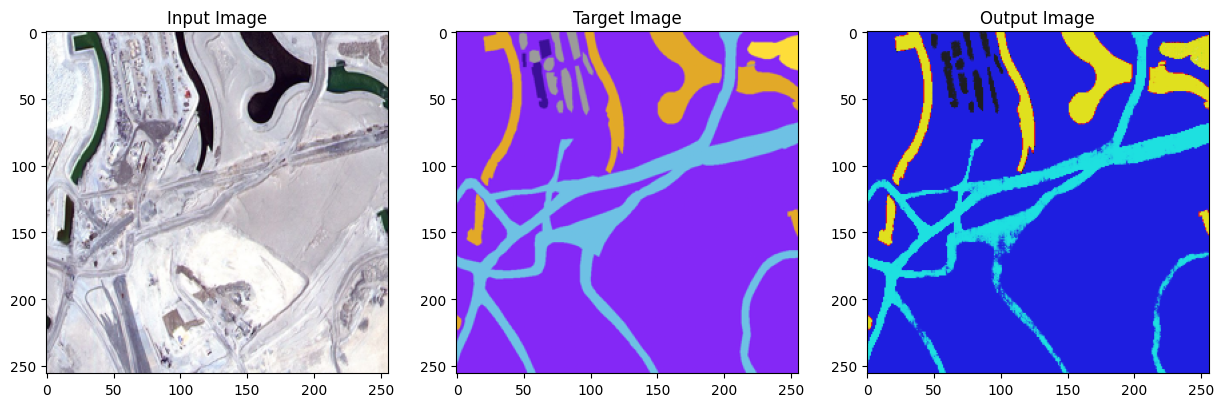

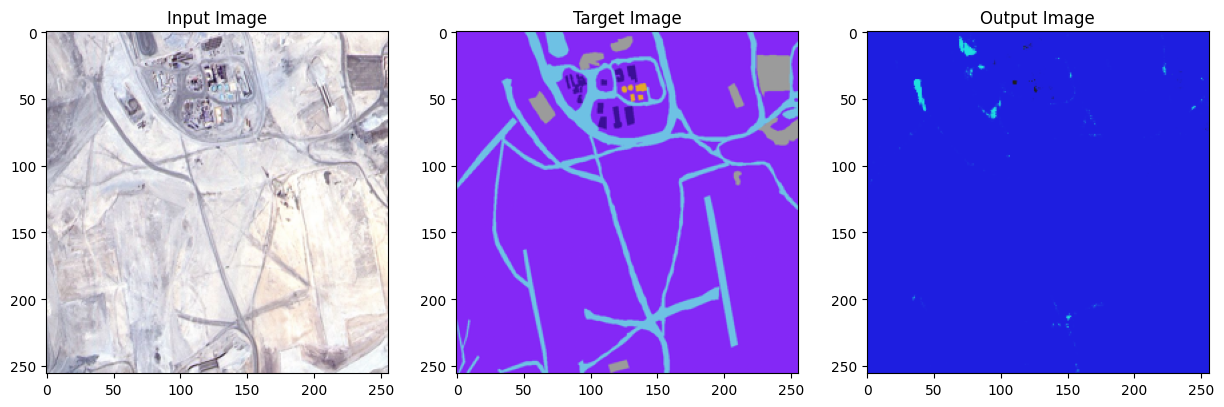

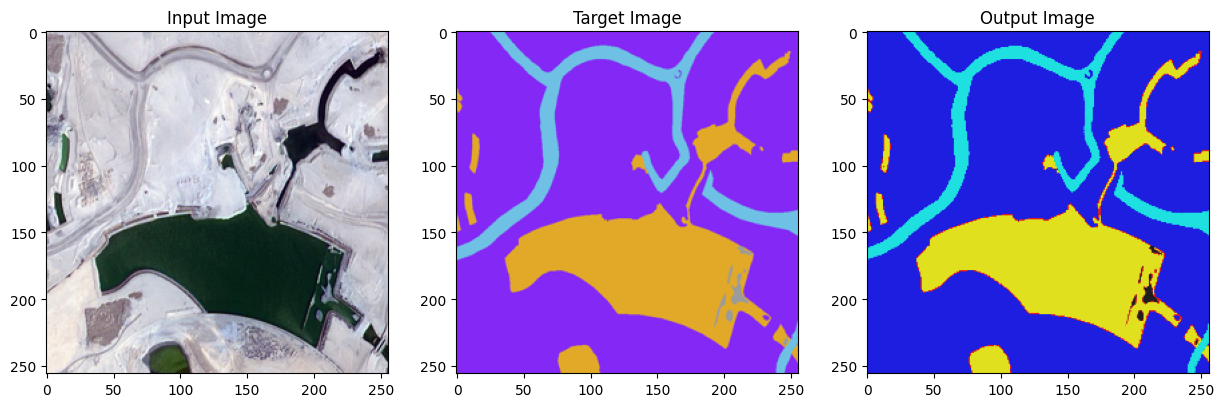

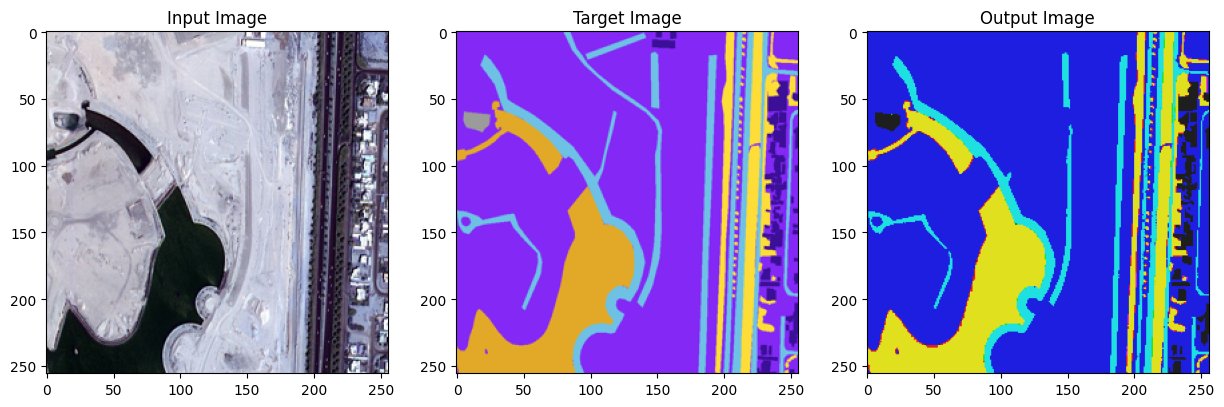

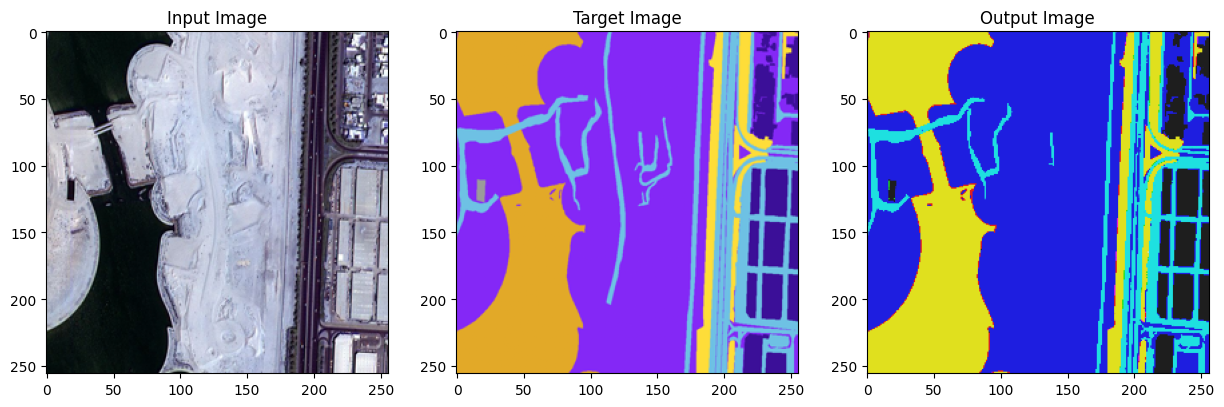

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def test_model(NetS, val_loader, cuda, num_images=5):
    NetS.eval()
    count = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            image, target = data
            if cuda:
                image = image.float().cuda()

            output = NetS(image)
            output = torch.tanh(output)
            # output = torch.sigmoid(output)

            # Convert tensors to numpy arrays for plotting
            input_np = image.cpu().numpy().transpose(0, 2, 3, 1)
            target_np = target.cpu().numpy().transpose(0, 2, 3, 1)
            output_np = output.cpu().numpy().transpose(0, 2, 3, 1)

            for j in range(image.size(0)):
                if count >= num_images:
                    return
                count += 1

                plt.figure(figsize=(15, 5))

                # Plot input image
                plt.subplot(1, 3, 1)
                plt.imshow((input_np[j] * 0.5 + 0.5).clip(0, 1))
                plt.title('Input Image')

                # Plot target image
                plt.subplot(1, 3, 2)
                plt.imshow((target_np[j] * 0.5 + 0.5).clip(0, 1))
                plt.title('Target Image')

                # Plot output image
                plt.subplot(1, 3, 3)
                plt.imshow((output_np[j] * 0.5 + 0.5).clip(0, 1), cmap="gray")
                plt.title('Output Image')

                plt.show()

# Call the test function after training
test_model(NetS, train_dataset, cuda)